<img src="https://www.iscte-iul.pt/assets/images/logo_iscte_detailed.svg" style="width: 450px;margin-top:30px;" align ="center">

<div style= "font-size: 40px;  margin-top:40px; font-weight:bold; font-family: 'Avenir Next LT Pro', sans-serif;"><center>Part 2: <strong>Neural Network Modeling</strong></center></div>
<div style= "font-size: 40px; font-weight:bold; font-family: 'Avenir Next LT Pro', sans-serif;"><center>of time series</center></div>

<div style= "font-size: 27px;font-weight:bold;line-height: 1.1; margin-top:40px; font-family: 'Avenir Next LT Pro', sans-serif;"><center>Análise de Séries Temporais e Previsão 2024/2025</center></div> <br>

   <div style= "font-size: 20px;font-weight:bold; font-family: 'Avenir Next LT Pro', sans-serif;"><center> Grupo 7:</center></div>
   <div><center> Diogo Freitas | 104841 </center></div>
   <div><center> João Francisco Botas | 104782 </center></div>
   <div><center> Miguel Gonçalves | 105944 </center></div>
   <div><center> Ricardo Galvão | 105285 </center></div>

In [1]:
import logging

In [2]:
# Desativa mensagem constante dos dispositivos disponíveis para treino de modelos
class IgnorePLFilter(logging.Filter):
    def filter(self, record):
        keywords = ['available:', 'CUDA', 'LOCAL_RANK:']
        return not any(keyword in record.getMessage() for keyword in keywords)
    
logging.getLogger('pytorch_lightning.utilities.rank_zero').addFilter(IgnorePLFilter())
logging.getLogger('pytorch_lightning.accelerators.cuda').addFilter(IgnorePLFilter())

In [3]:
from fredapi import Fred
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob

In [4]:
from collections import OrderedDict
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.stattools import adfuller, kpss, bds
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import het_arch
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import skewtest, kurtosistest, skew, kurtosis, boxcox
from pathlib import Path
import os

In [5]:
os.environ['OMP_NUM_THREADS'] = '1'

In [6]:
from darts import TimeSeries
from darts.utils import statistics
from darts.metrics import mape, smape, rmse, r2_score
from sklearn.preprocessing import MaxAbsScaler
from darts.dataprocessing.transformers import Scaler

In [7]:
import seaborn as sns

In [8]:
import optuna

In [9]:
# Inicializa ficheiro de armazenamento de trials do Optuna
optuna_storage_path = "optuna_journal_storage.log"
lock_obj = optuna.storages.journal.JournalFileOpenLock(optuna_storage_path)
storage = optuna.storages.JournalStorage(
    optuna.storages.journal.JournalFileBackend(optuna_storage_path, lock_obj=lock_obj)
)

# Inicialização das Séries

In [10]:
fred = Fred(api_key="8ede227d95e33c5cdf2ea8a83577bc0a")

In [11]:
fred_series_ids = ["IHLIDXNSAGB", "IRLTLT01GBM156N", "QGBN628BIS", "UKNGDP", "GBRCPIALLMINMEI"]

In [12]:
fred_series_metadata = []
fred_series_list = []
for series in fred_series_ids:
    metadata = fred.get_series_info(series)
    series = fred.get_series(series, observation_end='2025-04-30').rename(metadata["title"])
    fred_series_metadata.append(metadata)
    fred_series_list.append(series)

In [13]:
economic_uncertainty = pd.read_csv("../data/UK_Daily_Policy_Data.csv")

In [14]:
economic_uncertainty["date"] = pd.to_datetime(economic_uncertainty.drop("daily_policy_index", axis=1))
economic_uncertainty = economic_uncertainty.drop(["day", "month", "year"], axis=1).set_index("date").squeeze()

In [15]:
data = fred_series_list.copy()
data.append(economic_uncertainty)

In [16]:
data_ts = [TimeSeries.from_series(series) for series in data]

In [17]:
[print(f"{idx} {series.title} {len(data_ts[idx])}") for idx, series in enumerate(fred_series_metadata)]
print(f"{len(data_ts) - 1} UK_Daily_Policy_Data {len(data_ts[5])}")

0 Job Postings on Indeed in the United Kingdom 1916
1 Interest Rates: Long-Term Government Bond Yields: 10-Year: Main (Including Benchmark) for United Kingdom 784
2 Residential Property Prices for United Kingdom 228
3 Gross Domestic Product for United Kingdom 282
4 Consumer Price Indices (CPIs, HICPs), COICOP 1999: Consumer Price Index: Total for United Kingdom 843
5 UK_Daily_Policy_Data 8886


In [18]:
series_names = ["Job_Postings", "Interest_Rates", "Residential_Property_Prices", "GDP", "CPI", "Economic_Uncertainty"]

Escolha da série temporal a modelar:

In [19]:
series_chosen = 0
series = data_ts[series_chosen]
series_name = series_names[series_chosen]

Escolha das métricas a avaliar, incluindo seleção de uma principal para otimização de hiperparâmetros.

In [20]:
metrics = [smape]  #, r2_score]
main_metric = metrics[0]
assert main_metric in metrics

In [21]:
splitting = 0.9
visualizing = 0.7

In [22]:
train, test = series.split_before(splitting)
train, val = train.split_before(splitting)

Scaling das séries temporais para treino das redes neuronais.

In [23]:
scaler = MaxAbsScaler()
transformer = Scaler(scaler)

In [24]:
train = transformer.fit_transform(train)
val = transformer.transform(val)
test = transformer.transform(test)

# Modelação de Time Series com Redes Neuronais

O pacote *darts* possibilita o uso de várias arquiteturas de redes neuronais para modelação de séries temporais. Para a construção e treino das redes, utiliza como backend o pacote pytorch-lightning, um framework para pytorch.

Utilizamos uma GPU para treinar os nossos modelos localmente. 

In [25]:
import torch
for i in range(torch.cuda.device_count()):
   print(torch.cuda.get_device_properties(i).name)
torch.set_float32_matmul_precision('high')

NVIDIA GeForce RTX 5070 Ti


In [26]:
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks import Callback

In [27]:
# Criacao de um callback de logging dos losses de treino e validacao
class LossRecorder(Callback):
    def __init__(self):
        self.train_loss_history = []
        self.val_loss_history = []

    def on_train_epoch_end(self, trainer, pl_module):
        self.train_loss_history.append(trainer.callback_metrics["train_loss"].item())
        self.val_loss_history.append(trainer.callback_metrics["val_loss"].item())


In [28]:
loss_recorder = LossRecorder()
# stop training when validation loss does not decrease more than 0.00001 (`min_delta`) 
# over a period of 5 epochs (`patience`)
early_stopper = EarlyStopping(
    monitor="val_loss",
    patience=5,
    min_delta=0.00001,
    mode='min',
)

pl_trainer_kwargs={"callbacks": [early_stopper, loss_recorder]}

In [29]:
from darts.models import RNNModel, BlockRNNModel

### Treino de LSTM

Construção da primeira rede neuronal com hiperparâmetros default.

In [30]:
lstm_model = RNNModel(
    model="LSTM",
    hidden_dim=20,
    n_rnn_layers=3,
    dropout=0,
    batch_size=64,
    n_epochs=100,
    optimizer_kwargs={"lr": 1e-3},
    model_name="LSTM",
    log_tensorboard=True,
    random_state=7,
    training_length=int(len(val)/2),     # Estes hiperparametros sao um fator da dimensao da serie a ser modelada
    input_chunk_length=int(len(val)/4),  # para garantir inputs de dimensao adequada
    # output_chunk_length=12,
    force_reset=True,
    save_checkpoints=True,
    pl_trainer_kwargs=pl_trainer_kwargs,
)


In [31]:
# Treino do modelo com validacao
lstm_model.fit(train, val_series=val, verbose=True)


  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 8.6 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
8.6 K     Trainable params
0         Non-trainable params
8.6 K     Total params
0.034     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                                                               | 0/? [00:00<…

C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

RNNModel(model=LSTM, hidden_dim=20, n_rnn_layers=3, dropout=0, training_length=87, batch_size=64, n_epochs=100, optimizer_kwargs={'lr': 0.001}, model_name=LSTM, log_tensorboard=True, random_state=7, input_chunk_length=43, force_reset=True, save_checkpoints=True, pl_trainer_kwargs={'callbacks': [<pytorch_lightning.callbacks.early_stopping.EarlyStopping object at 0x000002C1DA1537C0>, <__main__.LossRecorder object at 0x000002C1DA153850>]})

O modelo apresenta uma aprendizagem adequada ao longo das épocas de treino.

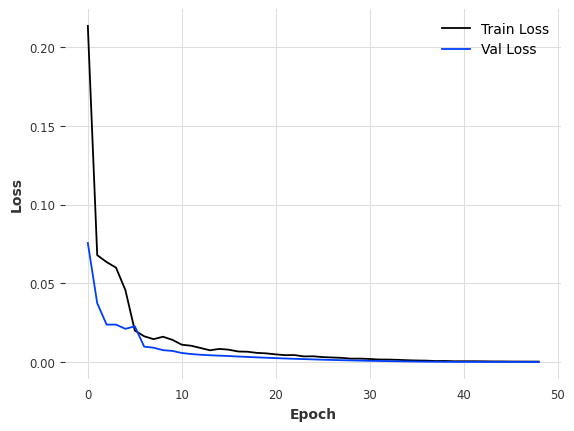

In [32]:
plt.plot(loss_recorder.train_loss_history, label='Train Loss')
plt.plot(loss_recorder.val_loss_history, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [33]:
lstm_model.load_from_checkpoint("LSTM", best=True)

RNNModel(model=LSTM, hidden_dim=20, n_rnn_layers=3, dropout=0, training_length=87, batch_size=64, n_epochs=100, optimizer_kwargs={'lr': 0.001}, model_name=LSTM, log_tensorboard=True, random_state=7, input_chunk_length=43, force_reset=True, save_checkpoints=True, pl_trainer_kwargs={'callbacks': [<pytorch_lightning.callbacks.early_stopping.EarlyStopping object at 0x000002C1EF571C60>, <__main__.LossRecorder object at 0x000002C1EF571FC0>]})

In [34]:
val_preds = transformer.inverse_transform(lstm_model.predict(len(val)))

Predicting: |                                                                                    | 0/? [00:00<…

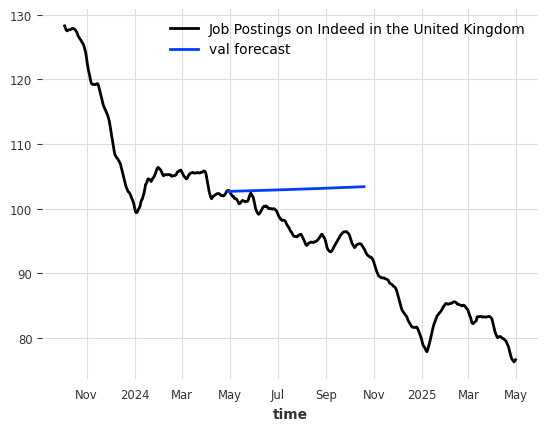

In [35]:
series.drop_before(visualizing).plot()
val_preds.plot(label="val forecast", low_quantile=0.05, high_quantile=0.95)
plt.legend()
plt.show()

O modelo 

### Treino de NBEATS

Como experiência, treinamos também uma arquitetura de redes neuronais mais recente, mas não realizamos mais desenvolvimentos devido à complexidade de treino maior associado a esta arquitetura. 
Mais informações: https://arxiv.org/abs/1905.10437

In [36]:
loss_recorder = LossRecorder()

# stop training when validation loss does not decrease more than 0.05 (`min_delta`) over
# a period of 5 epochs (`patience`)
early_stopper = EarlyStopping(
    monitor="val_loss",
    patience=5,
    min_delta=0.00001,
    mode='min',
)

pl_trainer_kwargs={"callbacks": [early_stopper, loss_recorder]}

In [37]:
# https://unit8co.github.io/darts/generated_api/darts.models.forecasting.nbeats.html
from darts.models import NBEATSModel
nbeats_model = NBEATSModel(
    input_chunk_length=24, 
    output_chunk_length=12, 
    batch_size=64,
    n_epochs=100, 
    random_state=7, 
    optimizer_kwargs={"lr": 1e-4},
    model_name="NBEATS",
    log_tensorboard=True,
    pl_trainer_kwargs=pl_trainer_kwargs
)
nbeats_model.fit(train, val_series=val, verbose=True)


  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 6.2 M  | train
-------------------------------------------------------------
6.2 M     Trainable params
1.4 K     Non-trainable params
6.2 M     Total params
24.787    Total estimated model params size (MB)
396       Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                                                               | 0/? [00:00<…

C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (24) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

NBEATSModel(output_chunk_shift=0, generic_architecture=True, num_stacks=30, num_blocks=1, num_layers=4, layer_widths=256, expansion_coefficient_dim=5, trend_polynomial_degree=2, dropout=0.0, activation=ReLU, input_chunk_length=24, output_chunk_length=12, batch_size=64, n_epochs=100, random_state=7, optimizer_kwargs={'lr': 0.0001}, model_name=NBEATS, log_tensorboard=True, pl_trainer_kwargs={'callbacks': [<pytorch_lightning.callbacks.early_stopping.EarlyStopping object at 0x000002C1F07F0070>, <__main__.LossRecorder object at 0x000002C1F07E3BB0>]})

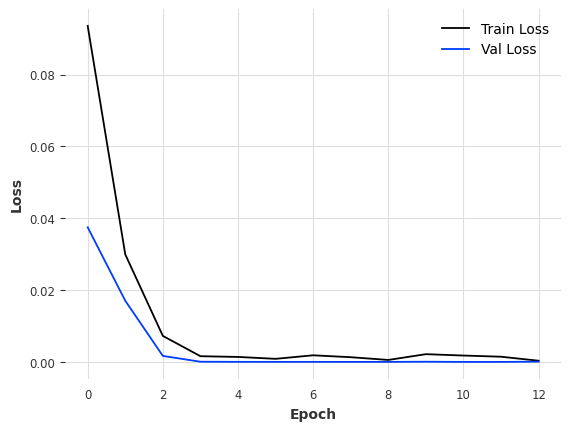

In [38]:
plt.plot(loss_recorder.train_loss_history, label='Train Loss')
plt.plot(loss_recorder.val_loss_history, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [39]:
len(val)

174

In [40]:
val_preds = transformer.inverse_transform(nbeats_model.predict(len(val)))

Predicting: |                                                                                    | 0/? [00:00<…

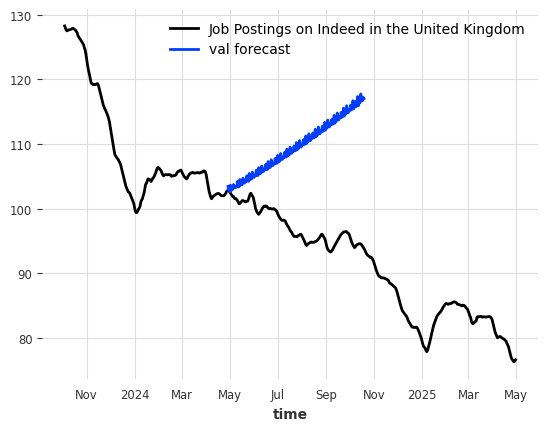

In [41]:
series.drop_before(visualizing).plot()
val_preds.plot(label="val forecast", low_quantile=0.05, high_quantile=0.95)
plt.legend()
plt.show()

# Backtesting NNs

In [42]:
from darts.models import NaiveSeasonal

In [43]:
base_model = NaiveSeasonal(K=1)

In [44]:
base_model.model_name = "Baseline"

In [45]:
def backtest_models(
    series: TimeSeries, 
    models: list, 
    horizons: list=[1, 3, 7], 
    points_to_test: int=len(test), 
    verbose=True, retrain=False, baseline=base_model, metrics=metrics
):
    backtest_results = dict()
    if baseline:
        models = [baseline, *models]
    for horizon in sorted(horizons):
        print(f"Backtesting {horizon} {series.freq} horizon")
        backtests = []
        for model in models:
            if model.model_name == "Baseline":
                backtest = model.historical_forecasts(
                    transformer.transform(series),
                    start=len(series) - points_to_test,
                    forecast_horizon=horizon,
                    retrain=True,
                    verbose=False,
                )
            else:
                print(f"Backtesting {model.model_name}")
                backtest = model.historical_forecasts(
                    transformer.transform(series),
                    start=len(series) - points_to_test,
                    forecast_horizon=horizon,
                    retrain=retrain,
                    verbose=verbose,
                )
            backtest = transformer.inverse_transform(backtest)
            backtests.append(backtest)
        backtest_results[horizon] = {
            str(model.model_name): (backtests[i], {metric.__name__: round(metric(series, backtests[i]), 3) for metric in metrics}) 
            for i, model in enumerate(models)
        }
    return backtest_results

In [46]:
def plot_backtest_results(
    series: TimeSeries, 
    backtest_results: dict, 
    points_to_test: int=len(test),
):
    for horizon, model in backtest_results.items():
        plt.figure(figsize=(12, 6))
        series.drop_before(int(len(series) - 1.5*points_to_test)).plot(label='data')
        for model_name, (backtest, metrics) in model.items():
            backtest.plot(lw=3, label=f'{model_name}, {metrics}')
        plt.title(f'Backtests with {horizon} {series.freq} forecast horizon')
        plt.ylabel("Series value")
        plt.legend()
        plt.show()

In [47]:
models = [nbeats_model, lstm_model]

In [48]:
results = backtest_models(
    series, 
    models=models, 
    metrics=metrics,
    points_to_test=len(test)
)

Backtesting 1 <Day> horizon
Backtesting NBEATS


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 3 <Day> horizon
Backtesting NBEATS


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 7 <Day> horizon
Backtesting NBEATS


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

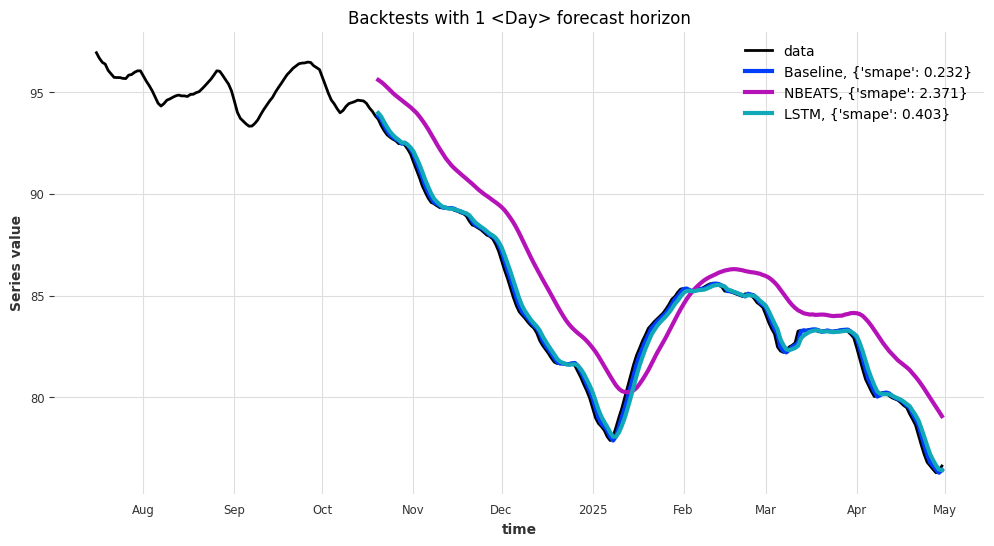

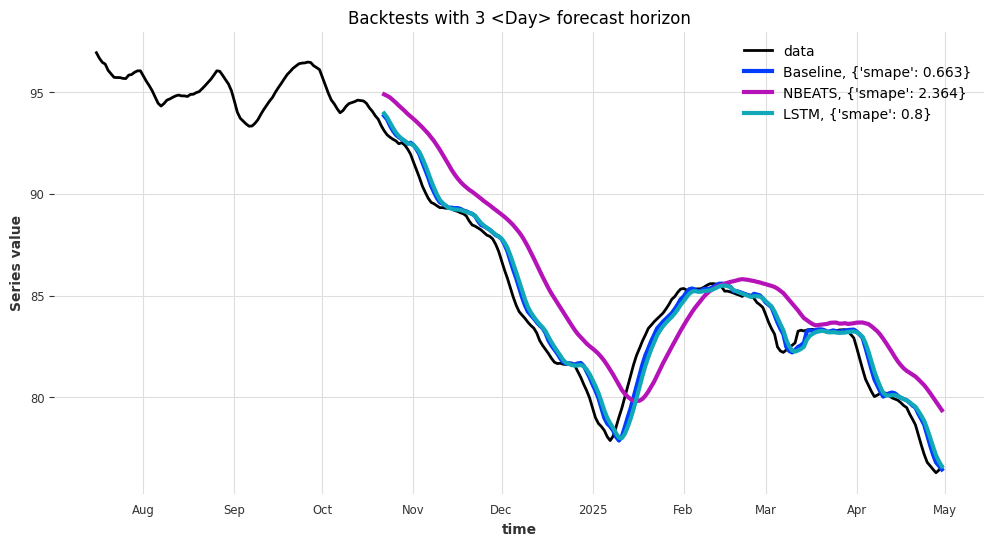

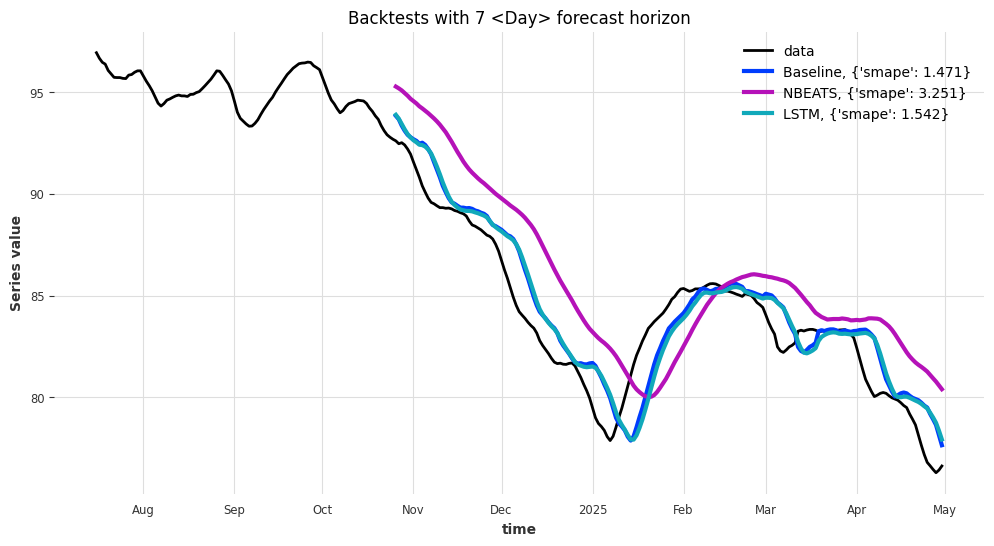

In [49]:
plot_backtest_results(series, results, points_to_test=len(test))

In [50]:
import optuna

In [51]:
def train_RNN(params):
    early_stopper = EarlyStopping(
        monitor="val_loss",
        patience=5,
        min_delta=0.05,
        mode='min',
    )
    pl_trainer_kwargs={"callbacks": [early_stopper]}
    
    model = RNNModel(
        **params,
        n_epochs=100,
        model_name=params["model"],
        log_tensorboard=True,
        random_state=7,
        training_length=int(len(val)/2),
        force_reset=True,
        save_checkpoints=True,
        pl_trainer_kwargs=pl_trainer_kwargs,
    )
    model.fit(train, val_series=val, verbose=False)
    model.load_from_checkpoint(params["model"], best=True)
    return model

In [52]:
model_chosen = None

In [53]:
def optimize_RNN(trial: optuna.Trial):
    params = {
        "model": model_chosen,
        "hidden_dim": trial.suggest_int("hidden_dim", 2, 50),
        "n_rnn_layers": trial.suggest_int("n_rnn_layers", 1, 5),
        "batch_size": 2 ** trial.suggest_int("log2(batch_size)", 4, 8),  # will be a power of two
        "input_chunk_length": trial.suggest_int("input_chunk_length", 1, int(len(val)/4)),
        "optimizer_kwargs": {
            "lr": trial.suggest_float("learning_rate", 1e-5, 1e-1, log=True)
        }
    }
    if params["n_rnn_layers"] != 1:
        params["dropout"] = trial.suggest_float("dropout", 0, 0.3)
        
    trial.set_user_attr("model_params", params)
    trial.set_user_attr("model_chosen", model_chosen)
    
    model = train_RNN(params)
    backtests = backtest_models(
        series[train.time_index.union(val.time_index)], 
        models=[model], 
        horizons=[7, 15, 30],
        metrics=metrics,
        points_to_test=len(val),
    )
    results = [model_dict[params["model"]][1][main_metric.__name__]/(horizon**0.5) 
               for horizon, model_dict in backtests.items()]
    
    return sum(results) / len(results)

In [54]:
model_family = ["RNN", "GRU", "LSTM"]

In [55]:
studies = []
for model_chosen in model_family:
    # Create optuna study with defined function and storage
    study = optuna.create_study(
        direction="minimize",
        storage=storage,
        study_name=f"{series_name}_{main_metric.__name__}_largehorizons_{model_chosen}_study",
        load_if_exists=True
    )
    # Optimize for n_trials, using one thread, timeout of 5 min
    study.optimize(optimize_RNN, n_trials=300, n_jobs=1)  # , timeout=30)

    studies.append(study)

[I 2025-09-06 18:53:02,841] A new study created in Journal with name: Job_Postings_smape_largehorizons_RNN_study
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 18:53:07,645] Trial 0 finished with value: 2.1186807166555046 and parameters: {'hidden_dim': 30, 'n_rnn_layers': 2, 'log2(batch_size)': 5, 'input_chunk_length': 24, 'learning_rate': 0.006210185231056308, 'dropout': 0.19158915506771243}. Best is trial 0 with value: 2.1186807166555046.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 18:53:10,842] Trial 1 finished with value: 0.6155468803293678 and parameters: {'hidden_dim': 12, 'n_rnn_layers': 1, 'log2(batch_size)': 6, 'input_chunk_length': 16, 'learning_rate': 2.465014577657391e-05}. Best is trial 1 with value: 0.6155468803293678.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 18:53:15,486] Trial 2 finished with value: 6.069924808099214 and parameters: {'hidden_dim': 24, 'n_rnn_layers': 1, 'log2(batch_size)': 5, 'input_chunk_length': 16, 'learning_rate': 0.00010965589488093954}. Best is trial 1 with value: 0.6155468803293678.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 18:53:19,538] Trial 3 finished with value: 5.160977463502433 and parameters: {'hidden_dim': 49, 'n_rnn_layers': 3, 'log2(batch_size)': 6, 'input_chunk_length': 26, 'learning_rate': 0.01171089768116726, 'dropout': 0.24280952672377845}. Best is trial 1 with value: 0.6155468803293678.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 18:53:26,583] Trial 4 finished with value: 11.777085603962911 and parameters: {'hidden_dim': 42, 'n_rnn_layers': 4, 'log2(batch_size)': 5, 'input_chunk_length': 35, 'learning_rate': 0.02119599533961905, 'dropout': 0.21104899716757522}. Best is trial 1 with value: 0.6155468803293678.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (12) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 18:53:30,326] Trial 5 finished with value: 3.519260240565595 and parameters: {'hidden_dim': 43, 'n_rnn_layers': 4, 'log2(batch_size)': 7, 'input_chunk_length': 35, 'learning_rate': 0.04656420176915024, 'dropout': 0.24622578486109092}. Best is trial 1 with value: 0.6155468803293678.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (6) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 18:53:32,948] Trial 6 finished with value: 4.8379265146902455 and parameters: {'hidden_dim': 19, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 30, 'learning_rate': 0.030063810081316828}. Best is trial 1 with value: 0.6155468803293678.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 18:53:43,321] Trial 7 finished with value: 1.6205806312309958 and parameters: {'hidden_dim': 50, 'n_rnn_layers': 4, 'log2(batch_size)': 4, 'input_chunk_length': 11, 'learning_rate': 0.03240751165819596, 'dropout': 0.14504374072816967}. Best is trial 1 with value: 0.6155468803293678.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 18:53:55,435] Trial 8 finished with value: 0.3191396690137065 and parameters: {'hidden_dim': 11, 'n_rnn_layers': 5, 'log2(batch_size)': 4, 'input_chunk_length': 18, 'learning_rate': 0.0010200280213190365, 'dropout': 0.19139294507900065}. Best is trial 8 with value: 0.3191396690137065.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 18:54:00,325] Trial 9 finished with value: 1.5224506890257514 and parameters: {'hidden_dim': 25, 'n_rnn_layers': 2, 'log2(batch_size)': 5, 'input_chunk_length': 30, 'learning_rate': 0.014556633910406031, 'dropout': 0.0651612944570004}. Best is trial 8 with value: 0.3191396690137065.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 18:54:12,411] Trial 10 finished with value: 9.813979826078244 and parameters: {'hidden_dim': 4, 'n_rnn_layers': 5, 'log2(batch_size)': 4, 'input_chunk_length': 5, 'learning_rate': 0.000842359783573688, 'dropout': 0.10899349568635419}. Best is trial 8 with value: 0.3191396690137065.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (12) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 18:54:16,291] Trial 11 finished with value: 1.5607253154529188 and parameters: {'hidden_dim': 7, 'n_rnn_layers': 5, 'log2(batch_size)': 7, 'input_chunk_length': 16, 'learning_rate': 1.3218262303411284e-05, 'dropout': 0.003658847767812057}. Best is trial 8 with value: 0.3191396690137065.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 18:54:20,476] Trial 12 finished with value: 6.579394585397535 and parameters: {'hidden_dim': 11, 'n_rnn_layers': 2, 'log2(batch_size)': 6, 'input_chunk_length': 43, 'learning_rate': 0.0006719035809115963, 'dropout': 0.29136529502889313}. Best is trial 8 with value: 0.3191396690137065.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (6) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 18:54:25,377] Trial 13 finished with value: 5.012332207707764 and parameters: {'hidden_dim': 13, 'n_rnn_layers': 3, 'log2(batch_size)': 8, 'input_chunk_length': 1, 'learning_rate': 0.00010540135192701474, 'dropout': 0.14479623323205762}. Best is trial 8 with value: 0.3191396690137065.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 18:54:44,937] Trial 14 finished with value: 0.9210222771298601 and parameters: {'hidden_dim': 16, 'n_rnn_layers': 5, 'log2(batch_size)': 4, 'input_chunk_length': 17, 'learning_rate': 1.1933210115948394e-05, 'dropout': 0.0774673241922833}. Best is trial 8 with value: 0.3191396690137065.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (12) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 18:54:48,316] Trial 15 finished with value: 4.939962956165773 and parameters: {'hidden_dim': 3, 'n_rnn_layers': 1, 'log2(batch_size)': 7, 'input_chunk_length': 9, 'learning_rate': 0.0028744283586286793}. Best is trial 8 with value: 0.3191396690137065.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 18:54:52,570] Trial 16 finished with value: 5.590290118884895 and parameters: {'hidden_dim': 30, 'n_rnn_layers': 3, 'log2(batch_size)': 6, 'input_chunk_length': 21, 'learning_rate': 0.00019239646902659461, 'dropout': 0.1821542076979725}. Best is trial 8 with value: 0.3191396690137065.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 18:55:04,789] Trial 17 finished with value: 7.016246471471413 and parameters: {'hidden_dim': 20, 'n_rnn_layers': 4, 'log2(batch_size)': 4, 'input_chunk_length': 11, 'learning_rate': 2.9936264578860007e-05, 'dropout': 0.28324725655768407}. Best is trial 8 with value: 0.3191396690137065.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (12) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 18:55:08,396] Trial 18 finished with value: 5.930134967459472 and parameters: {'hidden_dim': 9, 'n_rnn_layers': 2, 'log2(batch_size)': 7, 'input_chunk_length': 20, 'learning_rate': 0.0003447210120292303, 'dropout': 0.0025904441881935136}. Best is trial 8 with value: 0.3191396690137065.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 18:55:14,243] Trial 19 finished with value: 2.957648455424453 and parameters: {'hidden_dim': 34, 'n_rnn_layers': 3, 'log2(batch_size)': 5, 'input_chunk_length': 7, 'learning_rate': 0.0027244723341032745, 'dropout': 0.11166797027446465}. Best is trial 8 with value: 0.3191396690137065.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 18:55:17,421] Trial 20 finished with value: 19.34088533190535 and parameters: {'hidden_dim': 14, 'n_rnn_layers': 1, 'log2(batch_size)': 6, 'input_chunk_length': 14, 'learning_rate': 6.122225265873857e-05}. Best is trial 8 with value: 0.3191396690137065.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 18:55:37,990] Trial 21 finished with value: 3.37693420692389 and parameters: {'hidden_dim': 17, 'n_rnn_layers': 5, 'log2(batch_size)': 4, 'input_chunk_length': 18, 'learning_rate': 1.1028107782724098e-05, 'dropout': 0.060720430349917004}. Best is trial 8 with value: 0.3191396690137065.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 18:55:54,338] Trial 22 finished with value: 6.05286417643791 and parameters: {'hidden_dim': 16, 'n_rnn_layers': 5, 'log2(batch_size)': 4, 'input_chunk_length': 14, 'learning_rate': 2.8245370528991476e-05, 'dropout': 0.08329088797650253}. Best is trial 8 with value: 0.3191396690137065.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 18:56:06,204] Trial 23 finished with value: 5.725469936924365 and parameters: {'hidden_dim': 7, 'n_rnn_layers': 5, 'log2(batch_size)': 4, 'input_chunk_length': 24, 'learning_rate': 3.1611392692868694e-05, 'dropout': 0.04731642703272514}. Best is trial 8 with value: 0.3191396690137065.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 18:56:12,989] Trial 24 finished with value: 2.0307831893549655 and parameters: {'hidden_dim': 22, 'n_rnn_layers': 4, 'log2(batch_size)': 5, 'input_chunk_length': 19, 'learning_rate': 0.0002673286508280112, 'dropout': 0.11509138641779694}. Best is trial 8 with value: 0.3191396690137065.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 18:56:25,035] Trial 25 finished with value: 4.918763591746706 and parameters: {'hidden_dim': 12, 'n_rnn_layers': 5, 'log2(batch_size)': 4, 'input_chunk_length': 28, 'learning_rate': 0.002477197359940599, 'dropout': 0.1741921972039325}. Best is trial 8 with value: 0.3191396690137065.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 18:56:52,187] Trial 26 finished with value: 54.58250323942958 and parameters: {'hidden_dim': 2, 'n_rnn_layers': 4, 'log2(batch_size)': 6, 'input_chunk_length': 14, 'learning_rate': 5.816513439472313e-05, 'dropout': 0.22456603025652971}. Best is trial 8 with value: 0.3191396690137065.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 18:56:59,796] Trial 27 finished with value: 8.656710001935032 and parameters: {'hidden_dim': 16, 'n_rnn_layers': 5, 'log2(batch_size)': 5, 'input_chunk_length': 22, 'learning_rate': 0.0015817082239334883, 'dropout': 0.15403247000956927}. Best is trial 8 with value: 0.3191396690137065.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 18:57:21,091] Trial 28 finished with value: 1.7726652910164482 and parameters: {'hidden_dim': 9, 'n_rnn_layers': 3, 'log2(batch_size)': 4, 'input_chunk_length': 3, 'learning_rate': 1.89373324963054e-05, 'dropout': 0.023847776632364176}. Best is trial 8 with value: 0.3191396690137065.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 18:57:25,924] Trial 29 finished with value: 5.69535958315607 and parameters: {'hidden_dim': 30, 'n_rnn_layers': 2, 'log2(batch_size)': 5, 'input_chunk_length': 25, 'learning_rate': 0.005006681349859196, 'dropout': 0.10283108977461539}. Best is trial 8 with value: 0.3191396690137065.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (6) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 18:57:30,061] Trial 30 finished with value: 7.880271204537029 and parameters: {'hidden_dim': 20, 'n_rnn_layers': 4, 'log2(batch_size)': 8, 'input_chunk_length': 11, 'learning_rate': 0.00035385733854918105, 'dropout': 0.13091861407216915}. Best is trial 8 with value: 0.3191396690137065.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 18:57:34,846] Trial 31 finished with value: 4.315111660708048 and parameters: {'hidden_dim': 28, 'n_rnn_layers': 2, 'log2(batch_size)': 5, 'input_chunk_length': 33, 'learning_rate': 0.009342552717861621, 'dropout': 0.06775779408325516}. Best is trial 8 with value: 0.3191396690137065.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 18:57:39,091] Trial 32 finished with value: 2.526374542840816 and parameters: {'hidden_dim': 24, 'n_rnn_layers': 1, 'log2(batch_size)': 5, 'input_chunk_length': 41, 'learning_rate': 0.06627406089297679}. Best is trial 8 with value: 0.3191396690137065.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 18:57:44,856] Trial 33 finished with value: 6.377041624933309 and parameters: {'hidden_dim': 34, 'n_rnn_layers': 2, 'log2(batch_size)': 5, 'input_chunk_length': 17, 'learning_rate': 6.55334164241766e-05, 'dropout': 0.03740789680203423}. Best is trial 8 with value: 0.3191396690137065.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 18:57:50,561] Trial 34 finished with value: 5.379680273849064 and parameters: {'hidden_dim': 27, 'n_rnn_layers': 1, 'log2(batch_size)': 4, 'input_chunk_length': 28, 'learning_rate': 0.00013966028028568583}. Best is trial 8 with value: 0.3191396690137065.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 18:57:53,648] Trial 35 finished with value: 4.71673208313746 and parameters: {'hidden_dim': 23, 'n_rnn_layers': 1, 'log2(batch_size)': 6, 'input_chunk_length': 24, 'learning_rate': 0.01387750530349169}. Best is trial 8 with value: 0.3191396690137065.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 18:57:58,392] Trial 36 finished with value: 5.2600587308089075 and parameters: {'hidden_dim': 6, 'n_rnn_layers': 2, 'log2(batch_size)': 5, 'input_chunk_length': 38, 'learning_rate': 0.00459137325679181, 'dropout': 0.07872557661641194}. Best is trial 8 with value: 0.3191396690137065.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 18:58:05,025] Trial 37 finished with value: 3.5969433256710714 and parameters: {'hidden_dim': 36, 'n_rnn_layers': 2, 'log2(batch_size)': 4, 'input_chunk_length': 32, 'learning_rate': 0.0004952305901663275, 'dropout': 0.2034963772381176}. Best is trial 8 with value: 0.3191396690137065.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 18:58:16,274] Trial 38 finished with value: 6.319667730619077 and parameters: {'hidden_dim': 18, 'n_rnn_layers': 3, 'log2(batch_size)': 6, 'input_chunk_length': 27, 'learning_rate': 1.7053925706767277e-05, 'dropout': 0.16298036848821426}. Best is trial 8 with value: 0.3191396690137065.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 18:58:20,076] Trial 39 finished with value: 1.845303031854448 and parameters: {'hidden_dim': 14, 'n_rnn_layers': 1, 'log2(batch_size)': 5, 'input_chunk_length': 16, 'learning_rate': 0.022057209093791327}. Best is trial 8 with value: 0.3191396690137065.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 18:58:31,894] Trial 40 finished with value: 0.3550474305017963 and parameters: {'hidden_dim': 11, 'n_rnn_layers': 5, 'log2(batch_size)': 4, 'input_chunk_length': 23, 'learning_rate': 0.0010859705179256712, 'dropout': 0.09143506840089802}. Best is trial 8 with value: 0.3191396690137065.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 18:58:43,703] Trial 41 finished with value: 0.5735192843933922 and parameters: {'hidden_dim': 11, 'n_rnn_layers': 5, 'log2(batch_size)': 4, 'input_chunk_length': 23, 'learning_rate': 0.0013703987769605257, 'dropout': 0.0895403900616814}. Best is trial 8 with value: 0.3191396690137065.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 18:58:55,214] Trial 42 finished with value: 6.968100967667774 and parameters: {'hidden_dim': 10, 'n_rnn_layers': 5, 'log2(batch_size)': 4, 'input_chunk_length': 22, 'learning_rate': 0.0013683976845877425, 'dropout': 0.0966606747511938}. Best is trial 8 with value: 0.3191396690137065.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 18:59:07,092] Trial 43 finished with value: 9.977410242405226 and parameters: {'hidden_dim': 6, 'n_rnn_layers': 5, 'log2(batch_size)': 4, 'input_chunk_length': 22, 'learning_rate': 0.0008719057346515324, 'dropout': 0.12260193773888808}. Best is trial 8 with value: 0.3191396690137065.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 18:59:18,879] Trial 44 finished with value: 0.7382571595432998 and parameters: {'hidden_dim': 14, 'n_rnn_layers': 5, 'log2(batch_size)': 4, 'input_chunk_length': 19, 'learning_rate': 0.0012427465942870068, 'dropout': 0.09245068028489838}. Best is trial 8 with value: 0.3191396690137065.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 18:59:28,996] Trial 45 finished with value: 2.9072325472466147 and parameters: {'hidden_dim': 12, 'n_rnn_layers': 4, 'log2(batch_size)': 4, 'input_chunk_length': 19, 'learning_rate': 0.0012966516039230158, 'dropout': 0.1336983443087154}. Best is trial 8 with value: 0.3191396690137065.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (12) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 18:59:34,298] Trial 46 finished with value: 6.5126783142402855 and parameters: {'hidden_dim': 9, 'n_rnn_layers': 5, 'log2(batch_size)': 7, 'input_chunk_length': 24, 'learning_rate': 0.0005772772287770607, 'dropout': 0.2620463139279766}. Best is trial 8 with value: 0.3191396690137065.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 18:59:45,922] Trial 47 finished with value: 1.3391362501172728 and parameters: {'hidden_dim': 4, 'n_rnn_layers': 5, 'log2(batch_size)': 4, 'input_chunk_length': 13, 'learning_rate': 0.0017202060751719001, 'dropout': 0.09115148319267591}. Best is trial 8 with value: 0.3191396690137065.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 18:59:55,760] Trial 48 finished with value: 3.1531554561552 and parameters: {'hidden_dim': 14, 'n_rnn_layers': 4, 'log2(batch_size)': 4, 'input_chunk_length': 20, 'learning_rate': 0.008032904109231393, 'dropout': 0.22283900133454795}. Best is trial 8 with value: 0.3191396690137065.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:00:07,396] Trial 49 finished with value: 9.584833058114725 and parameters: {'hidden_dim': 8, 'n_rnn_layers': 5, 'log2(batch_size)': 4, 'input_chunk_length': 22, 'learning_rate': 0.0009923529639520284, 'dropout': 0.1945405549113786}. Best is trial 8 with value: 0.3191396690137065.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:00:20,146] Trial 50 finished with value: 2.3932264335450877 and parameters: {'hidden_dim': 43, 'n_rnn_layers': 5, 'log2(batch_size)': 4, 'input_chunk_length': 26, 'learning_rate': 0.0023219285801434337, 'dropout': 0.04599290049219046}. Best is trial 8 with value: 0.3191396690137065.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:00:31,771] Trial 51 finished with value: 3.104904913771737 and parameters: {'hidden_dim': 12, 'n_rnn_layers': 5, 'log2(batch_size)': 4, 'input_chunk_length': 17, 'learning_rate': 0.003624651545095719, 'dropout': 0.06147445992623561}. Best is trial 8 with value: 0.3191396690137065.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:00:43,631] Trial 52 finished with value: 2.2042052603139717 and parameters: {'hidden_dim': 15, 'n_rnn_layers': 5, 'log2(batch_size)': 4, 'input_chunk_length': 15, 'learning_rate': 0.0007285847399726962, 'dropout': 0.07886238190177271}. Best is trial 8 with value: 0.3191396690137065.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (6) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:00:46,966] Trial 53 finished with value: 3.2465783782384805 and parameters: {'hidden_dim': 19, 'n_rnn_layers': 5, 'log2(batch_size)': 8, 'input_chunk_length': 12, 'learning_rate': 0.0019333794728032757, 'dropout': 0.025202741689585056}. Best is trial 8 with value: 0.3191396690137065.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:00:56,990] Trial 54 finished with value: 8.474154165993724 and parameters: {'hidden_dim': 11, 'n_rnn_layers': 4, 'log2(batch_size)': 4, 'input_chunk_length': 18, 'learning_rate': 0.0003264524019400271, 'dropout': 0.13982464189723115}. Best is trial 8 with value: 0.3191396690137065.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:01:09,170] Trial 55 finished with value: 4.195096044995455 and parameters: {'hidden_dim': 46, 'n_rnn_layers': 5, 'log2(batch_size)': 4, 'input_chunk_length': 8, 'learning_rate': 0.0005181161383249432, 'dropout': 0.09820586440822446}. Best is trial 8 with value: 0.3191396690137065.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:01:15,486] Trial 56 finished with value: 2.503061599045004 and parameters: {'hidden_dim': 5, 'n_rnn_layers': 4, 'log2(batch_size)': 5, 'input_chunk_length': 20, 'learning_rate': 0.0011582486941239417, 'dropout': 0.1620962575197793}. Best is trial 8 with value: 0.3191396690137065.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (12) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:01:19,379] Trial 57 finished with value: 28.905006427416463 and parameters: {'hidden_dim': 17, 'n_rnn_layers': 5, 'log2(batch_size)': 7, 'input_chunk_length': 16, 'learning_rate': 1.020060047339148e-05, 'dropout': 0.0756175657062652}. Best is trial 8 with value: 0.3191396690137065.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:01:31,148] Trial 58 finished with value: 3.953206474528157 and parameters: {'hidden_dim': 22, 'n_rnn_layers': 5, 'log2(batch_size)': 4, 'input_chunk_length': 10, 'learning_rate': 0.0002141590917686296, 'dropout': 0.11728221644632038}. Best is trial 8 with value: 0.3191396690137065.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:01:42,979] Trial 59 finished with value: 4.88832079485951 and parameters: {'hidden_dim': 10, 'n_rnn_layers': 5, 'log2(batch_size)': 4, 'input_chunk_length': 19, 'learning_rate': 3.854973391902992e-05, 'dropout': 0.18054222755270113}. Best is trial 8 with value: 0.3191396690137065.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:01:49,402] Trial 60 finished with value: 5.525356477692587 and parameters: {'hidden_dim': 13, 'n_rnn_layers': 4, 'log2(batch_size)': 5, 'input_chunk_length': 30, 'learning_rate': 0.00010668155605479257, 'dropout': 0.05473729911855655}. Best is trial 8 with value: 0.3191396690137065.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:02:00,862] Trial 61 finished with value: 2.9543913616291135 and parameters: {'hidden_dim': 4, 'n_rnn_layers': 5, 'log2(batch_size)': 4, 'input_chunk_length': 14, 'learning_rate': 0.001739817814396716, 'dropout': 0.086570001347744}. Best is trial 8 with value: 0.3191396690137065.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:02:12,457] Trial 62 finished with value: 4.807504817931313 and parameters: {'hidden_dim': 2, 'n_rnn_layers': 5, 'log2(batch_size)': 4, 'input_chunk_length': 12, 'learning_rate': 0.0031098093106826687, 'dropout': 0.0916533745159202}. Best is trial 8 with value: 0.3191396690137065.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:02:24,249] Trial 63 finished with value: 2.595462689802617 and parameters: {'hidden_dim': 7, 'n_rnn_layers': 5, 'log2(batch_size)': 4, 'input_chunk_length': 13, 'learning_rate': 0.0004311359482581683, 'dropout': 0.10931285006191804}. Best is trial 8 with value: 0.3191396690137065.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:02:35,958] Trial 64 finished with value: 3.1668738530664284 and parameters: {'hidden_dim': 16, 'n_rnn_layers': 5, 'log2(batch_size)': 4, 'input_chunk_length': 21, 'learning_rate': 0.0008389800665246013, 'dropout': 0.0702868544214127}. Best is trial 8 with value: 0.3191396690137065.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:03:01,237] Trial 65 finished with value: 17.38388035773988 and parameters: {'hidden_dim': 4, 'n_rnn_layers': 5, 'log2(batch_size)': 4, 'input_chunk_length': 17, 'learning_rate': 1.9875490126041334e-05, 'dropout': 0.12207773385194112}. Best is trial 8 with value: 0.3191396690137065.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:03:13,344] Trial 66 finished with value: 8.776566709556775 and parameters: {'hidden_dim': 8, 'n_rnn_layers': 5, 'log2(batch_size)': 4, 'input_chunk_length': 15, 'learning_rate': 0.0019878438513341147, 'dropout': 0.08994071721053118}. Best is trial 8 with value: 0.3191396690137065.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (12) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:03:16,893] Trial 67 finished with value: 6.420937465443804 and parameters: {'hidden_dim': 11, 'n_rnn_layers': 4, 'log2(batch_size)': 7, 'input_chunk_length': 23, 'learning_rate': 0.0053588890429154285, 'dropout': 0.10590610947840923}. Best is trial 8 with value: 0.3191396690137065.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:03:24,155] Trial 68 finished with value: 4.566079584995407 and parameters: {'hidden_dim': 13, 'n_rnn_layers': 5, 'log2(batch_size)': 5, 'input_chunk_length': 18, 'learning_rate': 0.0010077269523870497, 'dropout': 0.042217592025250515}. Best is trial 8 with value: 0.3191396690137065.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:03:32,633] Trial 69 finished with value: 1.072600779480963 and parameters: {'hidden_dim': 15, 'n_rnn_layers': 3, 'log2(batch_size)': 4, 'input_chunk_length': 20, 'learning_rate': 0.0006601764339059585, 'dropout': 0.024495082752047134}. Best is trial 8 with value: 0.3191396690137065.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:03:43,345] Trial 70 finished with value: 4.571884282268527 and parameters: {'hidden_dim': 21, 'n_rnn_layers': 3, 'log2(batch_size)': 4, 'input_chunk_length': 25, 'learning_rate': 1.590427171884907e-05, 'dropout': 0.014684617280480644}. Best is trial 8 with value: 0.3191396690137065.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:03:55,248] Trial 71 finished with value: 1.4545050814935478 and parameters: {'hidden_dim': 18, 'n_rnn_layers': 5, 'log2(batch_size)': 4, 'input_chunk_length': 20, 'learning_rate': 0.0015279829749402945, 'dropout': 0.054860880983221505}. Best is trial 8 with value: 0.3191396690137065.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:04:03,730] Trial 72 finished with value: 1.9512717991552149 and parameters: {'hidden_dim': 15, 'n_rnn_layers': 3, 'log2(batch_size)': 4, 'input_chunk_length': 21, 'learning_rate': 0.003760561384612166, 'dropout': 0.033767212742939395}. Best is trial 8 with value: 0.3191396690137065.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:04:15,436] Trial 73 finished with value: 8.883868053274798 and parameters: {'hidden_dim': 10, 'n_rnn_layers': 5, 'log2(batch_size)': 4, 'input_chunk_length': 15, 'learning_rate': 0.0007759200390491175, 'dropout': 0.12948739697606904}. Best is trial 8 with value: 0.3191396690137065.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:04:25,529] Trial 74 finished with value: 2.9942026484803694 and parameters: {'hidden_dim': 13, 'n_rnn_layers': 4, 'log2(batch_size)': 4, 'input_chunk_length': 23, 'learning_rate': 0.0006230656616220358, 'dropout': 0.15026239223085305}. Best is trial 8 with value: 0.3191396690137065.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:04:32,746] Trial 75 finished with value: 1.58454698175594 and parameters: {'hidden_dim': 15, 'n_rnn_layers': 5, 'log2(batch_size)': 5, 'input_chunk_length': 18, 'learning_rate': 0.006943155726551269, 'dropout': 0.0023590018425293097}. Best is trial 8 with value: 0.3191396690137065.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:04:44,457] Trial 76 finished with value: 2.0316043986094923 and parameters: {'hidden_dim': 8, 'n_rnn_layers': 5, 'log2(batch_size)': 4, 'input_chunk_length': 13, 'learning_rate': 0.00014430861894112714, 'dropout': 0.24768779620231973}. Best is trial 8 with value: 0.3191396690137065.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:04:58,315] Trial 77 finished with value: 5.812886799768454 and parameters: {'hidden_dim': 11, 'n_rnn_layers': 4, 'log2(batch_size)': 4, 'input_chunk_length': 19, 'learning_rate': 3.911842139025337e-05, 'dropout': 0.07139385221938155}. Best is trial 8 with value: 0.3191396690137065.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:05:29,742] Trial 78 finished with value: 0.6715426874090403 and parameters: {'hidden_dim': 6, 'n_rnn_layers': 3, 'log2(batch_size)': 4, 'input_chunk_length': 26, 'learning_rate': 2.3384449867966462e-05, 'dropout': 0.10177321060053351}. Best is trial 8 with value: 0.3191396690137065.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:05:38,271] Trial 79 finished with value: 6.798286702502864 and parameters: {'hidden_dim': 17, 'n_rnn_layers': 3, 'log2(batch_size)': 6, 'input_chunk_length': 29, 'learning_rate': 2.3421563962882604e-05, 'dropout': 0.10022620457222953}. Best is trial 8 with value: 0.3191396690137065.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:05:53,025] Trial 80 finished with value: 54.58250323942958 and parameters: {'hidden_dim': 6, 'n_rnn_layers': 3, 'log2(batch_size)': 5, 'input_chunk_length': 26, 'learning_rate': 1.3493447088170933e-05, 'dropout': 0.05450783387814122}. Best is trial 8 with value: 0.3191396690137065.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:06:08,989] Trial 81 finished with value: 5.364287544439978 and parameters: {'hidden_dim': 3, 'n_rnn_layers': 2, 'log2(batch_size)': 4, 'input_chunk_length': 23, 'learning_rate': 5.232164475499434e-05, 'dropout': 0.08354991615493006}. Best is trial 8 with value: 0.3191396690137065.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:06:21,303] Trial 82 finished with value: 5.694714196444994 and parameters: {'hidden_dim': 9, 'n_rnn_layers': 3, 'log2(batch_size)': 4, 'input_chunk_length': 25, 'learning_rate': 7.468415200311056e-05, 'dropout': 0.09354745648019393}. Best is trial 8 with value: 0.3191396690137065.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:06:30,699] Trial 83 finished with value: 6.008940258675646 and parameters: {'hidden_dim': 5, 'n_rnn_layers': 3, 'log2(batch_size)': 4, 'input_chunk_length': 27, 'learning_rate': 0.002344626744917948, 'dropout': 0.06380160990328268}. Best is trial 8 with value: 0.3191396690137065.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:06:35,778] Trial 84 finished with value: 4.8425062376483305 and parameters: {'hidden_dim': 7, 'n_rnn_layers': 1, 'log2(batch_size)': 4, 'input_chunk_length': 21, 'learning_rate': 0.0012917302215006688}. Best is trial 8 with value: 0.3191396690137065.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:07:06,206] Trial 85 finished with value: 2.7074661081453986 and parameters: {'hidden_dim': 14, 'n_rnn_layers': 5, 'log2(batch_size)': 4, 'input_chunk_length': 17, 'learning_rate': 1.3241670064231872e-05, 'dropout': 0.11218788180542762}. Best is trial 8 with value: 0.3191396690137065.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:07:27,545] Trial 86 finished with value: 1.8176696877366074 and parameters: {'hidden_dim': 11, 'n_rnn_layers': 2, 'log2(batch_size)': 4, 'input_chunk_length': 16, 'learning_rate': 2.8368001262432796e-05, 'dropout': 0.08076613626208244}. Best is trial 8 with value: 0.3191396690137065.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:07:35,755] Trial 87 finished with value: 0.7412133923883749 and parameters: {'hidden_dim': 12, 'n_rnn_layers': 3, 'log2(batch_size)': 4, 'input_chunk_length': 24, 'learning_rate': 0.001050489660093813, 'dropout': 0.01372893389951404}. Best is trial 8 with value: 0.3191396690137065.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (6) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:07:38,909] Trial 88 finished with value: 3.8491794914898723 and parameters: {'hidden_dim': 12, 'n_rnn_layers': 3, 'log2(batch_size)': 8, 'input_chunk_length': 24, 'learning_rate': 0.0011318156512733265, 'dropout': 0.01941085692720719}. Best is trial 8 with value: 0.3191396690137065.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:07:47,517] Trial 89 finished with value: 5.077891861680101 and parameters: {'hidden_dim': 16, 'n_rnn_layers': 3, 'log2(batch_size)': 4, 'input_chunk_length': 26, 'learning_rate': 0.0004258037130350846, 'dropout': 0.010991614198444577}. Best is trial 8 with value: 0.3191396690137065.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:07:57,815] Trial 90 finished with value: 0.7420945443235176 and parameters: {'hidden_dim': 18, 'n_rnn_layers': 3, 'log2(batch_size)': 5, 'input_chunk_length': 28, 'learning_rate': 2.144618066220341e-05, 'dropout': 0.03042120497521625}. Best is trial 8 with value: 0.3191396690137065.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:08:11,005] Trial 91 finished with value: 4.4440797055999735 and parameters: {'hidden_dim': 18, 'n_rnn_layers': 3, 'log2(batch_size)': 5, 'input_chunk_length': 31, 'learning_rate': 2.0765975480367715e-05, 'dropout': 0.02975298966432291}. Best is trial 8 with value: 0.3191396690137065.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:08:17,018] Trial 92 finished with value: 16.60322895132318 and parameters: {'hidden_dim': 20, 'n_rnn_layers': 3, 'log2(batch_size)': 6, 'input_chunk_length': 28, 'learning_rate': 1.4973595607538086e-05, 'dropout': 0.015844001305770503}. Best is trial 8 with value: 0.3191396690137065.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:08:28,232] Trial 93 finished with value: 5.9056138757203875 and parameters: {'hidden_dim': 13, 'n_rnn_layers': 3, 'log2(batch_size)': 4, 'input_chunk_length': 23, 'learning_rate': 3.9355430558557664e-05, 'dropout': 0.03910994269277369}. Best is trial 8 with value: 0.3191396690137065.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:08:32,399] Trial 94 finished with value: 5.22344791869767 and parameters: {'hidden_dim': 15, 'n_rnn_layers': 3, 'log2(batch_size)': 6, 'input_chunk_length': 29, 'learning_rate': 0.00026829144502191253, 'dropout': 0.028073658650628646}. Best is trial 8 with value: 0.3191396690137065.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:08:45,353] Trial 95 finished with value: 3.7389500364839816 and parameters: {'hidden_dim': 10, 'n_rnn_layers': 2, 'log2(batch_size)': 4, 'input_chunk_length': 35, 'learning_rate': 2.534852617922785e-05, 'dropout': 0.008449859378883977}. Best is trial 8 with value: 0.3191396690137065.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:08:51,041] Trial 96 finished with value: 3.8862679254243937 and parameters: {'hidden_dim': 14, 'n_rnn_layers': 3, 'log2(batch_size)': 5, 'input_chunk_length': 21, 'learning_rate': 4.940045155684712e-05, 'dropout': 0.048908445845053806}. Best is trial 8 with value: 0.3191396690137065.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:08:59,723] Trial 97 finished with value: 1.0197660914389581 and parameters: {'hidden_dim': 19, 'n_rnn_layers': 3, 'log2(batch_size)': 4, 'input_chunk_length': 25, 'learning_rate': 0.0007069717132646334, 'dropout': 0.20236922583874356}. Best is trial 8 with value: 0.3191396690137065.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:09:14,610] Trial 98 finished with value: 2.983318957929176 and parameters: {'hidden_dim': 19, 'n_rnn_layers': 3, 'log2(batch_size)': 4, 'input_chunk_length': 27, 'learning_rate': 1.1263134455508258e-05, 'dropout': 0.22803788381240264}. Best is trial 8 with value: 0.3191396690137065.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:09:21,878] Trial 99 finished with value: 5.815554626207366 and parameters: {'hidden_dim': 25, 'n_rnn_layers': 4, 'log2(batch_size)': 5, 'input_chunk_length': 24, 'learning_rate': 8.078235024275162e-05, 'dropout': 0.1974160670126759}. Best is trial 8 with value: 0.3191396690137065.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:09:30,098] Trial 100 finished with value: 4.427528857626217 and parameters: {'hidden_dim': 12, 'n_rnn_layers': 3, 'log2(batch_size)': 4, 'input_chunk_length': 25, 'learning_rate': 0.0009231473307755058, 'dropout': 0.20588913425359007}. Best is trial 8 with value: 0.3191396690137065.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:09:39,015] Trial 101 finished with value: 2.379461367309504 and parameters: {'hidden_dim': 17, 'n_rnn_layers': 3, 'log2(batch_size)': 4, 'input_chunk_length': 20, 'learning_rate': 0.0006140916491335389, 'dropout': 0.22175845044611026}. Best is trial 8 with value: 0.3191396690137065.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:09:47,253] Trial 102 finished with value: 4.142871725413904 and parameters: {'hidden_dim': 14, 'n_rnn_layers': 3, 'log2(batch_size)': 4, 'input_chunk_length': 19, 'learning_rate': 0.0007268006046522998, 'dropout': 0.17707387512755454}. Best is trial 8 with value: 0.3191396690137065.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:10:00,239] Trial 103 finished with value: 2.8707323955254878 and parameters: {'hidden_dim': 16, 'n_rnn_layers': 3, 'log2(batch_size)': 4, 'input_chunk_length': 22, 'learning_rate': 0.03952961279869769, 'dropout': 0.18628757883756766}. Best is trial 8 with value: 0.3191396690137065.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:10:06,854] Trial 104 finished with value: 1.0439900389962946 and parameters: {'hidden_dim': 10, 'n_rnn_layers': 2, 'log2(batch_size)': 4, 'input_chunk_length': 25, 'learning_rate': 0.001461666351419657, 'dropout': 0.17124840652810389}. Best is trial 8 with value: 0.3191396690137065.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:10:13,555] Trial 105 finished with value: 4.770836005943633 and parameters: {'hidden_dim': 9, 'n_rnn_layers': 2, 'log2(batch_size)': 4, 'input_chunk_length': 26, 'learning_rate': 0.0021259934398094836, 'dropout': 0.16892451489207513}. Best is trial 8 with value: 0.3191396690137065.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:10:18,537] Trial 106 finished with value: 2.210509128063704 and parameters: {'hidden_dim': 9, 'n_rnn_layers': 1, 'log2(batch_size)': 4, 'input_chunk_length': 27, 'learning_rate': 0.0014846959017169245}. Best is trial 8 with value: 0.3191396690137065.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:10:23,563] Trial 107 finished with value: 2.0966492499831344 and parameters: {'hidden_dim': 12, 'n_rnn_layers': 1, 'log2(batch_size)': 4, 'input_chunk_length': 24, 'learning_rate': 0.00115016600672445}. Best is trial 8 with value: 0.3191396690137065.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:10:30,091] Trial 108 finished with value: 3.9000665970457007 and parameters: {'hidden_dim': 10, 'n_rnn_layers': 2, 'log2(batch_size)': 4, 'input_chunk_length': 28, 'learning_rate': 0.0028803346928479336, 'dropout': 0.1972990634983978}. Best is trial 8 with value: 0.3191396690137065.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:10:44,304] Trial 109 finished with value: 10.072569144956068 and parameters: {'hidden_dim': 8, 'n_rnn_layers': 2, 'log2(batch_size)': 4, 'input_chunk_length': 29, 'learning_rate': 1.7584995052504115e-05, 'dropout': 0.18915042886252267}. Best is trial 8 with value: 0.3191396690137065.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:10:56,347] Trial 110 finished with value: 0.948736984002127 and parameters: {'hidden_dim': 21, 'n_rnn_layers': 5, 'log2(batch_size)': 4, 'input_chunk_length': 31, 'learning_rate': 0.0018462512087675338, 'dropout': 0.2139031866729428}. Best is trial 8 with value: 0.3191396690137065.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:11:08,037] Trial 111 finished with value: 0.9923968412310463 and parameters: {'hidden_dim': 22, 'n_rnn_layers': 5, 'log2(batch_size)': 4, 'input_chunk_length': 33, 'learning_rate': 0.0015889894921111399, 'dropout': 0.21264094788493773}. Best is trial 8 with value: 0.3191396690137065.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:11:20,229] Trial 112 finished with value: 7.65137653390816 and parameters: {'hidden_dim': 21, 'n_rnn_layers': 5, 'log2(batch_size)': 4, 'input_chunk_length': 34, 'learning_rate': 0.0010368437922076445, 'dropout': 0.214088855953856}. Best is trial 8 with value: 0.3191396690137065.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:11:32,813] Trial 113 finished with value: 12.492824266687599 and parameters: {'hidden_dim': 23, 'n_rnn_layers': 5, 'log2(batch_size)': 4, 'input_chunk_length': 36, 'learning_rate': 0.0017549779786368454, 'dropout': 0.2350380175982562}. Best is trial 8 with value: 0.3191396690137065.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:11:44,762] Trial 114 finished with value: 12.02940553767713 and parameters: {'hidden_dim': 19, 'n_rnn_layers': 5, 'log2(batch_size)': 4, 'input_chunk_length': 32, 'learning_rate': 0.002580404909509425, 'dropout': 0.20958615444057296}. Best is trial 8 with value: 0.3191396690137065.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:11:56,844] Trial 115 finished with value: 2.3694167168153757 and parameters: {'hidden_dim': 22, 'n_rnn_layers': 5, 'log2(batch_size)': 4, 'input_chunk_length': 31, 'learning_rate': 0.0012949983663209591, 'dropout': 0.21722590951733334}. Best is trial 8 with value: 0.3191396690137065.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (12) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:12:00,821] Trial 116 finished with value: 1.6545648714576464 and parameters: {'hidden_dim': 27, 'n_rnn_layers': 5, 'log2(batch_size)': 7, 'input_chunk_length': 33, 'learning_rate': 0.003620228944533981, 'dropout': 0.2494061652754725}. Best is trial 8 with value: 0.3191396690137065.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:12:13,261] Trial 117 finished with value: 6.940971227112539 and parameters: {'hidden_dim': 21, 'n_rnn_layers': 5, 'log2(batch_size)': 4, 'input_chunk_length': 36, 'learning_rate': 0.00082083432944467, 'dropout': 0.23913207015030985}. Best is trial 8 with value: 0.3191396690137065.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:12:25,463] Trial 118 finished with value: 6.013331687672402 and parameters: {'hidden_dim': 20, 'n_rnn_layers': 5, 'log2(batch_size)': 4, 'input_chunk_length': 31, 'learning_rate': 3.2683653037070585e-05, 'dropout': 0.10362068002680305}. Best is trial 8 with value: 0.3191396690137065.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:12:33,120] Trial 119 finished with value: 7.009830131946264 and parameters: {'hidden_dim': 23, 'n_rnn_layers': 5, 'log2(batch_size)': 5, 'input_chunk_length': 18, 'learning_rate': 0.0018509411414758675, 'dropout': 0.12127207296939606}. Best is trial 8 with value: 0.3191396690137065.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:12:54,355] Trial 120 finished with value: 1.6055534830963267 and parameters: {'hidden_dim': 18, 'n_rnn_layers': 5, 'log2(batch_size)': 4, 'input_chunk_length': 30, 'learning_rate': 1.0306995487053932e-05, 'dropout': 0.140465898546507}. Best is trial 8 with value: 0.3191396690137065.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:13:06,784] Trial 121 finished with value: 8.67185222091811 and parameters: {'hidden_dim': 13, 'n_rnn_layers': 5, 'log2(batch_size)': 4, 'input_chunk_length': 23, 'learning_rate': 0.0013638981916410916, 'dropout': 0.15726022082679614}. Best is trial 8 with value: 0.3191396690137065.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:13:12,069] Trial 122 finished with value: 0.6505257110261334 and parameters: {'hidden_dim': 25, 'n_rnn_layers': 1, 'log2(batch_size)': 4, 'input_chunk_length': 25, 'learning_rate': 0.0015875709033579555}. Best is trial 8 with value: 0.3191396690137065.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:13:17,309] Trial 123 finished with value: 1.8905260273827784 and parameters: {'hidden_dim': 25, 'n_rnn_layers': 1, 'log2(batch_size)': 4, 'input_chunk_length': 22, 'learning_rate': 0.0005072975007866642}. Best is trial 8 with value: 0.3191396690137065.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:13:22,627] Trial 124 finished with value: 1.016957176350809 and parameters: {'hidden_dim': 17, 'n_rnn_layers': 1, 'log2(batch_size)': 4, 'input_chunk_length': 25, 'learning_rate': 0.002158106607155424}. Best is trial 8 with value: 0.3191396690137065.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:13:28,366] Trial 125 finished with value: 1.3542774226075196 and parameters: {'hidden_dim': 29, 'n_rnn_layers': 1, 'log2(batch_size)': 4, 'input_chunk_length': 16, 'learning_rate': 0.0031389549812359486}. Best is trial 8 with value: 0.3191396690137065.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:13:33,577] Trial 126 finished with value: 0.3877057572458515 and parameters: {'hidden_dim': 24, 'n_rnn_layers': 1, 'log2(batch_size)': 4, 'input_chunk_length': 27, 'learning_rate': 0.0009640297932123443}. Best is trial 8 with value: 0.3191396690137065.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:13:38,444] Trial 127 finished with value: 14.87239131396816 and parameters: {'hidden_dim': 32, 'n_rnn_layers': 1, 'log2(batch_size)': 6, 'input_chunk_length': 28, 'learning_rate': 2.285097378380263e-05}. Best is trial 8 with value: 0.3191396690137065.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:13:43,617] Trial 128 finished with value: 0.389360267618732 and parameters: {'hidden_dim': 24, 'n_rnn_layers': 1, 'log2(batch_size)': 4, 'input_chunk_length': 26, 'learning_rate': 0.001067060097122946}. Best is trial 8 with value: 0.3191396690137065.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:13:48,869] Trial 129 finished with value: 1.1232959356925847 and parameters: {'hidden_dim': 25, 'n_rnn_layers': 1, 'log2(batch_size)': 4, 'input_chunk_length': 27, 'learning_rate': 0.0009952731715890165}. Best is trial 8 with value: 0.3191396690137065.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:13:54,064] Trial 130 finished with value: 1.5136287794026775 and parameters: {'hidden_dim': 26, 'n_rnn_layers': 1, 'log2(batch_size)': 4, 'input_chunk_length': 26, 'learning_rate': 0.0011627650317802963}. Best is trial 8 with value: 0.3191396690137065.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:13:59,257] Trial 131 finished with value: 1.1629954796877924 and parameters: {'hidden_dim': 26, 'n_rnn_layers': 1, 'log2(batch_size)': 4, 'input_chunk_length': 29, 'learning_rate': 0.0016256839729237521}. Best is trial 8 with value: 0.3191396690137065.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:14:04,449] Trial 132 finished with value: 0.46171382465439476 and parameters: {'hidden_dim': 24, 'n_rnn_layers': 1, 'log2(batch_size)': 4, 'input_chunk_length': 17, 'learning_rate': 0.0019375818864225064}. Best is trial 8 with value: 0.3191396690137065.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:14:09,600] Trial 133 finished with value: 3.2636493541762364 and parameters: {'hidden_dim': 24, 'n_rnn_layers': 1, 'log2(batch_size)': 4, 'input_chunk_length': 17, 'learning_rate': 0.019485443851491705}. Best is trial 8 with value: 0.3191396690137065.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:14:14,840] Trial 134 finished with value: 1.6185956317605676 and parameters: {'hidden_dim': 28, 'n_rnn_layers': 1, 'log2(batch_size)': 4, 'input_chunk_length': 15, 'learning_rate': 0.0009054663823806629}. Best is trial 8 with value: 0.3191396690137065.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:14:20,074] Trial 135 finished with value: 2.6971073580706606 and parameters: {'hidden_dim': 23, 'n_rnn_layers': 1, 'log2(batch_size)': 4, 'input_chunk_length': 24, 'learning_rate': 0.0020065603742748985}. Best is trial 8 with value: 0.3191396690137065.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:14:25,693] Trial 136 finished with value: 4.471974744391654 and parameters: {'hidden_dim': 38, 'n_rnn_layers': 1, 'log2(batch_size)': 4, 'input_chunk_length': 27, 'learning_rate': 0.0024927679257097184}. Best is trial 8 with value: 0.3191396690137065.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:14:30,849] Trial 137 finished with value: 1.6835466715513387 and parameters: {'hidden_dim': 24, 'n_rnn_layers': 1, 'log2(batch_size)': 4, 'input_chunk_length': 19, 'learning_rate': 0.004664140769246086}. Best is trial 8 with value: 0.3191396690137065.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:14:36,060] Trial 138 finished with value: 9.290892658312126 and parameters: {'hidden_dim': 11, 'n_rnn_layers': 1, 'log2(batch_size)': 4, 'input_chunk_length': 18, 'learning_rate': 1.227021473527486e-05}. Best is trial 8 with value: 0.3191396690137065.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:14:41,223] Trial 139 finished with value: 1.954972500300915 and parameters: {'hidden_dim': 22, 'n_rnn_layers': 1, 'log2(batch_size)': 4, 'input_chunk_length': 21, 'learning_rate': 0.0011103643911492768}. Best is trial 8 with value: 0.3191396690137065.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:14:45,048] Trial 140 finished with value: 54.58250323942958 and parameters: {'hidden_dim': 13, 'n_rnn_layers': 1, 'log2(batch_size)': 5, 'input_chunk_length': 14, 'learning_rate': 1.539520403296108e-05}. Best is trial 8 with value: 0.3191396690137065.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:14:57,355] Trial 141 finished with value: 2.8505720090558335 and parameters: {'hidden_dim': 24, 'n_rnn_layers': 5, 'log2(batch_size)': 4, 'input_chunk_length': 26, 'learning_rate': 0.0016044694137981963, 'dropout': 0.07761803437900028}. Best is trial 8 with value: 0.3191396690137065.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:15:09,790] Trial 142 finished with value: 3.3400675562817224 and parameters: {'hidden_dim': 27, 'n_rnn_layers': 5, 'log2(batch_size)': 4, 'input_chunk_length': 16, 'learning_rate': 0.0009065057625900544, 'dropout': 0.08571036301988609}. Best is trial 8 with value: 0.3191396690137065.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:15:22,337] Trial 143 finished with value: 1.8270392585294097 and parameters: {'hidden_dim': 21, 'n_rnn_layers': 5, 'log2(batch_size)': 4, 'input_chunk_length': 32, 'learning_rate': 0.0014232055186818935, 'dropout': 0.12984258250128938}. Best is trial 8 with value: 0.3191396690137065.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:15:27,598] Trial 144 finished with value: 2.0790624949231904 and parameters: {'hidden_dim': 23, 'n_rnn_layers': 1, 'log2(batch_size)': 4, 'input_chunk_length': 23, 'learning_rate': 0.08379975913804327}. Best is trial 8 with value: 0.3191396690137065.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:15:40,004] Trial 145 finished with value: 2.4954895534634214 and parameters: {'hidden_dim': 25, 'n_rnn_layers': 5, 'log2(batch_size)': 4, 'input_chunk_length': 30, 'learning_rate': 0.0012267521677561722, 'dropout': 0.258800419120002}. Best is trial 8 with value: 0.3191396690137065.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:15:52,208] Trial 146 finished with value: 0.6849343246924912 and parameters: {'hidden_dim': 14, 'n_rnn_layers': 5, 'log2(batch_size)': 4, 'input_chunk_length': 33, 'learning_rate': 0.0018284882169636964, 'dropout': 0.07423677722370507}. Best is trial 8 with value: 0.3191396690137065.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:15:57,349] Trial 147 finished with value: 2.325791255886435 and parameters: {'hidden_dim': 16, 'n_rnn_layers': 1, 'log2(batch_size)': 4, 'input_chunk_length': 17, 'learning_rate': 0.0019376911569084164}. Best is trial 8 with value: 0.3191396690137065.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:16:10,078] Trial 148 finished with value: 5.752106914891432 and parameters: {'hidden_dim': 11, 'n_rnn_layers': 5, 'log2(batch_size)': 4, 'input_chunk_length': 22, 'learning_rate': 0.0004051537811526482, 'dropout': 0.05972482550585795}. Best is trial 8 with value: 0.3191396690137065.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:16:22,476] Trial 149 finished with value: 3.015310985457703 and parameters: {'hidden_dim': 15, 'n_rnn_layers': 5, 'log2(batch_size)': 4, 'input_chunk_length': 24, 'learning_rate': 0.0032724554467356047, 'dropout': 0.07128059430108732}. Best is trial 8 with value: 0.3191396690137065.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (12) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:16:25,422] Trial 150 finished with value: 6.278646394646365 and parameters: {'hidden_dim': 12, 'n_rnn_layers': 1, 'log2(batch_size)': 7, 'input_chunk_length': 19, 'learning_rate': 0.0005778435266521328}. Best is trial 8 with value: 0.3191396690137065.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:16:37,759] Trial 151 finished with value: 0.6911115292155053 and parameters: {'hidden_dim': 14, 'n_rnn_layers': 5, 'log2(batch_size)': 4, 'input_chunk_length': 33, 'learning_rate': 0.0017560485107075488, 'dropout': 0.0978546425282687}. Best is trial 8 with value: 0.3191396690137065.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:16:50,047] Trial 152 finished with value: 2.044866602210085 and parameters: {'hidden_dim': 14, 'n_rnn_layers': 5, 'log2(batch_size)': 4, 'input_chunk_length': 34, 'learning_rate': 0.0007483163327434833, 'dropout': 0.09318706490078126}. Best is trial 8 with value: 0.3191396690137065.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:17:02,409] Trial 153 finished with value: 3.5871853601174277 and parameters: {'hidden_dim': 12, 'n_rnn_layers': 5, 'log2(batch_size)': 4, 'input_chunk_length': 33, 'learning_rate': 0.002273206584391253, 'dropout': 0.09852832331872004}. Best is trial 8 with value: 0.3191396690137065.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:17:22,760] Trial 154 finished with value: 6.112703041965186 and parameters: {'hidden_dim': 14, 'n_rnn_layers': 5, 'log2(batch_size)': 4, 'input_chunk_length': 26, 'learning_rate': 3.315643023552442e-05, 'dropout': 0.10784927494984836}. Best is trial 8 with value: 0.3191396690137065.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:17:35,243] Trial 155 finished with value: 0.5940072711208542 and parameters: {'hidden_dim': 15, 'n_rnn_layers': 5, 'log2(batch_size)': 4, 'input_chunk_length': 34, 'learning_rate': 0.0013327024944880432, 'dropout': 0.11592947310208992}. Best is trial 8 with value: 0.3191396690137065.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:17:47,427] Trial 156 finished with value: 0.7462373782297301 and parameters: {'hidden_dim': 14, 'n_rnn_layers': 5, 'log2(batch_size)': 4, 'input_chunk_length': 17, 'learning_rate': 0.0012645071829065335, 'dropout': 0.08844468335493859}. Best is trial 8 with value: 0.3191396690137065.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:17:59,626] Trial 157 finished with value: 0.5761908591509615 and parameters: {'hidden_dim': 14, 'n_rnn_layers': 5, 'log2(batch_size)': 4, 'input_chunk_length': 38, 'learning_rate': 0.0013125302343419314, 'dropout': 0.11558376804765075}. Best is trial 8 with value: 0.3191396690137065.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:18:10,198] Trial 158 finished with value: 2.3020896557938384 and parameters: {'hidden_dim': 13, 'n_rnn_layers': 4, 'log2(batch_size)': 4, 'input_chunk_length': 40, 'learning_rate': 0.0014693689796980507, 'dropout': 0.11406369511789559}. Best is trial 8 with value: 0.3191396690137065.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:18:22,618] Trial 159 finished with value: 0.3842401127661321 and parameters: {'hidden_dim': 15, 'n_rnn_layers': 5, 'log2(batch_size)': 4, 'input_chunk_length': 38, 'learning_rate': 0.0009205178680327719, 'dropout': 0.11829228918011238}. Best is trial 8 with value: 0.3191396690137065.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (6) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:18:26,288] Trial 160 finished with value: 4.82619835877265 and parameters: {'hidden_dim': 15, 'n_rnn_layers': 5, 'log2(batch_size)': 8, 'input_chunk_length': 39, 'learning_rate': 0.0009828826127525185, 'dropout': 0.12395250725404153}. Best is trial 8 with value: 0.3191396690137065.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:18:38,695] Trial 161 finished with value: 1.8007012001294527 and parameters: {'hidden_dim': 11, 'n_rnn_layers': 5, 'log2(batch_size)': 4, 'input_chunk_length': 43, 'learning_rate': 0.0008312960733120457, 'dropout': 0.10129949763287703}. Best is trial 8 with value: 0.3191396690137065.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:18:50,871] Trial 162 finished with value: 6.4259166206738625 and parameters: {'hidden_dim': 16, 'n_rnn_layers': 5, 'log2(batch_size)': 4, 'input_chunk_length': 40, 'learning_rate': 0.001034250549406659, 'dropout': 0.11725494046200048}. Best is trial 8 with value: 0.3191396690137065.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:19:03,258] Trial 163 finished with value: 7.778159185859141 and parameters: {'hidden_dim': 13, 'n_rnn_layers': 5, 'log2(batch_size)': 4, 'input_chunk_length': 37, 'learning_rate': 0.0013020888210901476, 'dropout': 0.13875116190608108}. Best is trial 8 with value: 0.3191396690137065.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:19:15,610] Trial 164 finished with value: 5.0002909116781025 and parameters: {'hidden_dim': 15, 'n_rnn_layers': 5, 'log2(batch_size)': 4, 'input_chunk_length': 35, 'learning_rate': 0.0016921537118561242, 'dropout': 0.11210332115649382}. Best is trial 8 with value: 0.3191396690137065.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:19:27,825] Trial 165 finished with value: 0.73008800605775 and parameters: {'hidden_dim': 12, 'n_rnn_layers': 5, 'log2(batch_size)': 4, 'input_chunk_length': 36, 'learning_rate': 0.0011481124793302885, 'dropout': 0.1052974382936758}. Best is trial 8 with value: 0.3191396690137065.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:19:40,187] Trial 166 finished with value: 0.5488043071515664 and parameters: {'hidden_dim': 11, 'n_rnn_layers': 5, 'log2(batch_size)': 4, 'input_chunk_length': 38, 'learning_rate': 0.002598083244215362, 'dropout': 0.10612678646688378}. Best is trial 8 with value: 0.3191396690137065.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:19:52,277] Trial 167 finished with value: 3.3711449595968914 and parameters: {'hidden_dim': 10, 'n_rnn_layers': 5, 'log2(batch_size)': 4, 'input_chunk_length': 38, 'learning_rate': 0.004000098107911787, 'dropout': 0.1067512211537664}. Best is trial 8 with value: 0.3191396690137065.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:20:04,667] Trial 168 finished with value: 0.32974357938755555 and parameters: {'hidden_dim': 9, 'n_rnn_layers': 5, 'log2(batch_size)': 4, 'input_chunk_length': 37, 'learning_rate': 0.00272630133501802, 'dropout': 0.09583025977354341}. Best is trial 8 with value: 0.3191396690137065.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:20:17,022] Trial 169 finished with value: 0.3125465181320069 and parameters: {'hidden_dim': 9, 'n_rnn_layers': 5, 'log2(batch_size)': 4, 'input_chunk_length': 36, 'learning_rate': 0.002622431667922056, 'dropout': 0.09525969892173099}. Best is trial 169 with value: 0.3125465181320069.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:20:29,128] Trial 170 finished with value: 9.92652311383077 and parameters: {'hidden_dim': 8, 'n_rnn_layers': 5, 'log2(batch_size)': 4, 'input_chunk_length': 37, 'learning_rate': 0.0029922450177721303, 'dropout': 0.09469859259307968}. Best is trial 169 with value: 0.3125465181320069.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:20:41,232] Trial 171 finished with value: 2.8835957154052942 and parameters: {'hidden_dim': 6, 'n_rnn_layers': 5, 'log2(batch_size)': 4, 'input_chunk_length': 38, 'learning_rate': 0.005834383063444318, 'dropout': 0.12537640241575126}. Best is trial 169 with value: 0.3125465181320069.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:20:54,124] Trial 172 finished with value: 0.4219858808949703 and parameters: {'hidden_dim': 9, 'n_rnn_layers': 5, 'log2(batch_size)': 4, 'input_chunk_length': 36, 'learning_rate': 0.0026287849535922034, 'dropout': 0.09957881997004753}. Best is trial 169 with value: 0.3125465181320069.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:21:06,563] Trial 173 finished with value: 10.3018449739324 and parameters: {'hidden_dim': 7, 'n_rnn_layers': 5, 'log2(batch_size)': 4, 'input_chunk_length': 38, 'learning_rate': 0.0027218599613871007, 'dropout': 0.08211849042121756}. Best is trial 169 with value: 0.3125465181320069.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:21:18,935] Trial 174 finished with value: 1.8027174192054316 and parameters: {'hidden_dim': 9, 'n_rnn_layers': 5, 'log2(batch_size)': 4, 'input_chunk_length': 37, 'learning_rate': 0.0021646545354888852, 'dropout': 0.09908927259542315}. Best is trial 169 with value: 0.3125465181320069.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:21:31,083] Trial 175 finished with value: 10.705542604057428 and parameters: {'hidden_dim': 8, 'n_rnn_layers': 5, 'log2(batch_size)': 4, 'input_chunk_length': 39, 'learning_rate': 0.003985477608007805, 'dropout': 0.11679875178291452}. Best is trial 169 with value: 0.3125465181320069.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:21:43,284] Trial 176 finished with value: 3.6772591877345016 and parameters: {'hidden_dim': 10, 'n_rnn_layers': 5, 'log2(batch_size)': 4, 'input_chunk_length': 34, 'learning_rate': 0.0023475591061634326, 'dropout': 0.08728521402338532}. Best is trial 169 with value: 0.3125465181320069.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:21:55,509] Trial 177 finished with value: 7.582080260349808 and parameters: {'hidden_dim': 6, 'n_rnn_layers': 5, 'log2(batch_size)': 4, 'input_chunk_length': 36, 'learning_rate': 0.0026019451425124606, 'dropout': 0.07670305533045112}. Best is trial 169 with value: 0.3125465181320069.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:22:07,554] Trial 178 finished with value: 2.0064988069755247 and parameters: {'hidden_dim': 9, 'n_rnn_layers': 5, 'log2(batch_size)': 4, 'input_chunk_length': 35, 'learning_rate': 0.0018681458615015531, 'dropout': 0.13502298539499186}. Best is trial 169 with value: 0.3125465181320069.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:22:19,622] Trial 179 finished with value: 4.368494826854984 and parameters: {'hidden_dim': 11, 'n_rnn_layers': 5, 'log2(batch_size)': 4, 'input_chunk_length': 37, 'learning_rate': 0.003286015071711448, 'dropout': 0.09597481946178478}. Best is trial 169 with value: 0.3125465181320069.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:22:31,508] Trial 180 finished with value: 5.651110056703026 and parameters: {'hidden_dim': 10, 'n_rnn_layers': 5, 'log2(batch_size)': 4, 'input_chunk_length': 39, 'learning_rate': 0.0015205941231079508, 'dropout': 0.11051714580801421}. Best is trial 169 with value: 0.3125465181320069.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:22:43,449] Trial 181 finished with value: 2.7208016414013207 and parameters: {'hidden_dim': 12, 'n_rnn_layers': 5, 'log2(batch_size)': 4, 'input_chunk_length': 35, 'learning_rate': 0.001951064579549764, 'dropout': 0.10156977181126726}. Best is trial 169 with value: 0.3125465181320069.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:22:55,464] Trial 182 finished with value: 0.2879743521053841 and parameters: {'hidden_dim': 11, 'n_rnn_layers': 5, 'log2(batch_size)': 4, 'input_chunk_length': 36, 'learning_rate': 0.002534538083690127, 'dropout': 0.09084446468519491}. Best is trial 182 with value: 0.2879743521053841.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:23:07,359] Trial 183 finished with value: 8.227643647059844 and parameters: {'hidden_dim': 7, 'n_rnn_layers': 5, 'log2(batch_size)': 4, 'input_chunk_length': 36, 'learning_rate': 0.0029016154969385482, 'dropout': 0.06772300901208135}. Best is trial 182 with value: 0.2879743521053841.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:23:19,697] Trial 184 finished with value: 5.884225564710967 and parameters: {'hidden_dim': 9, 'n_rnn_layers': 5, 'log2(batch_size)': 4, 'input_chunk_length': 34, 'learning_rate': 0.004381074091994912, 'dropout': 0.0904458215715749}. Best is trial 182 with value: 0.2879743521053841.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:23:31,630] Trial 185 finished with value: 0.3642418634690829 and parameters: {'hidden_dim': 11, 'n_rnn_layers': 5, 'log2(batch_size)': 4, 'input_chunk_length': 38, 'learning_rate': 0.0025344633513784743, 'dropout': 0.08245885832970604}. Best is trial 182 with value: 0.2879743521053841.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:23:43,582] Trial 186 finished with value: 1.3079424471734413 and parameters: {'hidden_dim': 11, 'n_rnn_layers': 5, 'log2(batch_size)': 4, 'input_chunk_length': 38, 'learning_rate': 0.0025757994134582903, 'dropout': 0.07387391531509029}. Best is trial 182 with value: 0.2879743521053841.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:23:48,646] Trial 187 finished with value: 1.5935819621323484 and parameters: {'hidden_dim': 10, 'n_rnn_layers': 1, 'log2(batch_size)': 4, 'input_chunk_length': 41, 'learning_rate': 0.002242171245626125}. Best is trial 182 with value: 0.2879743521053841.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:24:00,364] Trial 188 finished with value: 8.492431723638935 and parameters: {'hidden_dim': 8, 'n_rnn_layers': 5, 'log2(batch_size)': 4, 'input_chunk_length': 37, 'learning_rate': 0.003359247851136774, 'dropout': 0.08840068133815987}. Best is trial 182 with value: 0.2879743521053841.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:24:12,316] Trial 189 finished with value: 1.2017003000015605 and parameters: {'hidden_dim': 9, 'n_rnn_layers': 5, 'log2(batch_size)': 4, 'input_chunk_length': 40, 'learning_rate': 0.0026751732868225547, 'dropout': 0.08046114984645933}. Best is trial 182 with value: 0.2879743521053841.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:24:17,374] Trial 190 finished with value: 2.9554388692763425 and parameters: {'hidden_dim': 11, 'n_rnn_layers': 1, 'log2(batch_size)': 4, 'input_chunk_length': 39, 'learning_rate': 0.0014695305975849153}. Best is trial 182 with value: 0.2879743521053841.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:24:29,337] Trial 191 finished with value: 9.821890583692742 and parameters: {'hidden_dim': 13, 'n_rnn_layers': 5, 'log2(batch_size)': 4, 'input_chunk_length': 36, 'learning_rate': 0.0017367105487916985, 'dropout': 0.09581938247840624}. Best is trial 182 with value: 0.2879743521053841.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:24:41,198] Trial 192 finished with value: 4.916155574918046 and parameters: {'hidden_dim': 49, 'n_rnn_layers': 5, 'log2(batch_size)': 4, 'input_chunk_length': 38, 'learning_rate': 0.002105433825034467, 'dropout': 0.10499266747563087}. Best is trial 182 with value: 0.2879743521053841.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:24:53,244] Trial 193 finished with value: 0.7642572679207528 and parameters: {'hidden_dim': 12, 'n_rnn_layers': 5, 'log2(batch_size)': 4, 'input_chunk_length': 35, 'learning_rate': 0.001731520152192289, 'dropout': 0.08464178629033929}. Best is trial 182 with value: 0.2879743521053841.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:25:05,409] Trial 194 finished with value: 5.594256192209573 and parameters: {'hidden_dim': 5, 'n_rnn_layers': 5, 'log2(batch_size)': 4, 'input_chunk_length': 37, 'learning_rate': 0.0013817391994038384, 'dropout': 0.12021823789561939}. Best is trial 182 with value: 0.2879743521053841.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:25:17,477] Trial 195 finished with value: 5.004946746534991 and parameters: {'hidden_dim': 13, 'n_rnn_layers': 5, 'log2(batch_size)': 4, 'input_chunk_length': 33, 'learning_rate': 0.0022358420837588957, 'dropout': 0.11038356574183542}. Best is trial 182 with value: 0.2879743521053841.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:25:29,815] Trial 196 finished with value: 5.109110144536841 and parameters: {'hidden_dim': 11, 'n_rnn_layers': 5, 'log2(batch_size)': 4, 'input_chunk_length': 36, 'learning_rate': 0.0034353842875677314, 'dropout': 0.12745833210021937}. Best is trial 182 with value: 0.2879743521053841.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:25:41,474] Trial 197 finished with value: 8.054089284622858 and parameters: {'hidden_dim': 10, 'n_rnn_layers': 5, 'log2(batch_size)': 4, 'input_chunk_length': 35, 'learning_rate': 0.0011949886225328789, 'dropout': 0.0997264470207048}. Best is trial 182 with value: 0.2879743521053841.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:25:53,375] Trial 198 finished with value: 4.791832628515891 and parameters: {'hidden_dim': 7, 'n_rnn_layers': 5, 'log2(batch_size)': 4, 'input_chunk_length': 37, 'learning_rate': 0.00016757457310564568, 'dropout': 0.06352978926116148}. Best is trial 182 with value: 0.2879743521053841.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:25:58,436] Trial 199 finished with value: 1.075147839292404 and parameters: {'hidden_dim': 14, 'n_rnn_layers': 1, 'log2(batch_size)': 4, 'input_chunk_length': 39, 'learning_rate': 0.0018345431254835564}. Best is trial 182 with value: 0.2879743521053841.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:26:10,442] Trial 200 finished with value: 1.9557303384966058 and parameters: {'hidden_dim': 12, 'n_rnn_layers': 5, 'log2(batch_size)': 4, 'input_chunk_length': 41, 'learning_rate': 0.0009076650752385283, 'dropout': 0.09351923377942406}. Best is trial 182 with value: 0.2879743521053841.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:26:22,442] Trial 201 finished with value: 0.5240713723625777 and parameters: {'hidden_dim': 11, 'n_rnn_layers': 5, 'log2(batch_size)': 4, 'input_chunk_length': 36, 'learning_rate': 0.0011838665216698557, 'dropout': 0.10547606220733932}. Best is trial 182 with value: 0.2879743521053841.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:26:34,183] Trial 202 finished with value: 5.841174859514287 and parameters: {'hidden_dim': 10, 'n_rnn_layers': 5, 'log2(batch_size)': 4, 'input_chunk_length': 34, 'learning_rate': 0.001528080519398838, 'dropout': 0.10527911005461633}. Best is trial 182 with value: 0.2879743521053841.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:26:46,103] Trial 203 finished with value: 1.7719145842030983 and parameters: {'hidden_dim': 11, 'n_rnn_layers': 5, 'log2(batch_size)': 4, 'input_chunk_length': 36, 'learning_rate': 0.0007753177698257007, 'dropout': 0.11519972431729798}. Best is trial 182 with value: 0.2879743521053841.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:26:58,010] Trial 204 finished with value: 0.5235841372600222 and parameters: {'hidden_dim': 26, 'n_rnn_layers': 5, 'log2(batch_size)': 4, 'input_chunk_length': 38, 'learning_rate': 0.0011751115732680964, 'dropout': 0.08194381522886422}. Best is trial 182 with value: 0.2879743521053841.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:27:10,163] Trial 205 finished with value: 1.7730885332779707 and parameters: {'hidden_dim': 27, 'n_rnn_layers': 5, 'log2(batch_size)': 4, 'input_chunk_length': 38, 'learning_rate': 0.0010529140909469217, 'dropout': 0.28374504418419266}. Best is trial 182 with value: 0.2879743521053841.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:27:22,025] Trial 206 finished with value: 1.340272425901925 and parameters: {'hidden_dim': 26, 'n_rnn_layers': 5, 'log2(batch_size)': 4, 'input_chunk_length': 38, 'learning_rate': 0.001280352507080281, 'dropout': 0.07549249206386105}. Best is trial 182 with value: 0.2879743521053841.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:27:27,048] Trial 207 finished with value: 1.5695620131681995 and parameters: {'hidden_dim': 28, 'n_rnn_layers': 1, 'log2(batch_size)': 4, 'input_chunk_length': 37, 'learning_rate': 0.000915477844547448}. Best is trial 182 with value: 0.2879743521053841.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:27:39,382] Trial 208 finished with value: 2.4063467484247116 and parameters: {'hidden_dim': 26, 'n_rnn_layers': 5, 'log2(batch_size)': 4, 'input_chunk_length': 40, 'learning_rate': 0.0026017586849748312, 'dropout': 0.14663054783342838}. Best is trial 182 with value: 0.2879743521053841.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:27:51,376] Trial 209 finished with value: 1.1098840148981235 and parameters: {'hidden_dim': 25, 'n_rnn_layers': 5, 'log2(batch_size)': 4, 'input_chunk_length': 2, 'learning_rate': 0.0011005626031774071, 'dropout': 0.08321875721871722}. Best is trial 182 with value: 0.2879743521053841.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:28:03,088] Trial 210 finished with value: 9.698494416368787 and parameters: {'hidden_dim': 8, 'n_rnn_layers': 5, 'log2(batch_size)': 4, 'input_chunk_length': 39, 'learning_rate': 0.0013478973841462394, 'dropout': 0.06932259901233279}. Best is trial 182 with value: 0.2879743521053841.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:28:15,347] Trial 211 finished with value: 10.748746981677536 and parameters: {'hidden_dim': 13, 'n_rnn_layers': 5, 'log2(batch_size)': 4, 'input_chunk_length': 37, 'learning_rate': 0.0019506627050834046, 'dropout': 0.09061547414316903}. Best is trial 182 with value: 0.2879743521053841.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:28:27,388] Trial 212 finished with value: 1.2349134487033413 and parameters: {'hidden_dim': 24, 'n_rnn_layers': 5, 'log2(batch_size)': 4, 'input_chunk_length': 36, 'learning_rate': 0.0006839786089181526, 'dropout': 0.09883774951707697}. Best is trial 182 with value: 0.2879743521053841.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:28:39,338] Trial 213 finished with value: 2.809536767588469 and parameters: {'hidden_dim': 12, 'n_rnn_layers': 5, 'log2(batch_size)': 4, 'input_chunk_length': 34, 'learning_rate': 0.001604590335988038, 'dropout': 0.10915411239394739}. Best is trial 182 with value: 0.2879743521053841.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:28:51,505] Trial 214 finished with value: 3.3631775555107346 and parameters: {'hidden_dim': 11, 'n_rnn_layers': 5, 'log2(batch_size)': 4, 'input_chunk_length': 38, 'learning_rate': 0.010016490797346579, 'dropout': 0.08169049145113784}. Best is trial 182 with value: 0.2879743521053841.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:29:03,506] Trial 215 finished with value: 0.2848487539498276 and parameters: {'hidden_dim': 14, 'n_rnn_layers': 5, 'log2(batch_size)': 4, 'input_chunk_length': 25, 'learning_rate': 0.0019759678115563073, 'dropout': 0.08772693635826408}. Best is trial 215 with value: 0.2848487539498276.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:29:08,598] Trial 216 finished with value: 0.5265429566091613 and parameters: {'hidden_dim': 9, 'n_rnn_layers': 1, 'log2(batch_size)': 4, 'input_chunk_length': 25, 'learning_rate': 0.0028743288131736757}. Best is trial 215 with value: 0.2848487539498276.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:29:13,690] Trial 217 finished with value: 0.5266898809676888 and parameters: {'hidden_dim': 9, 'n_rnn_layers': 1, 'log2(batch_size)': 4, 'input_chunk_length': 24, 'learning_rate': 0.0028795363542721652}. Best is trial 215 with value: 0.2848487539498276.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:29:18,833] Trial 218 finished with value: 1.065139407540839 and parameters: {'hidden_dim': 9, 'n_rnn_layers': 1, 'log2(batch_size)': 4, 'input_chunk_length': 25, 'learning_rate': 0.004657096581091645}. Best is trial 215 with value: 0.2848487539498276.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:29:23,951] Trial 219 finished with value: 0.5279912639935777 and parameters: {'hidden_dim': 9, 'n_rnn_layers': 1, 'log2(batch_size)': 4, 'input_chunk_length': 23, 'learning_rate': 0.002908396264183129}. Best is trial 215 with value: 0.2848487539498276.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:29:29,486] Trial 220 finished with value: 0.5331358850196715 and parameters: {'hidden_dim': 9, 'n_rnn_layers': 1, 'log2(batch_size)': 4, 'input_chunk_length': 24, 'learning_rate': 0.0029552222675776232}. Best is trial 215 with value: 0.2848487539498276.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:29:34,558] Trial 221 finished with value: 0.6912052917996614 and parameters: {'hidden_dim': 9, 'n_rnn_layers': 1, 'log2(batch_size)': 4, 'input_chunk_length': 23, 'learning_rate': 0.003942636952291731}. Best is trial 215 with value: 0.2848487539498276.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:29:39,636] Trial 222 finished with value: 3.6927951435997586 and parameters: {'hidden_dim': 8, 'n_rnn_layers': 1, 'log2(batch_size)': 4, 'input_chunk_length': 24, 'learning_rate': 0.0031116133522763705}. Best is trial 215 with value: 0.2848487539498276.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:29:44,733] Trial 223 finished with value: 1.010296763841955 and parameters: {'hidden_dim': 10, 'n_rnn_layers': 1, 'log2(batch_size)': 4, 'input_chunk_length': 23, 'learning_rate': 0.002852640615239023}. Best is trial 215 with value: 0.2848487539498276.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:29:49,860] Trial 224 finished with value: 0.6417907190137481 and parameters: {'hidden_dim': 9, 'n_rnn_layers': 1, 'log2(batch_size)': 4, 'input_chunk_length': 22, 'learning_rate': 0.003795132995717518}. Best is trial 215 with value: 0.2848487539498276.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:29:54,936] Trial 225 finished with value: 0.9774388065059334 and parameters: {'hidden_dim': 10, 'n_rnn_layers': 1, 'log2(batch_size)': 4, 'input_chunk_length': 24, 'learning_rate': 0.002904983111557673}. Best is trial 215 with value: 0.2848487539498276.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:30:00,027] Trial 226 finished with value: 3.811077911004979 and parameters: {'hidden_dim': 8, 'n_rnn_layers': 1, 'log2(batch_size)': 4, 'input_chunk_length': 23, 'learning_rate': 0.002307000779803256}. Best is trial 215 with value: 0.2848487539498276.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:30:05,111] Trial 227 finished with value: 0.8075022906786457 and parameters: {'hidden_dim': 10, 'n_rnn_layers': 1, 'log2(batch_size)': 4, 'input_chunk_length': 25, 'learning_rate': 0.0034489592070150333}. Best is trial 215 with value: 0.2848487539498276.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:30:10,130] Trial 228 finished with value: 6.954709274808406 and parameters: {'hidden_dim': 11, 'n_rnn_layers': 1, 'log2(batch_size)': 4, 'input_chunk_length': 6, 'learning_rate': 0.005019885782574184}. Best is trial 215 with value: 0.2848487539498276.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:30:15,197] Trial 229 finished with value: 3.220395842339462 and parameters: {'hidden_dim': 7, 'n_rnn_layers': 1, 'log2(batch_size)': 4, 'input_chunk_length': 24, 'learning_rate': 0.0025682049725080916}. Best is trial 215 with value: 0.2848487539498276.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (12) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:30:17,970] Trial 230 finished with value: 6.99733087338161 and parameters: {'hidden_dim': 9, 'n_rnn_layers': 1, 'log2(batch_size)': 7, 'input_chunk_length': 15, 'learning_rate': 0.0023437013624264154}. Best is trial 215 with value: 0.2848487539498276.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:30:23,121] Trial 231 finished with value: 0.6040168696820836 and parameters: {'hidden_dim': 9, 'n_rnn_layers': 1, 'log2(batch_size)': 4, 'input_chunk_length': 22, 'learning_rate': 0.0036382673222161107}. Best is trial 215 with value: 0.2848487539498276.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:30:28,636] Trial 232 finished with value: 0.574529320840651 and parameters: {'hidden_dim': 9, 'n_rnn_layers': 1, 'log2(batch_size)': 4, 'input_chunk_length': 22, 'learning_rate': 0.0031841566296557287}. Best is trial 215 with value: 0.2848487539498276.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:30:33,676] Trial 233 finished with value: 2.381311271347583 and parameters: {'hidden_dim': 8, 'n_rnn_layers': 1, 'log2(batch_size)': 4, 'input_chunk_length': 22, 'learning_rate': 0.0037864586961842994}. Best is trial 215 with value: 0.2848487539498276.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:30:39,068] Trial 234 finished with value: 0.7719176148865964 and parameters: {'hidden_dim': 39, 'n_rnn_layers': 1, 'log2(batch_size)': 4, 'input_chunk_length': 22, 'learning_rate': 0.0034494481052839993}. Best is trial 215 with value: 0.2848487539498276.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:30:44,100] Trial 235 finished with value: 3.7770259546582494 and parameters: {'hidden_dim': 8, 'n_rnn_layers': 1, 'log2(batch_size)': 4, 'input_chunk_length': 21, 'learning_rate': 0.002959224824745526}. Best is trial 215 with value: 0.2848487539498276.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:30:49,189] Trial 236 finished with value: 2.2174515271553896 and parameters: {'hidden_dim': 9, 'n_rnn_layers': 1, 'log2(batch_size)': 4, 'input_chunk_length': 25, 'learning_rate': 0.006012427239052068}. Best is trial 215 with value: 0.2848487539498276.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:30:54,271] Trial 237 finished with value: 0.883853610426509 and parameters: {'hidden_dim': 9, 'n_rnn_layers': 1, 'log2(batch_size)': 4, 'input_chunk_length': 23, 'learning_rate': 0.004376652900299888}. Best is trial 215 with value: 0.2848487539498276.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:30:59,350] Trial 238 finished with value: 3.2069639668560197 and parameters: {'hidden_dim': 7, 'n_rnn_layers': 1, 'log2(batch_size)': 4, 'input_chunk_length': 24, 'learning_rate': 0.002550553777354855}. Best is trial 215 with value: 0.2848487539498276.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:31:04,369] Trial 239 finished with value: 0.8852646880833218 and parameters: {'hidden_dim': 10, 'n_rnn_layers': 1, 'log2(batch_size)': 4, 'input_chunk_length': 21, 'learning_rate': 0.003082747295075912}. Best is trial 215 with value: 0.2848487539498276.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:31:09,472] Trial 240 finished with value: 1.3059613166983317 and parameters: {'hidden_dim': 10, 'n_rnn_layers': 1, 'log2(batch_size)': 4, 'input_chunk_length': 23, 'learning_rate': 0.002043750388469612}. Best is trial 215 with value: 0.2848487539498276.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:31:14,563] Trial 241 finished with value: 2.445370775022466 and parameters: {'hidden_dim': 11, 'n_rnn_layers': 1, 'log2(batch_size)': 4, 'input_chunk_length': 26, 'learning_rate': 0.00238841605013616}. Best is trial 215 with value: 0.2848487539498276.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:31:19,640] Trial 242 finished with value: 3.2479200719198125 and parameters: {'hidden_dim': 11, 'n_rnn_layers': 1, 'log2(batch_size)': 4, 'input_chunk_length': 38, 'learning_rate': 0.0029633384296832953}. Best is trial 215 with value: 0.2848487539498276.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:31:24,670] Trial 243 finished with value: 1.917362398853599 and parameters: {'hidden_dim': 12, 'n_rnn_layers': 1, 'log2(batch_size)': 4, 'input_chunk_length': 25, 'learning_rate': 0.0021897970585765107}. Best is trial 215 with value: 0.2848487539498276.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:31:27,886] Trial 244 finished with value: 1.2515337937118305 and parameters: {'hidden_dim': 10, 'n_rnn_layers': 1, 'log2(batch_size)': 6, 'input_chunk_length': 37, 'learning_rate': 0.0035758844598481913}. Best is trial 215 with value: 0.2848487539498276.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:31:40,300] Trial 245 finished with value: 1.6229089049110386 and parameters: {'hidden_dim': 9, 'n_rnn_layers': 5, 'log2(batch_size)': 4, 'input_chunk_length': 39, 'learning_rate': 0.0011140379556097246, 'dropout': 0.12118124948600761}. Best is trial 215 with value: 0.2848487539498276.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:31:52,190] Trial 246 finished with value: 9.68483537237134 and parameters: {'hidden_dim': 10, 'n_rnn_layers': 5, 'log2(batch_size)': 4, 'input_chunk_length': 36, 'learning_rate': 0.0008788996327946703, 'dropout': 0.08706872133879681}. Best is trial 215 with value: 0.2848487539498276.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:32:04,147] Trial 247 finished with value: 16.143235797150723 and parameters: {'hidden_dim': 32, 'n_rnn_layers': 5, 'log2(batch_size)': 4, 'input_chunk_length': 24, 'learning_rate': 0.0026974405230257396, 'dropout': 0.11440394391258576}. Best is trial 215 with value: 0.2848487539498276.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:32:09,164] Trial 248 finished with value: 2.8224507339451748 and parameters: {'hidden_dim': 12, 'n_rnn_layers': 1, 'log2(batch_size)': 4, 'input_chunk_length': 37, 'learning_rate': 0.004010295478299659}. Best is trial 215 with value: 0.2848487539498276.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:32:21,125] Trial 249 finished with value: 1.342049769533723 and parameters: {'hidden_dim': 9, 'n_rnn_layers': 5, 'log2(batch_size)': 4, 'input_chunk_length': 23, 'learning_rate': 0.0012898382549646318, 'dropout': 0.13409286757144617}. Best is trial 215 with value: 0.2848487539498276.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:32:26,193] Trial 250 finished with value: 4.596669974449385 and parameters: {'hidden_dim': 11, 'n_rnn_layers': 1, 'log2(batch_size)': 4, 'input_chunk_length': 22, 'learning_rate': 0.0073627290612352445}. Best is trial 215 with value: 0.2848487539498276.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:32:38,181] Trial 251 finished with value: 5.945517143082918 and parameters: {'hidden_dim': 13, 'n_rnn_layers': 5, 'log2(batch_size)': 4, 'input_chunk_length': 27, 'learning_rate': 0.002171448492408654, 'dropout': 0.09223321124329527}. Best is trial 215 with value: 0.2848487539498276.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:32:50,093] Trial 252 finished with value: 0.5244527502119719 and parameters: {'hidden_dim': 9, 'n_rnn_layers': 5, 'log2(batch_size)': 4, 'input_chunk_length': 16, 'learning_rate': 0.003009616257451602, 'dropout': 0.1041840700528438}. Best is trial 215 with value: 0.2848487539498276.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:33:02,025] Trial 253 finished with value: 11.69367857725482 and parameters: {'hidden_dim': 7, 'n_rnn_layers': 5, 'log2(batch_size)': 4, 'input_chunk_length': 26, 'learning_rate': 0.0032533053447097306, 'dropout': 0.1050177382298162}. Best is trial 215 with value: 0.2848487539498276.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:33:13,821] Trial 254 finished with value: 9.353478015621151 and parameters: {'hidden_dim': 8, 'n_rnn_layers': 5, 'log2(batch_size)': 4, 'input_chunk_length': 38, 'learning_rate': 0.0010036683512711496, 'dropout': 0.09516804435302138}. Best is trial 215 with value: 0.2848487539498276.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:33:25,816] Trial 255 finished with value: 0.9266848452365725 and parameters: {'hidden_dim': 9, 'n_rnn_layers': 5, 'log2(batch_size)': 4, 'input_chunk_length': 35, 'learning_rate': 0.0007750730667860374, 'dropout': 0.08518179098713345}. Best is trial 215 with value: 0.2848487539498276.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:33:37,555] Trial 256 finished with value: 11.6889802177663 and parameters: {'hidden_dim': 8, 'n_rnn_layers': 5, 'log2(batch_size)': 4, 'input_chunk_length': 39, 'learning_rate': 0.005178487969192293, 'dropout': 0.11097533568471583}. Best is trial 215 with value: 0.2848487539498276.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:33:49,934] Trial 257 finished with value: 10.58726183485336 and parameters: {'hidden_dim': 7, 'n_rnn_layers': 5, 'log2(batch_size)': 4, 'input_chunk_length': 21, 'learning_rate': 0.0025350638066241682, 'dropout': 0.07997960726689177}. Best is trial 215 with value: 0.2848487539498276.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:34:01,601] Trial 258 finished with value: 0.5394669779123804 and parameters: {'hidden_dim': 10, 'n_rnn_layers': 5, 'log2(batch_size)': 4, 'input_chunk_length': 16, 'learning_rate': 0.003151855338181551, 'dropout': 0.10378454606539503}. Best is trial 215 with value: 0.2848487539498276.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:34:13,466] Trial 259 finished with value: 0.37629487614791285 and parameters: {'hidden_dim': 11, 'n_rnn_layers': 5, 'log2(batch_size)': 4, 'input_chunk_length': 16, 'learning_rate': 0.0028121954064654784, 'dropout': 0.10269844503312563}. Best is trial 215 with value: 0.2848487539498276.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:34:25,500] Trial 260 finished with value: 2.3726271116487445 and parameters: {'hidden_dim': 11, 'n_rnn_layers': 5, 'log2(batch_size)': 4, 'input_chunk_length': 16, 'learning_rate': 0.002956860356634406, 'dropout': 0.10321798161737836}. Best is trial 215 with value: 0.2848487539498276.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:34:37,262] Trial 261 finished with value: 0.2990478270897979 and parameters: {'hidden_dim': 10, 'n_rnn_layers': 5, 'log2(batch_size)': 4, 'input_chunk_length': 17, 'learning_rate': 0.0026145407415844664, 'dropout': 0.09125167800689654}. Best is trial 215 with value: 0.2848487539498276.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:34:48,986] Trial 262 finished with value: 0.3868698261554908 and parameters: {'hidden_dim': 10, 'n_rnn_layers': 5, 'log2(batch_size)': 4, 'input_chunk_length': 15, 'learning_rate': 0.0027311898511565356, 'dropout': 0.0969602829945423}. Best is trial 215 with value: 0.2848487539498276.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:35:00,714] Trial 263 finished with value: 4.07406236456777 and parameters: {'hidden_dim': 10, 'n_rnn_layers': 5, 'log2(batch_size)': 4, 'input_chunk_length': 17, 'learning_rate': 0.0020592812523496937, 'dropout': 0.09063552111968362}. Best is trial 215 with value: 0.2848487539498276.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:35:12,587] Trial 264 finished with value: 0.40958029203199403 and parameters: {'hidden_dim': 11, 'n_rnn_layers': 5, 'log2(batch_size)': 4, 'input_chunk_length': 14, 'learning_rate': 0.0025367942790784264, 'dropout': 0.0979865339417918}. Best is trial 215 with value: 0.2848487539498276.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:35:24,261] Trial 265 finished with value: 1.1687455634480834 and parameters: {'hidden_dim': 10, 'n_rnn_layers': 5, 'log2(batch_size)': 4, 'input_chunk_length': 12, 'learning_rate': 0.002506185763834392, 'dropout': 0.09916889976001005}. Best is trial 215 with value: 0.2848487539498276.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:35:36,295] Trial 266 finished with value: 0.5550916935087505 and parameters: {'hidden_dim': 11, 'n_rnn_layers': 5, 'log2(batch_size)': 4, 'input_chunk_length': 13, 'learning_rate': 0.00271438636836957, 'dropout': 0.09533542969625959}. Best is trial 215 with value: 0.2848487539498276.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:35:47,983] Trial 267 finished with value: 4.344563561003536 and parameters: {'hidden_dim': 12, 'n_rnn_layers': 5, 'log2(batch_size)': 4, 'input_chunk_length': 14, 'learning_rate': 0.004438669119334197, 'dropout': 0.10341896130284045}. Best is trial 215 with value: 0.2848487539498276.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:35:59,626] Trial 268 finished with value: 1.1038583184242767 and parameters: {'hidden_dim': 10, 'n_rnn_layers': 5, 'log2(batch_size)': 4, 'input_chunk_length': 15, 'learning_rate': 0.0029526226969285897, 'dropout': 0.0901635732765466}. Best is trial 215 with value: 0.2848487539498276.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:36:11,488] Trial 269 finished with value: 1.0531107974881053 and parameters: {'hidden_dim': 11, 'n_rnn_layers': 5, 'log2(batch_size)': 4, 'input_chunk_length': 16, 'learning_rate': 0.002389101224696413, 'dropout': 0.1073870540234292}. Best is trial 215 with value: 0.2848487539498276.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:36:23,787] Trial 270 finished with value: 0.7914993615003617 and parameters: {'hidden_dim': 9, 'n_rnn_layers': 5, 'log2(batch_size)': 4, 'input_chunk_length': 15, 'learning_rate': 0.00331482928984519, 'dropout': 0.08348563652277145}. Best is trial 215 with value: 0.2848487539498276.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:36:35,635] Trial 271 finished with value: 8.353634499360606 and parameters: {'hidden_dim': 8, 'n_rnn_layers': 5, 'log2(batch_size)': 4, 'input_chunk_length': 16, 'learning_rate': 0.0019231555015002597, 'dropout': 0.09762369930157035}. Best is trial 215 with value: 0.2848487539498276.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:36:47,439] Trial 272 finished with value: 0.2963844576445394 and parameters: {'hidden_dim': 10, 'n_rnn_layers': 5, 'log2(batch_size)': 4, 'input_chunk_length': 18, 'learning_rate': 0.0026220947708923445, 'dropout': 0.07803264783743573}. Best is trial 215 with value: 0.2848487539498276.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:36:59,150] Trial 273 finished with value: 5.3299899797020736 and parameters: {'hidden_dim': 10, 'n_rnn_layers': 5, 'log2(batch_size)': 4, 'input_chunk_length': 18, 'learning_rate': 0.002188174254773888, 'dropout': 0.07805565293756421}. Best is trial 215 with value: 0.2848487539498276.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:37:11,341] Trial 274 finished with value: 6.896157944506213 and parameters: {'hidden_dim': 23, 'n_rnn_layers': 5, 'log2(batch_size)': 4, 'input_chunk_length': 17, 'learning_rate': 0.003650574596398113, 'dropout': 0.06807666854242142}. Best is trial 215 with value: 0.2848487539498276.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:37:23,199] Trial 275 finished with value: 8.208277915975922 and parameters: {'hidden_dim': 8, 'n_rnn_layers': 5, 'log2(batch_size)': 4, 'input_chunk_length': 15, 'learning_rate': 0.0027145035155393044, 'dropout': 0.07487350429237834}. Best is trial 215 with value: 0.2848487539498276.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:37:34,912] Trial 276 finished with value: 2.9610528993300895 and parameters: {'hidden_dim': 10, 'n_rnn_layers': 5, 'log2(batch_size)': 4, 'input_chunk_length': 16, 'learning_rate': 0.003994718613087772, 'dropout': 0.0870900589639094}. Best is trial 215 with value: 0.2848487539498276.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:37:46,570] Trial 277 finished with value: 0.9899005586217151 and parameters: {'hidden_dim': 12, 'n_rnn_layers': 5, 'log2(batch_size)': 4, 'input_chunk_length': 18, 'learning_rate': 0.0030905293673701996, 'dropout': 0.0585457557615057}. Best is trial 215 with value: 0.2848487539498276.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:37:58,341] Trial 278 finished with value: 0.7304202720075551 and parameters: {'hidden_dim': 24, 'n_rnn_layers': 5, 'log2(batch_size)': 4, 'input_chunk_length': 14, 'learning_rate': 0.0019165585108643268, 'dropout': 0.09285411492626304}. Best is trial 215 with value: 0.2848487539498276.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:38:10,175] Trial 279 finished with value: 0.4076868014660024 and parameters: {'hidden_dim': 11, 'n_rnn_layers': 5, 'log2(batch_size)': 4, 'input_chunk_length': 17, 'learning_rate': 0.0024747777951540516, 'dropout': 0.08207921277103235}. Best is trial 215 with value: 0.2848487539498276.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:38:21,838] Trial 280 finished with value: 2.1510103234948894 and parameters: {'hidden_dim': 12, 'n_rnn_layers': 5, 'log2(batch_size)': 4, 'input_chunk_length': 17, 'learning_rate': 0.002179963579780051, 'dropout': 0.08129677560230075}. Best is trial 215 with value: 0.2848487539498276.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:38:33,663] Trial 281 finished with value: 0.3373630908795758 and parameters: {'hidden_dim': 11, 'n_rnn_layers': 5, 'log2(batch_size)': 4, 'input_chunk_length': 19, 'learning_rate': 0.002535309016497987, 'dropout': 0.07260139504948285}. Best is trial 215 with value: 0.2848487539498276.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:38:45,948] Trial 282 finished with value: 3.5458471534160743 and parameters: {'hidden_dim': 11, 'n_rnn_layers': 5, 'log2(batch_size)': 4, 'input_chunk_length': 19, 'learning_rate': 0.0016863868335406911, 'dropout': 0.07128391796381858}. Best is trial 215 with value: 0.2848487539498276.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:38:57,738] Trial 283 finished with value: 3.0423213987713607 and parameters: {'hidden_dim': 30, 'n_rnn_layers': 5, 'log2(batch_size)': 4, 'input_chunk_length': 17, 'learning_rate': 0.002475055270063305, 'dropout': 0.06528297485489679}. Best is trial 215 with value: 0.2848487539498276.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:39:09,669] Trial 284 finished with value: 2.7991945498773205 and parameters: {'hidden_dim': 11, 'n_rnn_layers': 5, 'log2(batch_size)': 4, 'input_chunk_length': 18, 'learning_rate': 0.000604237238114857, 'dropout': 0.08612998753793173}. Best is trial 215 with value: 0.2848487539498276.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:39:21,418] Trial 285 finished with value: 0.7573184215597699 and parameters: {'hidden_dim': 12, 'n_rnn_layers': 5, 'log2(batch_size)': 4, 'input_chunk_length': 18, 'learning_rate': 0.002047310711048249, 'dropout': 0.08005096551733767}. Best is trial 215 with value: 0.2848487539498276.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:39:33,342] Trial 286 finished with value: 3.814403336366457 and parameters: {'hidden_dim': 11, 'n_rnn_layers': 5, 'log2(batch_size)': 4, 'input_chunk_length': 15, 'learning_rate': 0.0017107642708848686, 'dropout': 0.07519309163360455}. Best is trial 215 with value: 0.2848487539498276.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:39:45,242] Trial 287 finished with value: 2.1249154600811284 and parameters: {'hidden_dim': 13, 'n_rnn_layers': 5, 'log2(batch_size)': 4, 'input_chunk_length': 19, 'learning_rate': 0.002403481946538624, 'dropout': 0.09294943512956338}. Best is trial 215 with value: 0.2848487539498276.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:39:57,161] Trial 288 finished with value: 1.0168186546096034 and parameters: {'hidden_dim': 9, 'n_rnn_layers': 5, 'log2(batch_size)': 4, 'input_chunk_length': 18, 'learning_rate': 0.0008134635168951013, 'dropout': 0.08765319669735035}. Best is trial 215 with value: 0.2848487539498276.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:40:08,978] Trial 289 finished with value: 0.4030017705005278 and parameters: {'hidden_dim': 10, 'n_rnn_layers': 5, 'log2(batch_size)': 4, 'input_chunk_length': 20, 'learning_rate': 0.0026473604149895927, 'dropout': 0.09831653307458742}. Best is trial 215 with value: 0.2848487539498276.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:40:20,915] Trial 290 finished with value: 2.365297282057218 and parameters: {'hidden_dim': 12, 'n_rnn_layers': 5, 'log2(batch_size)': 4, 'input_chunk_length': 19, 'learning_rate': 0.0022769137488759194, 'dropout': 0.09848314836176178}. Best is trial 215 with value: 0.2848487539498276.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:40:32,691] Trial 291 finished with value: 6.111737659726956 and parameters: {'hidden_dim': 10, 'n_rnn_layers': 5, 'log2(batch_size)': 4, 'input_chunk_length': 20, 'learning_rate': 0.0015809973801147483, 'dropout': 0.0968583592264673}. Best is trial 215 with value: 0.2848487539498276.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:40:44,531] Trial 292 finished with value: 4.025530706376689 and parameters: {'hidden_dim': 11, 'n_rnn_layers': 5, 'log2(batch_size)': 4, 'input_chunk_length': 17, 'learning_rate': 0.0019296351118556724, 'dropout': 0.08503048533254792}. Best is trial 215 with value: 0.2848487539498276.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:40:56,202] Trial 293 finished with value: 0.4718642296259146 and parameters: {'hidden_dim': 10, 'n_rnn_layers': 5, 'log2(batch_size)': 4, 'input_chunk_length': 20, 'learning_rate': 0.0026037080703243914, 'dropout': 0.0925195485444765}. Best is trial 215 with value: 0.2848487539498276.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:41:08,454] Trial 294 finished with value: 6.578840600633591 and parameters: {'hidden_dim': 13, 'n_rnn_layers': 5, 'log2(batch_size)': 4, 'input_chunk_length': 20, 'learning_rate': 0.0010309085396778535, 'dropout': 0.09180208107649632}. Best is trial 215 with value: 0.2848487539498276.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:41:20,031] Trial 295 finished with value: 2.090595336615803 and parameters: {'hidden_dim': 12, 'n_rnn_layers': 5, 'log2(batch_size)': 4, 'input_chunk_length': 13, 'learning_rate': 0.0022505230497473576, 'dropout': 0.10070091613515217}. Best is trial 215 with value: 0.2848487539498276.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:41:31,600] Trial 296 finished with value: 0.5794385648556453 and parameters: {'hidden_dim': 10, 'n_rnn_layers': 5, 'log2(batch_size)': 4, 'input_chunk_length': 20, 'learning_rate': 0.002596299533533252, 'dropout': 0.08147737547623267}. Best is trial 215 with value: 0.2848487539498276.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:41:43,147] Trial 297 finished with value: 2.040649981915024 and parameters: {'hidden_dim': 10, 'n_rnn_layers': 5, 'log2(batch_size)': 4, 'input_chunk_length': 19, 'learning_rate': 0.0036448350974348748, 'dropout': 0.0903360189077188}. Best is trial 215 with value: 0.2848487539498276.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:41:55,084] Trial 298 finished with value: 4.059891167789087 and parameters: {'hidden_dim': 27, 'n_rnn_layers': 5, 'log2(batch_size)': 4, 'input_chunk_length': 18, 'learning_rate': 0.0018021262604701416, 'dropout': 0.07654673052496837}. Best is trial 215 with value: 0.2848487539498276.


Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:42:06,820] Trial 299 finished with value: 5.177091488941438 and parameters: {'hidden_dim': 11, 'n_rnn_layers': 5, 'log2(batch_size)': 4, 'input_chunk_length': 17, 'learning_rate': 0.0015430221108983517, 'dropout': 0.0949569676983299}. Best is trial 215 with value: 0.2848487539498276.
[I 2025-09-06 19:42:06,825] A new study created in Journal with name: Job_Postings_smape_largehorizons_GRU_study
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:42:10,969] Trial 0 finished with value: 1.0180404000702972 and parameters: {'hidden_dim': 36, 'n_rnn_layers': 1, 'log2(batch_size)': 5, 'input_chunk_length': 8, 'learning_rate': 0.01369207941612864}. Best is trial 0 with value: 1.0180404000702972.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:42:15,871] Trial 1 finished with value: 0.6868204787004958 and parameters: {'hidden_dim': 32, 'n_rnn_layers': 2, 'log2(batch_size)': 5, 'input_chunk_length': 38, 'learning_rate': 0.0006827239995257372, 'dropout': 0.05645785719150593}. Best is trial 1 with value: 0.6868204787004958.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:42:19,771] Trial 2 finished with value: 3.3981712808086875 and parameters: {'hidden_dim': 11, 'n_rnn_layers': 1, 'log2(batch_size)': 6, 'input_chunk_length': 40, 'learning_rate': 0.00027175439046919336}. Best is trial 1 with value: 0.6868204787004958.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (12) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:42:24,268] Trial 3 finished with value: 0.3717131256829361 and parameters: {'hidden_dim': 42, 'n_rnn_layers': 5, 'log2(batch_size)': 7, 'input_chunk_length': 41, 'learning_rate': 0.0021996835087737055, 'dropout': 0.05942967425796866}. Best is trial 3 with value: 0.3717131256829361.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:42:29,244] Trial 4 finished with value: 18.59780193076155 and parameters: {'hidden_dim': 11, 'n_rnn_layers': 5, 'log2(batch_size)': 6, 'input_chunk_length': 5, 'learning_rate': 0.08638867379589235, 'dropout': 0.17245324199788648}. Best is trial 3 with value: 0.3717131256829361.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (6) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:42:32,253] Trial 5 finished with value: 23.671127270808466 and parameters: {'hidden_dim': 38, 'n_rnn_layers': 2, 'log2(batch_size)': 8, 'input_chunk_length': 38, 'learning_rate': 0.003574868088701078, 'dropout': 0.2577461741944787}. Best is trial 3 with value: 0.3717131256829361.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:42:36,570] Trial 6 finished with value: 6.891577974623639 and parameters: {'hidden_dim': 30, 'n_rnn_layers': 1, 'log2(batch_size)': 6, 'input_chunk_length': 30, 'learning_rate': 0.00027997380707589346}. Best is trial 3 with value: 0.3717131256829361.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (12) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:42:41,852] Trial 7 finished with value: 7.397808918192204 and parameters: {'hidden_dim': 37, 'n_rnn_layers': 4, 'log2(batch_size)': 7, 'input_chunk_length': 36, 'learning_rate': 0.0001104254721435638, 'dropout': 0.1643389712476129}. Best is trial 3 with value: 0.3717131256829361.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:42:49,416] Trial 8 finished with value: 1.2455055532660284 and parameters: {'hidden_dim': 13, 'n_rnn_layers': 5, 'log2(batch_size)': 5, 'input_chunk_length': 23, 'learning_rate': 0.019639861877390464, 'dropout': 0.09499208829882683}. Best is trial 3 with value: 0.3717131256829361.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:42:53,470] Trial 9 finished with value: 0.9488570451098578 and parameters: {'hidden_dim': 25, 'n_rnn_layers': 3, 'log2(batch_size)': 6, 'input_chunk_length': 20, 'learning_rate': 0.02957618706947191, 'dropout': 0.2097611496693443}. Best is trial 3 with value: 0.3717131256829361.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (6) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:42:57,078] Trial 10 finished with value: 50.194664436769074 and parameters: {'hidden_dim': 50, 'n_rnn_layers': 4, 'log2(batch_size)': 8, 'input_chunk_length': 15, 'learning_rate': 1.2346860192533571e-05, 'dropout': 0.012656117318072646}. Best is trial 3 with value: 0.3717131256829361.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:43:06,156] Trial 11 finished with value: 0.7936845843212282 and parameters: {'hidden_dim': 48, 'n_rnn_layers': 3, 'log2(batch_size)': 4, 'input_chunk_length': 31, 'learning_rate': 0.0016995060713328577, 'dropout': 0.05816123842215307}. Best is trial 3 with value: 0.3717131256829361.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (12) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:43:09,349] Trial 12 finished with value: 0.8551527848417431 and parameters: {'hidden_dim': 23, 'n_rnn_layers': 2, 'log2(batch_size)': 7, 'input_chunk_length': 42, 'learning_rate': 0.0031665945642128214, 'dropout': 0.08926225774319216}. Best is trial 3 with value: 0.3717131256829361.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:43:16,727] Trial 13 finished with value: 0.5100365033056083 and parameters: {'hidden_dim': 43, 'n_rnn_layers': 2, 'log2(batch_size)': 4, 'input_chunk_length': 31, 'learning_rate': 0.0005842756501613297, 'dropout': 0.0005584409748401326}. Best is trial 3 with value: 0.3717131256829361.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:43:28,541] Trial 14 finished with value: 6.345083962589665 and parameters: {'hidden_dim': 45, 'n_rnn_layers': 4, 'log2(batch_size)': 4, 'input_chunk_length': 29, 'learning_rate': 4.016810267650256e-05, 'dropout': 0.0007455574838219833}. Best is trial 3 with value: 0.3717131256829361.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (12) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:43:33,100] Trial 15 finished with value: 0.4933709344721204 and parameters: {'hidden_dim': 43, 'n_rnn_layers': 3, 'log2(batch_size)': 7, 'input_chunk_length': 33, 'learning_rate': 0.0007595469227158917, 'dropout': 0.11514670801099457}. Best is trial 3 with value: 0.3717131256829361.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (12) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:43:36,638] Trial 16 finished with value: 5.308604956945545 and parameters: {'hidden_dim': 3, 'n_rnn_layers': 4, 'log2(batch_size)': 7, 'input_chunk_length': 24, 'learning_rate': 0.006137255705042263, 'dropout': 0.11914647378965924}. Best is trial 3 with value: 0.3717131256829361.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (12) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:43:41,168] Trial 17 finished with value: 2.030737711950367 and parameters: {'hidden_dim': 42, 'n_rnn_layers': 5, 'log2(batch_size)': 7, 'input_chunk_length': 43, 'learning_rate': 0.001462326166314878, 'dropout': 0.12442840691619705}. Best is trial 3 with value: 0.3717131256829361.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (6) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:43:44,070] Trial 18 finished with value: 5.943774864182122 and parameters: {'hidden_dim': 21, 'n_rnn_layers': 3, 'log2(batch_size)': 8, 'input_chunk_length': 34, 'learning_rate': 0.00014877429276695693, 'dropout': 0.06952554050258086}. Best is trial 3 with value: 0.3717131256829361.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (12) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:43:48,519] Trial 19 finished with value: 2.475157382888216 and parameters: {'hidden_dim': 30, 'n_rnn_layers': 4, 'log2(batch_size)': 7, 'input_chunk_length': 25, 'learning_rate': 0.0077524084541977, 'dropout': 0.202354684321491}. Best is trial 3 with value: 0.3717131256829361.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (6) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:43:53,388] Trial 20 finished with value: 18.61807228913767 and parameters: {'hidden_dim': 40, 'n_rnn_layers': 3, 'log2(batch_size)': 8, 'input_chunk_length': 17, 'learning_rate': 4.463351024935627e-05, 'dropout': 0.038150594615793634}. Best is trial 3 with value: 0.3717131256829361.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (12) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:43:56,607] Trial 21 finished with value: 4.979341697079891 and parameters: {'hidden_dim': 44, 'n_rnn_layers': 2, 'log2(batch_size)': 7, 'input_chunk_length': 33, 'learning_rate': 0.0007165448118323372, 'dropout': 0.0227516593112521}. Best is trial 3 with value: 0.3717131256829361.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:44:05,674] Trial 22 finished with value: 2.0756465576581253 and parameters: {'hidden_dim': 46, 'n_rnn_layers': 3, 'log2(batch_size)': 4, 'input_chunk_length': 28, 'learning_rate': 0.0004351599827995232, 'dropout': 0.09041832745387778}. Best is trial 3 with value: 0.3717131256829361.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:44:10,557] Trial 23 finished with value: 0.5838629391163993 and parameters: {'hidden_dim': 34, 'n_rnn_layers': 2, 'log2(batch_size)': 5, 'input_chunk_length': 35, 'learning_rate': 0.0016598257960751368, 'dropout': 0.1290208142783399}. Best is trial 3 with value: 0.3717131256829361.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (12) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:44:13,663] Trial 24 finished with value: 4.939746394895583 and parameters: {'hidden_dim': 41, 'n_rnn_layers': 2, 'log2(batch_size)': 7, 'input_chunk_length': 39, 'learning_rate': 0.0009052844830010862, 'dropout': 0.042409033747785325}. Best is trial 3 with value: 0.3717131256829361.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:44:17,977] Trial 25 finished with value: 0.48227693700186486 and parameters: {'hidden_dim': 50, 'n_rnn_layers': 3, 'log2(batch_size)': 6, 'input_chunk_length': 27, 'learning_rate': 0.003164143143060265, 'dropout': 0.2913452650682994}. Best is trial 3 with value: 0.3717131256829361.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:44:22,881] Trial 26 finished with value: 0.5141871154864512 and parameters: {'hidden_dim': 48, 'n_rnn_layers': 4, 'log2(batch_size)': 6, 'input_chunk_length': 26, 'learning_rate': 0.003165579146124101, 'dropout': 0.27799723786569114}. Best is trial 3 with value: 0.3717131256829361.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:44:27,221] Trial 27 finished with value: 1.1195809943698722 and parameters: {'hidden_dim': 50, 'n_rnn_layers': 3, 'log2(batch_size)': 6, 'input_chunk_length': 19, 'learning_rate': 0.00680463920045271, 'dropout': 0.24239403251625796}. Best is trial 3 with value: 0.3717131256829361.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (12) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:44:31,108] Trial 28 finished with value: 7.323465433535897 and parameters: {'hidden_dim': 17, 'n_rnn_layers': 5, 'log2(batch_size)': 7, 'input_chunk_length': 14, 'learning_rate': 0.059465027042702956, 'dropout': 0.1481132602642789}. Best is trial 3 with value: 0.3717131256829361.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:44:36,771] Trial 29 finished with value: 1.8059375484840994 and parameters: {'hidden_dim': 37, 'n_rnn_layers': 3, 'log2(batch_size)': 5, 'input_chunk_length': 1, 'learning_rate': 0.011606920864270311, 'dropout': 0.2896173451552138}. Best is trial 3 with value: 0.3717131256829361.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:44:41,097] Trial 30 finished with value: 2.2066567379712656 and parameters: {'hidden_dim': 34, 'n_rnn_layers': 3, 'log2(batch_size)': 6, 'input_chunk_length': 10, 'learning_rate': 0.0029547715132360788, 'dropout': 0.2019678595867689}. Best is trial 3 with value: 0.3717131256829361.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:44:47,058] Trial 31 finished with value: 1.1312690830547094 and parameters: {'hidden_dim': 43, 'n_rnn_layers': 1, 'log2(batch_size)': 4, 'input_chunk_length': 32, 'learning_rate': 0.0004886986279065755}. Best is trial 3 with value: 0.3717131256829361.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (6) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:44:50,744] Trial 32 finished with value: 5.486896655550318 and parameters: {'hidden_dim': 47, 'n_rnn_layers': 2, 'log2(batch_size)': 8, 'input_chunk_length': 27, 'learning_rate': 0.0011746526853123119, 'dropout': 0.07626620218186941}. Best is trial 3 with value: 0.3717131256829361.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:44:55,139] Trial 33 finished with value: 6.877926769304388 and parameters: {'hidden_dim': 41, 'n_rnn_layers': 1, 'log2(batch_size)': 5, 'input_chunk_length': 37, 'learning_rate': 0.00013733242805561232}. Best is trial 3 with value: 0.3717131256829361.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:44:58,808] Trial 34 finished with value: 6.617602836935499 and parameters: {'hidden_dim': 39, 'n_rnn_layers': 2, 'log2(batch_size)': 6, 'input_chunk_length': 40, 'learning_rate': 0.00033414692038746525, 'dropout': 0.027546755573650973}. Best is trial 3 with value: 0.3717131256829361.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (12) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:45:02,862] Trial 35 finished with value: 0.7156221146551776 and parameters: {'hidden_dim': 44, 'n_rnn_layers': 4, 'log2(batch_size)': 7, 'input_chunk_length': 33, 'learning_rate': 0.002157060892253942, 'dropout': 0.1058377585955238}. Best is trial 3 with value: 0.3717131256829361.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:45:07,292] Trial 36 finished with value: 1.4553391265939266 and parameters: {'hidden_dim': 31, 'n_rnn_layers': 3, 'log2(batch_size)': 6, 'input_chunk_length': 41, 'learning_rate': 0.0008334442409688815, 'dropout': 0.05360875053024001}. Best is trial 3 with value: 0.3717131256829361.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (6) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:45:10,660] Trial 37 finished with value: 2.9279708344026427 and parameters: {'hidden_dim': 34, 'n_rnn_layers': 2, 'log2(batch_size)': 8, 'input_chunk_length': 21, 'learning_rate': 0.00019284120493412915, 'dropout': 0.15236677819923009}. Best is trial 3 with value: 0.3717131256829361.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:45:18,584] Trial 38 finished with value: 2.707433638052722 and parameters: {'hidden_dim': 50, 'n_rnn_layers': 5, 'log2(batch_size)': 5, 'input_chunk_length': 30, 'learning_rate': 0.004134724955360288, 'dropout': 0.0030529001941663747}. Best is trial 3 with value: 0.3717131256829361.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:45:25,470] Trial 39 finished with value: 7.036000712225831 and parameters: {'hidden_dim': 46, 'n_rnn_layers': 1, 'log2(batch_size)': 4, 'input_chunk_length': 37, 'learning_rate': 7.354285964196515e-05}. Best is trial 3 with value: 0.3717131256829361.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (12) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:45:29,524] Trial 40 finished with value: 6.29867642941733 and parameters: {'hidden_dim': 38, 'n_rnn_layers': 4, 'log2(batch_size)': 7, 'input_chunk_length': 36, 'learning_rate': 0.0005542290338163186, 'dropout': 0.23860657393344836}. Best is trial 3 with value: 0.3717131256829361.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:45:35,151] Trial 41 finished with value: 2.5451130092117698 and parameters: {'hidden_dim': 48, 'n_rnn_layers': 5, 'log2(batch_size)': 6, 'input_chunk_length': 26, 'learning_rate': 0.0024128027647702097, 'dropout': 0.29906508677990234}. Best is trial 3 with value: 0.3717131256829361.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:45:39,897] Trial 42 finished with value: 0.35917800812443706 and parameters: {'hidden_dim': 47, 'n_rnn_layers': 4, 'log2(batch_size)': 6, 'input_chunk_length': 28, 'learning_rate': 0.004160675947481862, 'dropout': 0.26817010163649735}. Best is trial 42 with value: 0.35917800812443706.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:45:45,210] Trial 43 finished with value: 2.3167230793725246 and parameters: {'hidden_dim': 43, 'n_rnn_layers': 5, 'log2(batch_size)': 6, 'input_chunk_length': 22, 'learning_rate': 0.0054312206282271045, 'dropout': 0.26961293853752266}. Best is trial 42 with value: 0.35917800812443706.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:45:51,804] Trial 44 finished with value: 1.5573100679139504 and parameters: {'hidden_dim': 50, 'n_rnn_layers': 4, 'log2(batch_size)': 5, 'input_chunk_length': 29, 'learning_rate': 0.013279619856741434, 'dropout': 0.18022692075796637}. Best is trial 42 with value: 0.35917800812443706.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:45:56,635] Trial 45 finished with value: 4.117903649953958 and parameters: {'hidden_dim': 27, 'n_rnn_layers': 3, 'log2(batch_size)': 6, 'input_chunk_length': 31, 'learning_rate': 0.0012912962677087338, 'dropout': 0.2505354297410468}. Best is trial 42 with value: 0.35917800812443706.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (12) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:46:00,647] Trial 46 finished with value: 14.164434070447227 and parameters: {'hidden_dim': 45, 'n_rnn_layers': 4, 'log2(batch_size)': 7, 'input_chunk_length': 24, 'learning_rate': 0.027410278997034503, 'dropout': 0.2251468323873315}. Best is trial 42 with value: 0.35917800812443706.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:46:06,529] Trial 47 finished with value: 0.6888292600370144 and parameters: {'hidden_dim': 36, 'n_rnn_layers': 3, 'log2(batch_size)': 5, 'input_chunk_length': 28, 'learning_rate': 0.0003172856715882178, 'dropout': 0.27030355347916457}. Best is trial 42 with value: 0.35917800812443706.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (12) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:46:10,606] Trial 48 finished with value: 2.8852120135248582 and parameters: {'hidden_dim': 48, 'n_rnn_layers': 4, 'log2(batch_size)': 7, 'input_chunk_length': 34, 'learning_rate': 0.004615892127178588, 'dropout': 0.07506614239154927}. Best is trial 42 with value: 0.35917800812443706.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:46:16,126] Trial 49 finished with value: 6.178549278659021 and parameters: {'hidden_dim': 7, 'n_rnn_layers': 5, 'log2(batch_size)': 6, 'input_chunk_length': 31, 'learning_rate': 0.0019972043160667256, 'dropout': 0.1071798453024999}. Best is trial 42 with value: 0.35917800812443706.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (12) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:46:19,790] Trial 50 finished with value: 1.0999144081597063 and parameters: {'hidden_dim': 40, 'n_rnn_layers': 3, 'log2(batch_size)': 7, 'input_chunk_length': 39, 'learning_rate': 0.0087080201734722, 'dropout': 0.1402155903196834}. Best is trial 42 with value: 0.35917800812443706.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:46:24,711] Trial 51 finished with value: 0.526166464567214 and parameters: {'hidden_dim': 48, 'n_rnn_layers': 4, 'log2(batch_size)': 6, 'input_chunk_length': 26, 'learning_rate': 0.0031901640158765823, 'dropout': 0.2785579203998151}. Best is trial 42 with value: 0.35917800812443706.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:46:29,667] Trial 52 finished with value: 1.866294171007512 and parameters: {'hidden_dim': 42, 'n_rnn_layers': 4, 'log2(batch_size)': 6, 'input_chunk_length': 23, 'learning_rate': 0.0010535364535245292, 'dropout': 0.29938002054293716}. Best is trial 42 with value: 0.35917800812443706.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:46:35,278] Trial 53 finished with value: 0.657100003130216 and parameters: {'hidden_dim': 46, 'n_rnn_layers': 5, 'log2(batch_size)': 6, 'input_chunk_length': 27, 'learning_rate': 0.0028049468012013527, 'dropout': 0.2627443049545802}. Best is trial 42 with value: 0.35917800812443706.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (6) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:46:38,675] Trial 54 finished with value: 3.030870093179082 and parameters: {'hidden_dim': 44, 'n_rnn_layers': 3, 'log2(batch_size)': 8, 'input_chunk_length': 43, 'learning_rate': 0.0005949816194239474, 'dropout': 0.28138727332725166}. Best is trial 42 with value: 0.35917800812443706.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (12) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:46:42,769] Trial 55 finished with value: 0.6759182665850109 and parameters: {'hidden_dim': 48, 'n_rnn_layers': 4, 'log2(batch_size)': 7, 'input_chunk_length': 29, 'learning_rate': 0.009622000893572931, 'dropout': 0.17716317963325767}. Best is trial 42 with value: 0.35917800812443706.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:46:47,760] Trial 56 finished with value: 0.39332170233540764 and parameters: {'hidden_dim': 46, 'n_rnn_layers': 2, 'log2(batch_size)': 5, 'input_chunk_length': 25, 'learning_rate': 0.004365955908865008, 'dropout': 0.22227206603146982}. Best is trial 42 with value: 0.35917800812443706.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:46:55,364] Trial 57 finished with value: 0.8978786116556238 and parameters: {'hidden_dim': 42, 'n_rnn_layers': 2, 'log2(batch_size)': 4, 'input_chunk_length': 19, 'learning_rate': 0.02414957619322724, 'dropout': 0.22382851882280103}. Best is trial 42 with value: 0.35917800812443706.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:47:00,228] Trial 58 finished with value: 0.6335753043070196 and parameters: {'hidden_dim': 39, 'n_rnn_layers': 2, 'log2(batch_size)': 5, 'input_chunk_length': 35, 'learning_rate': 0.01905523463154783, 'dropout': 0.06315418092816949}. Best is trial 42 with value: 0.35917800812443706.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:47:05,149] Trial 59 finished with value: 0.3336368518710066 and parameters: {'hidden_dim': 45, 'n_rnn_layers': 2, 'log2(batch_size)': 5, 'input_chunk_length': 32, 'learning_rate': 0.00148244756922036, 'dropout': 0.18871244265598744}. Best is trial 59 with value: 0.3336368518710066.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:47:09,379] Trial 60 finished with value: 0.4791362760554887 and parameters: {'hidden_dim': 45, 'n_rnn_layers': 1, 'log2(batch_size)': 5, 'input_chunk_length': 33, 'learning_rate': 0.004848681908821123}. Best is trial 59 with value: 0.3336368518710066.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:47:13,608] Trial 61 finished with value: 1.362538948114268 and parameters: {'hidden_dim': 45, 'n_rnn_layers': 1, 'log2(batch_size)': 5, 'input_chunk_length': 32, 'learning_rate': 0.0016783987853664706}. Best is trial 59 with value: 0.3336368518710066.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:47:18,068] Trial 62 finished with value: 0.36973411035456616 and parameters: {'hidden_dim': 50, 'n_rnn_layers': 1, 'log2(batch_size)': 5, 'input_chunk_length': 24, 'learning_rate': 0.0045613280159722104}. Best is trial 59 with value: 0.3336368518710066.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:47:22,407] Trial 63 finished with value: 0.31872329868698007 and parameters: {'hidden_dim': 46, 'n_rnn_layers': 1, 'log2(batch_size)': 5, 'input_chunk_length': 24, 'learning_rate': 0.005115103536356892}. Best is trial 63 with value: 0.31872329868698007.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:47:26,632] Trial 64 finished with value: 0.5388782741200214 and parameters: {'hidden_dim': 45, 'n_rnn_layers': 1, 'log2(batch_size)': 5, 'input_chunk_length': 23, 'learning_rate': 0.005456639493439231}. Best is trial 63 with value: 0.31872329868698007.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:47:30,901] Trial 65 finished with value: 0.3216051998293629 and parameters: {'hidden_dim': 47, 'n_rnn_layers': 1, 'log2(batch_size)': 5, 'input_chunk_length': 25, 'learning_rate': 0.0038914581466322584}. Best is trial 63 with value: 0.31872329868698007.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:47:35,167] Trial 66 finished with value: 0.4234153411596582 and parameters: {'hidden_dim': 47, 'n_rnn_layers': 1, 'log2(batch_size)': 5, 'input_chunk_length': 21, 'learning_rate': 0.0077501613577596095}. Best is trial 63 with value: 0.31872329868698007.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:47:39,588] Trial 67 finished with value: 0.8190057577330023 and parameters: {'hidden_dim': 49, 'n_rnn_layers': 1, 'log2(batch_size)': 5, 'input_chunk_length': 25, 'learning_rate': 0.016986608500740057}. Best is trial 63 with value: 0.31872329868698007.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:47:43,875] Trial 68 finished with value: 0.4985915635035954 and parameters: {'hidden_dim': 47, 'n_rnn_layers': 1, 'log2(batch_size)': 5, 'input_chunk_length': 17, 'learning_rate': 0.04709693245824486}. Best is trial 63 with value: 0.31872329868698007.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:47:48,008] Trial 69 finished with value: 3.0970603059938635 and parameters: {'hidden_dim': 20, 'n_rnn_layers': 1, 'log2(batch_size)': 5, 'input_chunk_length': 24, 'learning_rate': 0.004062084564741159}. Best is trial 63 with value: 0.31872329868698007.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:47:54,778] Trial 70 finished with value: 0.6689224529903143 and parameters: {'hidden_dim': 49, 'n_rnn_layers': 1, 'log2(batch_size)': 4, 'input_chunk_length': 18, 'learning_rate': 0.002169416495930299}. Best is trial 63 with value: 0.31872329868698007.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:47:59,072] Trial 71 finished with value: 0.42716818781398375 and parameters: {'hidden_dim': 47, 'n_rnn_layers': 1, 'log2(batch_size)': 5, 'input_chunk_length': 21, 'learning_rate': 0.007216624929654437}. Best is trial 63 with value: 0.31872329868698007.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:48:03,471] Trial 72 finished with value: 1.8013053970911923 and parameters: {'hidden_dim': 46, 'n_rnn_layers': 1, 'log2(batch_size)': 5, 'input_chunk_length': 20, 'learning_rate': 0.010946778122765658}. Best is trial 63 with value: 0.31872329868698007.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:48:07,633] Trial 73 finished with value: 0.586657417971293 and parameters: {'hidden_dim': 41, 'n_rnn_layers': 1, 'log2(batch_size)': 5, 'input_chunk_length': 22, 'learning_rate': 0.006905951890813066}. Best is trial 63 with value: 0.31872329868698007.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:48:11,931] Trial 74 finished with value: 0.7267825898988639 and parameters: {'hidden_dim': 43, 'n_rnn_layers': 1, 'log2(batch_size)': 5, 'input_chunk_length': 14, 'learning_rate': 0.003790550580204772}. Best is trial 63 with value: 0.31872329868698007.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:48:16,976] Trial 75 finished with value: 0.8896183972813697 and parameters: {'hidden_dim': 49, 'n_rnn_layers': 2, 'log2(batch_size)': 5, 'input_chunk_length': 24, 'learning_rate': 0.001496047757036559, 'dropout': 0.19151706887831466}. Best is trial 63 with value: 0.31872329868698007.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:48:21,259] Trial 76 finished with value: 1.0284190884721693 and parameters: {'hidden_dim': 47, 'n_rnn_layers': 1, 'log2(batch_size)': 5, 'input_chunk_length': 25, 'learning_rate': 0.015167032058448963}. Best is trial 63 with value: 0.31872329868698007.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:48:27,760] Trial 77 finished with value: 0.9136766358151762 and parameters: {'hidden_dim': 50, 'n_rnn_layers': 1, 'log2(batch_size)': 4, 'input_chunk_length': 28, 'learning_rate': 0.002495867889917444}. Best is trial 63 with value: 0.31872329868698007.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:48:32,652] Trial 78 finished with value: 0.405923889842283 and parameters: {'hidden_dim': 28, 'n_rnn_layers': 2, 'log2(batch_size)': 5, 'input_chunk_length': 20, 'learning_rate': 0.00615574342120662, 'dropout': 0.16477107650945352}. Best is trial 63 with value: 0.31872329868698007.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:48:37,458] Trial 79 finished with value: 0.7387682778380937 and parameters: {'hidden_dim': 25, 'n_rnn_layers': 2, 'log2(batch_size)': 5, 'input_chunk_length': 15, 'learning_rate': 0.005966068403048193, 'dropout': 0.1647842656683345}. Best is trial 63 with value: 0.31872329868698007.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:48:42,338] Trial 80 finished with value: 0.3086694745018963 and parameters: {'hidden_dim': 28, 'n_rnn_layers': 2, 'log2(batch_size)': 5, 'input_chunk_length': 30, 'learning_rate': 0.003415176341394998, 'dropout': 0.22239757108041108}. Best is trial 80 with value: 0.3086694745018963.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:48:47,190] Trial 81 finished with value: 0.3420103425488971 and parameters: {'hidden_dim': 28, 'n_rnn_layers': 2, 'log2(batch_size)': 5, 'input_chunk_length': 27, 'learning_rate': 0.0037579006895129712, 'dropout': 0.22216360417702852}. Best is trial 80 with value: 0.3086694745018963.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:48:51,974] Trial 82 finished with value: 0.38811872479474624 and parameters: {'hidden_dim': 23, 'n_rnn_layers': 2, 'log2(batch_size)': 5, 'input_chunk_length': 27, 'learning_rate': 0.0037968782180118, 'dropout': 0.2331208204386076}. Best is trial 80 with value: 0.3086694745018963.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:48:57,248] Trial 83 finished with value: 0.4024269522802036 and parameters: {'hidden_dim': 22, 'n_rnn_layers': 2, 'log2(batch_size)': 5, 'input_chunk_length': 30, 'learning_rate': 0.0017368162357037976, 'dropout': 0.235027224893443}. Best is trial 80 with value: 0.3086694745018963.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:49:02,070] Trial 84 finished with value: 54.58250323942958 and parameters: {'hidden_dim': 19, 'n_rnn_layers': 2, 'log2(batch_size)': 5, 'input_chunk_length': 27, 'learning_rate': 1.0536787441976166e-05, 'dropout': 0.21192103613595623}. Best is trial 80 with value: 0.3086694745018963.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:49:06,886] Trial 85 finished with value: 0.3400339128546887 and parameters: {'hidden_dim': 23, 'n_rnn_layers': 2, 'log2(batch_size)': 5, 'input_chunk_length': 28, 'learning_rate': 0.0034077469862866263, 'dropout': 0.19350160867014826}. Best is trial 80 with value: 0.3086694745018963.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:49:13,868] Trial 86 finished with value: 0.37590861108620804 and parameters: {'hidden_dim': 14, 'n_rnn_layers': 2, 'log2(batch_size)': 4, 'input_chunk_length': 30, 'learning_rate': 0.001262586678647773, 'dropout': 0.1883721440329721}. Best is trial 80 with value: 0.3086694745018963.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:49:18,743] Trial 87 finished with value: 0.3697706608212808 and parameters: {'hidden_dim': 30, 'n_rnn_layers': 2, 'log2(batch_size)': 5, 'input_chunk_length': 29, 'learning_rate': 0.00267879916748697, 'dropout': 0.20459097127133102}. Best is trial 80 with value: 0.3086694745018963.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:49:23,547] Trial 88 finished with value: 0.7943068610192786 and parameters: {'hidden_dim': 25, 'n_rnn_layers': 2, 'log2(batch_size)': 5, 'input_chunk_length': 29, 'learning_rate': 0.002668295138221702, 'dropout': 0.2127874742439499}. Best is trial 80 with value: 0.3086694745018963.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:49:28,458] Trial 89 finished with value: 1.1503489911623441 and parameters: {'hidden_dim': 29, 'n_rnn_layers': 2, 'log2(batch_size)': 5, 'input_chunk_length': 32, 'learning_rate': 0.002005944372233261, 'dropout': 0.2517738840552829}. Best is trial 80 with value: 0.3086694745018963.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:49:33,279] Trial 90 finished with value: 0.4931046689999962 and parameters: {'hidden_dim': 33, 'n_rnn_layers': 2, 'log2(batch_size)': 5, 'input_chunk_length': 28, 'learning_rate': 0.0032071907271597816, 'dropout': 0.19975999661496915}. Best is trial 80 with value: 0.3086694745018963.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:49:38,131] Trial 91 finished with value: 0.483886087450694 and parameters: {'hidden_dim': 31, 'n_rnn_layers': 2, 'log2(batch_size)': 5, 'input_chunk_length': 26, 'learning_rate': 0.0008904470390657277, 'dropout': 0.18683924789026302}. Best is trial 80 with value: 0.3086694745018963.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:49:43,006] Trial 92 finished with value: 0.43182398245819287 and parameters: {'hidden_dim': 27, 'n_rnn_layers': 2, 'log2(batch_size)': 5, 'input_chunk_length': 26, 'learning_rate': 0.004851601816183102, 'dropout': 0.19936451864202057}. Best is trial 80 with value: 0.3086694745018963.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:49:47,960] Trial 93 finished with value: 1.0835284491817014 and parameters: {'hidden_dim': 24, 'n_rnn_layers': 2, 'log2(batch_size)': 5, 'input_chunk_length': 28, 'learning_rate': 0.002348936404157159, 'dropout': 0.21242030100736334}. Best is trial 80 with value: 0.3086694745018963.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:49:52,809] Trial 94 finished with value: 1.1987494521145095 and parameters: {'hidden_dim': 26, 'n_rnn_layers': 2, 'log2(batch_size)': 5, 'input_chunk_length': 29, 'learning_rate': 0.003409432801689239, 'dropout': 0.2427365251968295}. Best is trial 80 with value: 0.3086694745018963.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:49:56,960] Trial 95 finished with value: 0.32318027941460487 and parameters: {'hidden_dim': 31, 'n_rnn_layers': 3, 'log2(batch_size)': 6, 'input_chunk_length': 30, 'learning_rate': 0.008645167733904289, 'dropout': 0.16833120034232757}. Best is trial 80 with value: 0.3086694745018963.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:50:01,786] Trial 96 finished with value: 0.36724420851904127 and parameters: {'hidden_dim': 28, 'n_rnn_layers': 3, 'log2(batch_size)': 6, 'input_chunk_length': 30, 'learning_rate': 0.010398846173327139, 'dropout': 0.15683411817098242}. Best is trial 80 with value: 0.3086694745018963.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:50:06,098] Trial 97 finished with value: 1.3342589652608516 and parameters: {'hidden_dim': 28, 'n_rnn_layers': 3, 'log2(batch_size)': 6, 'input_chunk_length': 31, 'learning_rate': 0.012559303280138165, 'dropout': 0.14349904164251964}. Best is trial 80 with value: 0.3086694745018963.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:50:10,447] Trial 98 finished with value: 1.0664400677295305 and parameters: {'hidden_dim': 32, 'n_rnn_layers': 3, 'log2(batch_size)': 6, 'input_chunk_length': 34, 'learning_rate': 0.008283527532560862, 'dropout': 0.17199888210458456}. Best is trial 80 with value: 0.3086694745018963.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:50:14,605] Trial 99 finished with value: 1.3434957166982402 and parameters: {'hidden_dim': 35, 'n_rnn_layers': 3, 'log2(batch_size)': 6, 'input_chunk_length': 30, 'learning_rate': 0.00986439390690078, 'dropout': 0.17165221090332675}. Best is trial 80 with value: 0.3086694745018963.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:50:18,743] Trial 100 finished with value: 1.0624147336530567 and parameters: {'hidden_dim': 29, 'n_rnn_layers': 3, 'log2(batch_size)': 6, 'input_chunk_length': 23, 'learning_rate': 0.005508158706239178, 'dropout': 0.1562956023185901}. Best is trial 80 with value: 0.3086694745018963.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:50:22,920] Trial 101 finished with value: 1.4241862849357745 and parameters: {'hidden_dim': 31, 'n_rnn_layers': 3, 'log2(batch_size)': 6, 'input_chunk_length': 31, 'learning_rate': 0.0046507401359315225, 'dropout': 0.19442098677428635}. Best is trial 80 with value: 0.3086694745018963.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:50:26,668] Trial 102 finished with value: 0.5064537960974235 and parameters: {'hidden_dim': 26, 'n_rnn_layers': 2, 'log2(batch_size)': 6, 'input_chunk_length': 32, 'learning_rate': 0.002710611470677951, 'dropout': 0.1322778226923587}. Best is trial 80 with value: 0.3086694745018963.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:50:32,746] Trial 103 finished with value: 2.5488791268506463 and parameters: {'hidden_dim': 29, 'n_rnn_layers': 3, 'log2(batch_size)': 5, 'input_chunk_length': 30, 'learning_rate': 0.009353012123993655, 'dropout': 0.1806126664796238}. Best is trial 80 with value: 0.3086694745018963.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:50:36,028] Trial 104 finished with value: 0.5001479109710641 and parameters: {'hidden_dim': 27, 'n_rnn_layers': 1, 'log2(batch_size)': 6, 'input_chunk_length': 28, 'learning_rate': 0.003719604989888887}. Best is trial 80 with value: 0.3086694745018963.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:50:40,847] Trial 105 finished with value: 0.44848684774582753 and parameters: {'hidden_dim': 23, 'n_rnn_layers': 2, 'log2(batch_size)': 5, 'input_chunk_length': 25, 'learning_rate': 0.001917953010662403, 'dropout': 0.15564190891510793}. Best is trial 80 with value: 0.3086694745018963.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:50:51,527] Trial 106 finished with value: 3.2928277356962856 and parameters: {'hidden_dim': 30, 'n_rnn_layers': 2, 'log2(batch_size)': 5, 'input_chunk_length': 29, 'learning_rate': 2.331390162872799e-05, 'dropout': 0.21801807313421426}. Best is trial 80 with value: 0.3086694745018963.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:50:55,979] Trial 107 finished with value: 1.8354458451961069 and parameters: {'hidden_dim': 32, 'n_rnn_layers': 3, 'log2(batch_size)': 6, 'input_chunk_length': 27, 'learning_rate': 0.006602349025947205, 'dropout': 0.2062961930577334}. Best is trial 80 with value: 0.3086694745018963.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:51:00,137] Trial 108 finished with value: 3.331894833249636 and parameters: {'hidden_dim': 24, 'n_rnn_layers': 1, 'log2(batch_size)': 5, 'input_chunk_length': 33, 'learning_rate': 0.0014662021201942324}. Best is trial 80 with value: 0.3086694745018963.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:51:04,844] Trial 109 finished with value: 0.3152190997161132 and parameters: {'hidden_dim': 28, 'n_rnn_layers': 1, 'log2(batch_size)': 5, 'input_chunk_length': 24, 'learning_rate': 0.00525279668157702}. Best is trial 80 with value: 0.3086694745018963.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:51:08,414] Trial 110 finished with value: 1.657768008193579 and parameters: {'hidden_dim': 28, 'n_rnn_layers': 1, 'log2(batch_size)': 6, 'input_chunk_length': 24, 'learning_rate': 0.01185538380318188}. Best is trial 80 with value: 0.3086694745018963.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:51:12,633] Trial 111 finished with value: 0.47687130854572146 and parameters: {'hidden_dim': 26, 'n_rnn_layers': 1, 'log2(batch_size)': 5, 'input_chunk_length': 25, 'learning_rate': 0.004459045574026949}. Best is trial 80 with value: 0.3086694745018963.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:51:16,692] Trial 112 finished with value: 0.4675996079845399 and parameters: {'hidden_dim': 33, 'n_rnn_layers': 1, 'log2(batch_size)': 5, 'input_chunk_length': 27, 'learning_rate': 0.00538649246618437}. Best is trial 80 with value: 0.3086694745018963.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:51:20,474] Trial 113 finished with value: 8.296067043472178 and parameters: {'hidden_dim': 2, 'n_rnn_layers': 1, 'log2(batch_size)': 5, 'input_chunk_length': 26, 'learning_rate': 0.00767715550439121}. Best is trial 80 with value: 0.3086694745018963.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:51:24,396] Trial 114 finished with value: 2.7344094507454293 and parameters: {'hidden_dim': 21, 'n_rnn_layers': 1, 'log2(batch_size)': 5, 'input_chunk_length': 23, 'learning_rate': 0.0029697327769488678}. Best is trial 80 with value: 0.3086694745018963.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:51:29,289] Trial 115 finished with value: 1.019410841342026 and parameters: {'hidden_dim': 30, 'n_rnn_layers': 2, 'log2(batch_size)': 5, 'input_chunk_length': 29, 'learning_rate': 0.0033732476367614116, 'dropout': 0.18027007358669}. Best is trial 80 with value: 0.3086694745018963.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:51:33,375] Trial 116 finished with value: 0.3727742994074199 and parameters: {'hidden_dim': 27, 'n_rnn_layers': 1, 'log2(batch_size)': 5, 'input_chunk_length': 22, 'learning_rate': 0.015207690518084434}. Best is trial 80 with value: 0.3086694745018963.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:51:39,166] Trial 117 finished with value: 2.40895391164249 and parameters: {'hidden_dim': 29, 'n_rnn_layers': 3, 'log2(batch_size)': 5, 'input_chunk_length': 28, 'learning_rate': 0.0041551379163967195, 'dropout': 0.24712581002590622}. Best is trial 80 with value: 0.3086694745018963.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:51:44,218] Trial 118 finished with value: 0.6019860790171321 and parameters: {'hidden_dim': 44, 'n_rnn_layers': 2, 'log2(batch_size)': 5, 'input_chunk_length': 31, 'learning_rate': 0.006560755098021673, 'dropout': 0.23134121026615895}. Best is trial 80 with value: 0.3086694745018963.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:51:49,587] Trial 119 finished with value: 0.7568765993634464 and parameters: {'hidden_dim': 17, 'n_rnn_layers': 1, 'log2(batch_size)': 4, 'input_chunk_length': 26, 'learning_rate': 0.002509947297208731}. Best is trial 80 with value: 0.3086694745018963.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:51:54,566] Trial 120 finished with value: 0.5787867001077519 and parameters: {'hidden_dim': 8, 'n_rnn_layers': 2, 'log2(batch_size)': 5, 'input_chunk_length': 32, 'learning_rate': 0.005291785072171215, 'dropout': 0.16024482659706626}. Best is trial 80 with value: 0.3086694745018963.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:51:59,280] Trial 121 finished with value: 1.1674311740802776 and parameters: {'hidden_dim': 49, 'n_rnn_layers': 4, 'log2(batch_size)': 6, 'input_chunk_length': 41, 'learning_rate': 0.0010229376810157063, 'dropout': 0.19532161980106758}. Best is trial 80 with value: 0.3086694745018963.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:52:05,428] Trial 122 finished with value: 0.4173135592193209 and parameters: {'hidden_dim': 46, 'n_rnn_layers': 5, 'log2(batch_size)': 6, 'input_chunk_length': 24, 'learning_rate': 0.002056399217573756, 'dropout': 0.144880906019614}. Best is trial 80 with value: 0.3086694745018963.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:52:13,472] Trial 123 finished with value: 0.5681452555775824 and parameters: {'hidden_dim': 24, 'n_rnn_layers': 5, 'log2(batch_size)': 5, 'input_chunk_length': 4, 'learning_rate': 0.0036792969886330906, 'dropout': 0.13335089669487885}. Best is trial 80 with value: 0.3086694745018963.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (6) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:52:16,531] Trial 124 finished with value: 6.679088096206557 and parameters: {'hidden_dim': 25, 'n_rnn_layers': 4, 'log2(batch_size)': 8, 'input_chunk_length': 38, 'learning_rate': 0.0016719520613540152, 'dropout': 0.25891830072285377}. Best is trial 80 with value: 0.3086694745018963.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (12) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:52:20,751] Trial 125 finished with value: 2.467500054774351 and parameters: {'hidden_dim': 48, 'n_rnn_layers': 4, 'log2(batch_size)': 7, 'input_chunk_length': 35, 'learning_rate': 0.002937498624653195, 'dropout': 0.18451985374008306}. Best is trial 80 with value: 0.3086694745018963.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:52:25,111] Trial 126 finished with value: 0.3543712820094104 and parameters: {'hidden_dim': 44, 'n_rnn_layers': 1, 'log2(batch_size)': 5, 'input_chunk_length': 27, 'learning_rate': 0.008810471452775534}. Best is trial 80 with value: 0.3086694745018963.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:52:29,379] Trial 127 finished with value: 0.49947702048741655 and parameters: {'hidden_dim': 28, 'n_rnn_layers': 1, 'log2(batch_size)': 5, 'input_chunk_length': 30, 'learning_rate': 0.0222161199923177}. Best is trial 80 with value: 0.3086694745018963.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:52:33,510] Trial 128 finished with value: 0.31488121615074266 and parameters: {'hidden_dim': 31, 'n_rnn_layers': 1, 'log2(batch_size)': 5, 'input_chunk_length': 28, 'learning_rate': 0.010145465955726199}. Best is trial 80 with value: 0.3086694745018963.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:52:37,891] Trial 129 finished with value: 0.9578827277557611 and parameters: {'hidden_dim': 44, 'n_rnn_layers': 1, 'log2(batch_size)': 5, 'input_chunk_length': 25, 'learning_rate': 0.03926379406361896}. Best is trial 80 with value: 0.3086694745018963.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:52:42,111] Trial 130 finished with value: 0.9349137566209696 and parameters: {'hidden_dim': 36, 'n_rnn_layers': 1, 'log2(batch_size)': 5, 'input_chunk_length': 27, 'learning_rate': 0.010438481406261874}. Best is trial 80 with value: 0.3086694745018963.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:52:46,427] Trial 131 finished with value: 0.43328687661978305 and parameters: {'hidden_dim': 32, 'n_rnn_layers': 1, 'log2(batch_size)': 5, 'input_chunk_length': 28, 'learning_rate': 0.008554891826102314}. Best is trial 80 with value: 0.3086694745018963.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:52:50,783] Trial 132 finished with value: 0.35226021405893876 and parameters: {'hidden_dim': 30, 'n_rnn_layers': 1, 'log2(batch_size)': 5, 'input_chunk_length': 29, 'learning_rate': 0.014269956226400211}. Best is trial 80 with value: 0.3086694745018963.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:52:55,059] Trial 133 finished with value: 0.34780233191142734 and parameters: {'hidden_dim': 30, 'n_rnn_layers': 1, 'log2(batch_size)': 5, 'input_chunk_length': 30, 'learning_rate': 0.014552863923998354}. Best is trial 80 with value: 0.3086694745018963.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:52:59,302] Trial 134 finished with value: 0.3436175213266644 and parameters: {'hidden_dim': 30, 'n_rnn_layers': 1, 'log2(batch_size)': 5, 'input_chunk_length': 30, 'learning_rate': 0.018232931169983806}. Best is trial 80 with value: 0.3086694745018963.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:53:03,817] Trial 135 finished with value: 0.4766456438500453 and parameters: {'hidden_dim': 33, 'n_rnn_layers': 1, 'log2(batch_size)': 5, 'input_chunk_length': 29, 'learning_rate': 0.02027649594490124}. Best is trial 80 with value: 0.3086694745018963.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:53:07,928] Trial 136 finished with value: 0.8404943141337474 and parameters: {'hidden_dim': 31, 'n_rnn_layers': 1, 'log2(batch_size)': 5, 'input_chunk_length': 31, 'learning_rate': 0.015508340696072802}. Best is trial 80 with value: 0.3086694745018963.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:53:12,032] Trial 137 finished with value: 0.62558762349543 and parameters: {'hidden_dim': 31, 'n_rnn_layers': 1, 'log2(batch_size)': 5, 'input_chunk_length': 27, 'learning_rate': 0.01816125298130525}. Best is trial 80 with value: 0.3086694745018963.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:53:16,193] Trial 138 finished with value: 0.3586297030206276 and parameters: {'hidden_dim': 35, 'n_rnn_layers': 1, 'log2(batch_size)': 5, 'input_chunk_length': 28, 'learning_rate': 0.02458058911697786}. Best is trial 80 with value: 0.3086694745018963.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:53:20,275] Trial 139 finished with value: 0.7715475906483125 and parameters: {'hidden_dim': 35, 'n_rnn_layers': 1, 'log2(batch_size)': 5, 'input_chunk_length': 32, 'learning_rate': 0.03356264141717014}. Best is trial 80 with value: 0.3086694745018963.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:53:24,551] Trial 140 finished with value: 0.34742686879636314 and parameters: {'hidden_dim': 30, 'n_rnn_layers': 1, 'log2(batch_size)': 5, 'input_chunk_length': 34, 'learning_rate': 0.025724631477467317}. Best is trial 80 with value: 0.3086694745018963.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:53:28,771] Trial 141 finished with value: 0.9303156288546545 and parameters: {'hidden_dim': 29, 'n_rnn_layers': 1, 'log2(batch_size)': 5, 'input_chunk_length': 29, 'learning_rate': 0.025662207301827007}. Best is trial 80 with value: 0.3086694745018963.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:53:33,055] Trial 142 finished with value: 0.3538658343790357 and parameters: {'hidden_dim': 30, 'n_rnn_layers': 1, 'log2(batch_size)': 5, 'input_chunk_length': 33, 'learning_rate': 0.014149622119835203}. Best is trial 80 with value: 0.3086694745018963.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:53:37,348] Trial 143 finished with value: 0.3558156668699451 and parameters: {'hidden_dim': 30, 'n_rnn_layers': 1, 'log2(batch_size)': 5, 'input_chunk_length': 33, 'learning_rate': 0.013751428684733974}. Best is trial 80 with value: 0.3086694745018963.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:53:41,489] Trial 144 finished with value: 0.6739348216478466 and parameters: {'hidden_dim': 27, 'n_rnn_layers': 1, 'log2(batch_size)': 5, 'input_chunk_length': 35, 'learning_rate': 0.030331836419380344}. Best is trial 80 with value: 0.3086694745018963.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:53:45,595] Trial 145 finished with value: 0.9158360529419477 and parameters: {'hidden_dim': 33, 'n_rnn_layers': 1, 'log2(batch_size)': 5, 'input_chunk_length': 34, 'learning_rate': 0.012732468085443717}. Best is trial 80 with value: 0.3086694745018963.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:53:49,884] Trial 146 finished with value: 3.2210240807261745 and parameters: {'hidden_dim': 30, 'n_rnn_layers': 1, 'log2(batch_size)': 5, 'input_chunk_length': 34, 'learning_rate': 0.08135054014571073}. Best is trial 80 with value: 0.3086694745018963.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:53:54,008] Trial 147 finished with value: 0.3214667029421438 and parameters: {'hidden_dim': 31, 'n_rnn_layers': 1, 'log2(batch_size)': 5, 'input_chunk_length': 36, 'learning_rate': 0.020427973994623046}. Best is trial 80 with value: 0.3086694745018963.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:53:58,727] Trial 148 finished with value: 1.112217203636008 and parameters: {'hidden_dim': 32, 'n_rnn_layers': 1, 'log2(batch_size)': 5, 'input_chunk_length': 32, 'learning_rate': 0.03522892331766872}. Best is trial 80 with value: 0.3086694745018963.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:54:02,814] Trial 149 finished with value: 1.9086715153671925 and parameters: {'hidden_dim': 29, 'n_rnn_layers': 1, 'log2(batch_size)': 5, 'input_chunk_length': 36, 'learning_rate': 0.01772429659442665}. Best is trial 80 with value: 0.3086694745018963.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:54:07,276] Trial 150 finished with value: 0.9678742548044577 and parameters: {'hidden_dim': 31, 'n_rnn_layers': 1, 'log2(batch_size)': 5, 'input_chunk_length': 31, 'learning_rate': 0.04446444180209499}. Best is trial 80 with value: 0.3086694745018963.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:54:11,577] Trial 151 finished with value: 0.7836881106379913 and parameters: {'hidden_dim': 28, 'n_rnn_layers': 1, 'log2(batch_size)': 5, 'input_chunk_length': 36, 'learning_rate': 0.020723082575312968}. Best is trial 80 with value: 0.3086694745018963.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:54:15,810] Trial 152 finished with value: 0.3310772200281374 and parameters: {'hidden_dim': 30, 'n_rnn_layers': 1, 'log2(batch_size)': 5, 'input_chunk_length': 33, 'learning_rate': 0.011529561515306158}. Best is trial 80 with value: 0.3086694745018963.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:54:20,033] Trial 153 finished with value: 0.44595177769836547 and parameters: {'hidden_dim': 32, 'n_rnn_layers': 1, 'log2(batch_size)': 5, 'input_chunk_length': 33, 'learning_rate': 0.01171765751888998}. Best is trial 80 with value: 0.3086694745018963.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:54:24,267] Trial 154 finished with value: 0.35098836431698394 and parameters: {'hidden_dim': 30, 'n_rnn_layers': 1, 'log2(batch_size)': 5, 'input_chunk_length': 33, 'learning_rate': 0.014360722007964372}. Best is trial 80 with value: 0.3086694745018963.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:54:28,377] Trial 155 finished with value: 0.7363747153727248 and parameters: {'hidden_dim': 29, 'n_rnn_layers': 1, 'log2(batch_size)': 5, 'input_chunk_length': 37, 'learning_rate': 0.015272633788352332}. Best is trial 80 with value: 0.3086694745018963.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:54:32,459] Trial 156 finished with value: 0.32091465533534186 and parameters: {'hidden_dim': 31, 'n_rnn_layers': 1, 'log2(batch_size)': 5, 'input_chunk_length': 30, 'learning_rate': 0.020311246490066506}. Best is trial 80 with value: 0.3086694745018963.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:54:36,647] Trial 157 finished with value: 0.5562861181151321 and parameters: {'hidden_dim': 34, 'n_rnn_layers': 1, 'log2(batch_size)': 5, 'input_chunk_length': 31, 'learning_rate': 0.028253534334493076}. Best is trial 80 with value: 0.3086694745018963.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:54:40,757] Trial 158 finished with value: 0.3573763726766573 and parameters: {'hidden_dim': 27, 'n_rnn_layers': 1, 'log2(batch_size)': 5, 'input_chunk_length': 35, 'learning_rate': 0.018675173495599176}. Best is trial 80 with value: 0.3086694745018963.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:54:44,845] Trial 159 finished with value: 0.3378865173769796 and parameters: {'hidden_dim': 31, 'n_rnn_layers': 1, 'log2(batch_size)': 5, 'input_chunk_length': 30, 'learning_rate': 0.022292571496755995}. Best is trial 80 with value: 0.3086694745018963.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:54:48,941] Trial 160 finished with value: 0.40260275276212204 and parameters: {'hidden_dim': 31, 'n_rnn_layers': 1, 'log2(batch_size)': 5, 'input_chunk_length': 30, 'learning_rate': 0.05790932531263224}. Best is trial 80 with value: 0.3086694745018963.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:54:53,613] Trial 161 finished with value: 0.3977685284921977 and parameters: {'hidden_dim': 32, 'n_rnn_layers': 1, 'log2(batch_size)': 5, 'input_chunk_length': 32, 'learning_rate': 0.0276105778106356}. Best is trial 80 with value: 0.3086694745018963.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:54:57,850] Trial 162 finished with value: 0.5495857632058044 and parameters: {'hidden_dim': 28, 'n_rnn_layers': 1, 'log2(batch_size)': 5, 'input_chunk_length': 34, 'learning_rate': 0.022057886376927825}. Best is trial 80 with value: 0.3086694745018963.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:55:01,916] Trial 163 finished with value: 0.5403704574622982 and parameters: {'hidden_dim': 33, 'n_rnn_layers': 1, 'log2(batch_size)': 5, 'input_chunk_length': 30, 'learning_rate': 0.007340558058996789}. Best is trial 80 with value: 0.3086694745018963.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:55:06,013] Trial 164 finished with value: 0.3158948670029504 and parameters: {'hidden_dim': 31, 'n_rnn_layers': 1, 'log2(batch_size)': 5, 'input_chunk_length': 31, 'learning_rate': 0.011148873834452497}. Best is trial 80 with value: 0.3086694745018963.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:55:10,098] Trial 165 finished with value: 1.5482370569842854 and parameters: {'hidden_dim': 26, 'n_rnn_layers': 1, 'log2(batch_size)': 5, 'input_chunk_length': 31, 'learning_rate': 0.016935333602848955}. Best is trial 80 with value: 0.3086694745018963.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:55:14,217] Trial 166 finished with value: 0.41490445588690283 and parameters: {'hidden_dim': 31, 'n_rnn_layers': 1, 'log2(batch_size)': 5, 'input_chunk_length': 30, 'learning_rate': 0.006406774492877705}. Best is trial 80 with value: 0.3086694745018963.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:55:18,513] Trial 167 finished with value: 0.8952714346840365 and parameters: {'hidden_dim': 34, 'n_rnn_layers': 1, 'log2(batch_size)': 5, 'input_chunk_length': 31, 'learning_rate': 0.010125550164995094}. Best is trial 80 with value: 0.3086694745018963.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:55:22,683] Trial 168 finished with value: 1.0577555572053539 and parameters: {'hidden_dim': 29, 'n_rnn_layers': 1, 'log2(batch_size)': 5, 'input_chunk_length': 32, 'learning_rate': 0.011693234401165596}. Best is trial 80 with value: 0.3086694745018963.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:55:26,846] Trial 169 finished with value: 0.3311986819518508 and parameters: {'hidden_dim': 31, 'n_rnn_layers': 1, 'log2(batch_size)': 5, 'input_chunk_length': 28, 'learning_rate': 0.008647310821866079}. Best is trial 80 with value: 0.3086694745018963.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:55:31,108] Trial 170 finished with value: 0.48119386354743915 and parameters: {'hidden_dim': 32, 'n_rnn_layers': 1, 'log2(batch_size)': 5, 'input_chunk_length': 26, 'learning_rate': 0.008176978636156273}. Best is trial 80 with value: 0.3086694745018963.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:55:35,219] Trial 171 finished with value: 1.0948049084000449 and parameters: {'hidden_dim': 29, 'n_rnn_layers': 1, 'log2(batch_size)': 5, 'input_chunk_length': 28, 'learning_rate': 0.021967162451285504}. Best is trial 80 with value: 0.3086694745018963.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:55:39,366] Trial 172 finished with value: 0.32466475621628293 and parameters: {'hidden_dim': 31, 'n_rnn_layers': 1, 'log2(batch_size)': 5, 'input_chunk_length': 29, 'learning_rate': 0.0052539668068268455}. Best is trial 80 with value: 0.3086694745018963.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:55:43,444] Trial 173 finished with value: 0.4672658374063978 and parameters: {'hidden_dim': 33, 'n_rnn_layers': 1, 'log2(batch_size)': 5, 'input_chunk_length': 29, 'learning_rate': 0.005385072841281861}. Best is trial 80 with value: 0.3086694745018963.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:55:48,054] Trial 174 finished with value: 0.3412953107509482 and parameters: {'hidden_dim': 31, 'n_rnn_layers': 1, 'log2(batch_size)': 5, 'input_chunk_length': 28, 'learning_rate': 0.00700538118822787}. Best is trial 80 with value: 0.3086694745018963.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:55:52,162] Trial 175 finished with value: 0.4152339544312653 and parameters: {'hidden_dim': 31, 'n_rnn_layers': 1, 'log2(batch_size)': 5, 'input_chunk_length': 28, 'learning_rate': 0.006395180896681891}. Best is trial 80 with value: 0.3086694745018963.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:55:56,382] Trial 176 finished with value: 0.3350966505932183 and parameters: {'hidden_dim': 32, 'n_rnn_layers': 1, 'log2(batch_size)': 5, 'input_chunk_length': 26, 'learning_rate': 0.009470056508941877}. Best is trial 80 with value: 0.3086694745018963.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:56:00,445] Trial 177 finished with value: 0.3354881096479761 and parameters: {'hidden_dim': 37, 'n_rnn_layers': 1, 'log2(batch_size)': 5, 'input_chunk_length': 26, 'learning_rate': 0.009484712334157439}. Best is trial 80 with value: 0.3086694745018963.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:56:04,696] Trial 178 finished with value: 1.0475216500954507 and parameters: {'hidden_dim': 34, 'n_rnn_layers': 1, 'log2(batch_size)': 5, 'input_chunk_length': 24, 'learning_rate': 0.008281230504073343}. Best is trial 80 with value: 0.3086694745018963.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:56:08,791] Trial 179 finished with value: 0.33591838811537095 and parameters: {'hidden_dim': 37, 'n_rnn_layers': 1, 'log2(batch_size)': 5, 'input_chunk_length': 26, 'learning_rate': 0.00945465144826454}. Best is trial 80 with value: 0.3086694745018963.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:56:13,137] Trial 180 finished with value: 0.7978126824968376 and parameters: {'hidden_dim': 39, 'n_rnn_layers': 1, 'log2(batch_size)': 5, 'input_chunk_length': 25, 'learning_rate': 0.011003902086430766}. Best is trial 80 with value: 0.3086694745018963.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:56:17,596] Trial 181 finished with value: 0.5984489668653251 and parameters: {'hidden_dim': 38, 'n_rnn_layers': 1, 'log2(batch_size)': 5, 'input_chunk_length': 27, 'learning_rate': 0.009419452586288264}. Best is trial 80 with value: 0.3086694745018963.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:56:21,736] Trial 182 finished with value: 0.5489849845927702 and parameters: {'hidden_dim': 37, 'n_rnn_layers': 1, 'log2(batch_size)': 5, 'input_chunk_length': 25, 'learning_rate': 0.007332398440345048}. Best is trial 80 with value: 0.3086694745018963.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:56:25,938] Trial 183 finished with value: 0.6347058589972373 and parameters: {'hidden_dim': 36, 'n_rnn_layers': 1, 'log2(batch_size)': 5, 'input_chunk_length': 26, 'learning_rate': 0.00614396076201234}. Best is trial 80 with value: 0.3086694745018963.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:56:30,006] Trial 184 finished with value: 0.392442520439887 and parameters: {'hidden_dim': 33, 'n_rnn_layers': 1, 'log2(batch_size)': 5, 'input_chunk_length': 26, 'learning_rate': 0.00494010441952955}. Best is trial 80 with value: 0.3086694745018963.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:56:34,262] Trial 185 finished with value: 0.33559659626770305 and parameters: {'hidden_dim': 32, 'n_rnn_layers': 1, 'log2(batch_size)': 5, 'input_chunk_length': 23, 'learning_rate': 0.009698405929244121}. Best is trial 80 with value: 0.3086694745018963.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:56:38,542] Trial 186 finished with value: 0.3359633770868986 and parameters: {'hidden_dim': 32, 'n_rnn_layers': 1, 'log2(batch_size)': 5, 'input_chunk_length': 22, 'learning_rate': 0.009402470682158883}. Best is trial 80 with value: 0.3086694745018963.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:56:42,817] Trial 187 finished with value: 0.34240801376894153 and parameters: {'hidden_dim': 32, 'n_rnn_layers': 1, 'log2(batch_size)': 5, 'input_chunk_length': 22, 'learning_rate': 0.0103566188619258}. Best is trial 80 with value: 0.3086694745018963.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:56:47,467] Trial 188 finished with value: 0.852405956957169 and parameters: {'hidden_dim': 34, 'n_rnn_layers': 1, 'log2(batch_size)': 5, 'input_chunk_length': 23, 'learning_rate': 0.009164388747368218}. Best is trial 80 with value: 0.3086694745018963.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:56:51,755] Trial 189 finished with value: 0.48830823584020955 and parameters: {'hidden_dim': 32, 'n_rnn_layers': 1, 'log2(batch_size)': 5, 'input_chunk_length': 21, 'learning_rate': 0.012185269504789896}. Best is trial 80 with value: 0.3086694745018963.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:56:55,813] Trial 190 finished with value: 0.4441503961385706 and parameters: {'hidden_dim': 35, 'n_rnn_layers': 1, 'log2(batch_size)': 5, 'input_chunk_length': 23, 'learning_rate': 0.00810112587197515}. Best is trial 80 with value: 0.3086694745018963.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:56:59,958] Trial 191 finished with value: 0.3282769119638977 and parameters: {'hidden_dim': 31, 'n_rnn_layers': 1, 'log2(batch_size)': 5, 'input_chunk_length': 24, 'learning_rate': 0.00948080806355665}. Best is trial 80 with value: 0.3086694745018963.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:57:04,113] Trial 192 finished with value: 0.3211047771713202 and parameters: {'hidden_dim': 31, 'n_rnn_layers': 1, 'log2(batch_size)': 5, 'input_chunk_length': 23, 'learning_rate': 0.00961773651549154}. Best is trial 80 with value: 0.3086694745018963.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:57:08,368] Trial 193 finished with value: 0.34144102662999115 and parameters: {'hidden_dim': 32, 'n_rnn_layers': 1, 'log2(batch_size)': 5, 'input_chunk_length': 23, 'learning_rate': 0.009223701384848924}. Best is trial 80 with value: 0.3086694745018963.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:57:12,441] Trial 194 finished with value: 0.9720220786055199 and parameters: {'hidden_dim': 33, 'n_rnn_layers': 1, 'log2(batch_size)': 5, 'input_chunk_length': 24, 'learning_rate': 0.011637565517214822}. Best is trial 80 with value: 0.3086694745018963.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:57:16,585] Trial 195 finished with value: 0.3302262035783232 and parameters: {'hidden_dim': 31, 'n_rnn_layers': 1, 'log2(batch_size)': 5, 'input_chunk_length': 21, 'learning_rate': 0.007866985550697422}. Best is trial 80 with value: 0.3086694745018963.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:57:20,734] Trial 196 finished with value: 0.5686758484529078 and parameters: {'hidden_dim': 41, 'n_rnn_layers': 1, 'log2(batch_size)': 5, 'input_chunk_length': 21, 'learning_rate': 0.007533003267421753}. Best is trial 80 with value: 0.3086694745018963.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:57:24,939] Trial 197 finished with value: 0.33391029485456664 and parameters: {'hidden_dim': 30, 'n_rnn_layers': 1, 'log2(batch_size)': 5, 'input_chunk_length': 24, 'learning_rate': 0.005806430830264345}. Best is trial 80 with value: 0.3086694745018963.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:57:29,059] Trial 198 finished with value: 0.3259199417911598 and parameters: {'hidden_dim': 31, 'n_rnn_layers': 1, 'log2(batch_size)': 5, 'input_chunk_length': 20, 'learning_rate': 0.0053730565049782434}. Best is trial 80 with value: 0.3086694745018963.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:57:33,225] Trial 199 finished with value: 0.4866636050530815 and parameters: {'hidden_dim': 29, 'n_rnn_layers': 1, 'log2(batch_size)': 5, 'input_chunk_length': 21, 'learning_rate': 0.00560398745401784}. Best is trial 80 with value: 0.3086694745018963.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:57:37,350] Trial 200 finished with value: 0.41589959806243876 and parameters: {'hidden_dim': 31, 'n_rnn_layers': 1, 'log2(batch_size)': 5, 'input_chunk_length': 19, 'learning_rate': 0.0061995188589658}. Best is trial 80 with value: 0.3086694745018963.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:57:41,990] Trial 201 finished with value: 0.43163748637285987 and parameters: {'hidden_dim': 31, 'n_rnn_layers': 1, 'log2(batch_size)': 5, 'input_chunk_length': 20, 'learning_rate': 0.0042678469426287976}. Best is trial 80 with value: 0.3086694745018963.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:57:46,240] Trial 202 finished with value: 0.32548887896841733 and parameters: {'hidden_dim': 30, 'n_rnn_layers': 1, 'log2(batch_size)': 5, 'input_chunk_length': 22, 'learning_rate': 0.005415273035208477}. Best is trial 80 with value: 0.3086694745018963.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:57:50,530] Trial 203 finished with value: 0.3332933713522166 and parameters: {'hidden_dim': 30, 'n_rnn_layers': 1, 'log2(batch_size)': 5, 'input_chunk_length': 20, 'learning_rate': 0.004904023920033101}. Best is trial 80 with value: 0.3086694745018963.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:57:54,790] Trial 204 finished with value: 0.32861731820707957 and parameters: {'hidden_dim': 30, 'n_rnn_layers': 1, 'log2(batch_size)': 5, 'input_chunk_length': 17, 'learning_rate': 0.005020935579816253}. Best is trial 80 with value: 0.3086694745018963.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:57:59,051] Trial 205 finished with value: 0.34567852216166345 and parameters: {'hidden_dim': 30, 'n_rnn_layers': 1, 'log2(batch_size)': 5, 'input_chunk_length': 16, 'learning_rate': 0.004718361393826566}. Best is trial 80 with value: 0.3086694745018963.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:58:03,137] Trial 206 finished with value: 0.5827477033570022 and parameters: {'hidden_dim': 29, 'n_rnn_layers': 1, 'log2(batch_size)': 5, 'input_chunk_length': 18, 'learning_rate': 0.005387392546120563}. Best is trial 80 with value: 0.3086694745018963.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:58:07,386] Trial 207 finished with value: 0.4421590300345309 and parameters: {'hidden_dim': 30, 'n_rnn_layers': 1, 'log2(batch_size)': 5, 'input_chunk_length': 20, 'learning_rate': 0.004202613937763316}. Best is trial 80 with value: 0.3086694745018963.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:58:11,661] Trial 208 finished with value: 0.3331362283404961 and parameters: {'hidden_dim': 28, 'n_rnn_layers': 1, 'log2(batch_size)': 5, 'input_chunk_length': 22, 'learning_rate': 0.005977301291679918}. Best is trial 80 with value: 0.3086694745018963.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:58:15,944] Trial 209 finished with value: 0.3534412169140821 and parameters: {'hidden_dim': 28, 'n_rnn_layers': 1, 'log2(batch_size)': 5, 'input_chunk_length': 18, 'learning_rate': 0.007108445442617929}. Best is trial 80 with value: 0.3086694745018963.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:58:20,192] Trial 210 finished with value: 0.32014374752919195 and parameters: {'hidden_dim': 28, 'n_rnn_layers': 1, 'log2(batch_size)': 5, 'input_chunk_length': 10, 'learning_rate': 0.004854033237979226}. Best is trial 80 with value: 0.3086694745018963.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:58:24,287] Trial 211 finished with value: 0.6075033549301798 and parameters: {'hidden_dim': 27, 'n_rnn_layers': 1, 'log2(batch_size)': 5, 'input_chunk_length': 22, 'learning_rate': 0.004856169481570124}. Best is trial 80 with value: 0.3086694745018963.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:58:28,522] Trial 212 finished with value: 0.3478333916118527 and parameters: {'hidden_dim': 28, 'n_rnn_layers': 1, 'log2(batch_size)': 5, 'input_chunk_length': 9, 'learning_rate': 0.00432854285326455}. Best is trial 80 with value: 0.3086694745018963.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:58:32,618] Trial 213 finished with value: 1.9534022751396611 and parameters: {'hidden_dim': 29, 'n_rnn_layers': 1, 'log2(batch_size)': 5, 'input_chunk_length': 19, 'learning_rate': 0.0036829173601677172}. Best is trial 80 with value: 0.3086694745018963.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:58:37,214] Trial 214 finished with value: 0.3345413380913656 and parameters: {'hidden_dim': 29, 'n_rnn_layers': 1, 'log2(batch_size)': 5, 'input_chunk_length': 10, 'learning_rate': 0.00631372538007881}. Best is trial 80 with value: 0.3086694745018963.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:58:41,323] Trial 215 finished with value: 0.509936458219383 and parameters: {'hidden_dim': 27, 'n_rnn_layers': 1, 'log2(batch_size)': 5, 'input_chunk_length': 4, 'learning_rate': 0.005452524850998178}. Best is trial 80 with value: 0.3086694745018963.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:58:45,573] Trial 216 finished with value: 0.3702516635980279 and parameters: {'hidden_dim': 30, 'n_rnn_layers': 1, 'log2(batch_size)': 5, 'input_chunk_length': 12, 'learning_rate': 0.007136255553342382}. Best is trial 80 with value: 0.3086694745018963.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:58:49,693] Trial 217 finished with value: 0.6875384369837754 and parameters: {'hidden_dim': 31, 'n_rnn_layers': 1, 'log2(batch_size)': 5, 'input_chunk_length': 22, 'learning_rate': 0.0033224199621707225}. Best is trial 80 with value: 0.3086694745018963.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:58:53,953] Trial 218 finished with value: 0.33016961755015795 and parameters: {'hidden_dim': 28, 'n_rnn_layers': 1, 'log2(batch_size)': 5, 'input_chunk_length': 21, 'learning_rate': 0.004604923263193733}. Best is trial 80 with value: 0.3086694745018963.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:58:58,203] Trial 219 finished with value: 0.32146596072490435 and parameters: {'hidden_dim': 28, 'n_rnn_layers': 1, 'log2(batch_size)': 5, 'input_chunk_length': 21, 'learning_rate': 0.004808516339419488}. Best is trial 80 with value: 0.3086694745018963.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:59:02,419] Trial 220 finished with value: 0.38674025469747586 and parameters: {'hidden_dim': 26, 'n_rnn_layers': 1, 'log2(batch_size)': 5, 'input_chunk_length': 21, 'learning_rate': 0.006015522526103008}. Best is trial 80 with value: 0.3086694745018963.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:59:06,709] Trial 221 finished with value: 0.32134424460101435 and parameters: {'hidden_dim': 28, 'n_rnn_layers': 1, 'log2(batch_size)': 5, 'input_chunk_length': 21, 'learning_rate': 0.004813144843721207}. Best is trial 80 with value: 0.3086694745018963.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:59:10,984] Trial 222 finished with value: 0.3698082294935656 and parameters: {'hidden_dim': 28, 'n_rnn_layers': 1, 'log2(batch_size)': 5, 'input_chunk_length': 21, 'learning_rate': 0.004047826190733219}. Best is trial 80 with value: 0.3086694745018963.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:59:15,244] Trial 223 finished with value: 0.31844389820659785 and parameters: {'hidden_dim': 28, 'n_rnn_layers': 1, 'log2(batch_size)': 5, 'input_chunk_length': 6, 'learning_rate': 0.0053263032817484875}. Best is trial 80 with value: 0.3086694745018963.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:59:19,356] Trial 224 finished with value: 1.6362734342341694 and parameters: {'hidden_dim': 29, 'n_rnn_layers': 1, 'log2(batch_size)': 5, 'input_chunk_length': 1, 'learning_rate': 0.004770104823337051}. Best is trial 80 with value: 0.3086694745018963.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:59:23,634] Trial 225 finished with value: 0.4036839402599024 and parameters: {'hidden_dim': 28, 'n_rnn_layers': 1, 'log2(batch_size)': 5, 'input_chunk_length': 21, 'learning_rate': 0.003739140738526399}. Best is trial 80 with value: 0.3086694745018963.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:59:27,760] Trial 226 finished with value: 0.4263168108207669 and parameters: {'hidden_dim': 27, 'n_rnn_layers': 1, 'log2(batch_size)': 5, 'input_chunk_length': 20, 'learning_rate': 0.007636257921049984}. Best is trial 80 with value: 0.3086694745018963.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:59:31,927] Trial 227 finished with value: 0.3545569937727322 and parameters: {'hidden_dim': 26, 'n_rnn_layers': 1, 'log2(batch_size)': 5, 'input_chunk_length': 6, 'learning_rate': 0.004896051452541951}. Best is trial 80 with value: 0.3086694745018963.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:59:36,550] Trial 228 finished with value: 0.3302109599527982 and parameters: {'hidden_dim': 31, 'n_rnn_layers': 1, 'log2(batch_size)': 5, 'input_chunk_length': 13, 'learning_rate': 0.0070593505352343836}. Best is trial 80 with value: 0.3086694745018963.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:59:40,815] Trial 229 finished with value: 1.0690004962433561 and parameters: {'hidden_dim': 30, 'n_rnn_layers': 1, 'log2(batch_size)': 5, 'input_chunk_length': 17, 'learning_rate': 0.003049361008451524}. Best is trial 80 with value: 0.3086694745018963.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:59:44,885] Trial 230 finished with value: 0.42220461440113793 and parameters: {'hidden_dim': 29, 'n_rnn_layers': 1, 'log2(batch_size)': 5, 'input_chunk_length': 11, 'learning_rate': 0.006720796578690727}. Best is trial 80 with value: 0.3086694745018963.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:59:48,988] Trial 231 finished with value: 0.33542425145637395 and parameters: {'hidden_dim': 31, 'n_rnn_layers': 1, 'log2(batch_size)': 5, 'input_chunk_length': 13, 'learning_rate': 0.00545774417895375}. Best is trial 80 with value: 0.3086694745018963.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:59:53,056] Trial 232 finished with value: 0.3282155130254688 and parameters: {'hidden_dim': 31, 'n_rnn_layers': 1, 'log2(batch_size)': 5, 'input_chunk_length': 14, 'learning_rate': 0.007896241461090903}. Best is trial 80 with value: 0.3086694745018963.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 19:59:57,126] Trial 233 finished with value: 0.4179706801028013 and parameters: {'hidden_dim': 31, 'n_rnn_layers': 1, 'log2(batch_size)': 5, 'input_chunk_length': 14, 'learning_rate': 0.004385754289905726}. Best is trial 80 with value: 0.3086694745018963.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:00:01,211] Trial 234 finished with value: 0.6736809151084967 and parameters: {'hidden_dim': 29, 'n_rnn_layers': 1, 'log2(batch_size)': 5, 'input_chunk_length': 6, 'learning_rate': 0.00734811196103007}. Best is trial 80 with value: 0.3086694745018963.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:00:05,432] Trial 235 finished with value: 0.32772660267955933 and parameters: {'hidden_dim': 30, 'n_rnn_layers': 1, 'log2(batch_size)': 5, 'input_chunk_length': 15, 'learning_rate': 0.005569974820608006}. Best is trial 80 with value: 0.3086694745018963.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:00:09,562] Trial 236 finished with value: 0.36509969595035435 and parameters: {'hidden_dim': 27, 'n_rnn_layers': 1, 'log2(batch_size)': 5, 'input_chunk_length': 16, 'learning_rate': 0.0055667215774883975}. Best is trial 80 with value: 0.3086694745018963.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:00:13,842] Trial 237 finished with value: 0.4003152806529937 and parameters: {'hidden_dim': 28, 'n_rnn_layers': 1, 'log2(batch_size)': 5, 'input_chunk_length': 13, 'learning_rate': 0.003765047250030725}. Best is trial 80 with value: 0.3086694745018963.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:00:17,947] Trial 238 finished with value: 0.3794828272423508 and parameters: {'hidden_dim': 31, 'n_rnn_layers': 1, 'log2(batch_size)': 5, 'input_chunk_length': 16, 'learning_rate': 0.004676165277490916}. Best is trial 80 with value: 0.3086694745018963.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:00:21,953] Trial 239 finished with value: 1.294735691822783 and parameters: {'hidden_dim': 25, 'n_rnn_layers': 1, 'log2(batch_size)': 5, 'input_chunk_length': 15, 'learning_rate': 0.006130181285516395}. Best is trial 80 with value: 0.3086694745018963.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:00:25,983] Trial 240 finished with value: 0.5583039850200776 and parameters: {'hidden_dim': 33, 'n_rnn_layers': 1, 'log2(batch_size)': 5, 'input_chunk_length': 14, 'learning_rate': 0.007662158328243567}. Best is trial 80 with value: 0.3086694745018963.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:00:30,197] Trial 241 finished with value: 0.35372815401110286 and parameters: {'hidden_dim': 30, 'n_rnn_layers': 1, 'log2(batch_size)': 5, 'input_chunk_length': 8, 'learning_rate': 0.006632152870347525}. Best is trial 80 with value: 0.3086694745018963.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:00:34,897] Trial 242 finished with value: 0.3247559426388227 and parameters: {'hidden_dim': 30, 'n_rnn_layers': 1, 'log2(batch_size)': 5, 'input_chunk_length': 23, 'learning_rate': 0.005252632648300395}. Best is trial 80 with value: 0.3086694745018963.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:00:39,098] Trial 243 finished with value: 1.136507350882524 and parameters: {'hidden_dim': 32, 'n_rnn_layers': 1, 'log2(batch_size)': 5, 'input_chunk_length': 12, 'learning_rate': 0.004981535385189039}. Best is trial 80 with value: 0.3086694745018963.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:00:43,188] Trial 244 finished with value: 1.7453915531056108 and parameters: {'hidden_dim': 29, 'n_rnn_layers': 1, 'log2(batch_size)': 5, 'input_chunk_length': 23, 'learning_rate': 0.0038690389409812152}. Best is trial 80 with value: 0.3086694745018963.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:00:47,288] Trial 245 finished with value: 0.3281093584641105 and parameters: {'hidden_dim': 31, 'n_rnn_layers': 1, 'log2(batch_size)': 5, 'input_chunk_length': 15, 'learning_rate': 0.005349474803846513}. Best is trial 80 with value: 0.3086694745018963.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:00:51,478] Trial 246 finished with value: 0.3368921171064912 and parameters: {'hidden_dim': 28, 'n_rnn_layers': 1, 'log2(batch_size)': 5, 'input_chunk_length': 15, 'learning_rate': 0.004482362253750243}. Best is trial 80 with value: 0.3086694745018963.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:00:55,724] Trial 247 finished with value: 0.32471422928365873 and parameters: {'hidden_dim': 30, 'n_rnn_layers': 1, 'log2(batch_size)': 5, 'input_chunk_length': 13, 'learning_rate': 0.005346254338766891}. Best is trial 80 with value: 0.3086694745018963.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:00:59,964] Trial 248 finished with value: 0.3272354131347024 and parameters: {'hidden_dim': 30, 'n_rnn_layers': 1, 'log2(batch_size)': 5, 'input_chunk_length': 23, 'learning_rate': 0.0055335466628713015}. Best is trial 80 with value: 0.3086694745018963.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:01:04,219] Trial 249 finished with value: 0.32516976900120803 and parameters: {'hidden_dim': 30, 'n_rnn_layers': 1, 'log2(batch_size)': 5, 'input_chunk_length': 23, 'learning_rate': 0.005371782833980704}. Best is trial 80 with value: 0.3086694745018963.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:01:08,484] Trial 250 finished with value: 0.3342041435716214 and parameters: {'hidden_dim': 30, 'n_rnn_layers': 1, 'log2(batch_size)': 5, 'input_chunk_length': 23, 'learning_rate': 0.005815712365033965}. Best is trial 80 with value: 0.3086694745018963.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:01:12,785] Trial 251 finished with value: 1.8850925510724068 and parameters: {'hidden_dim': 32, 'n_rnn_layers': 1, 'log2(batch_size)': 5, 'input_chunk_length': 24, 'learning_rate': 0.003680138223019085}. Best is trial 80 with value: 0.3086694745018963.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:01:16,745] Trial 252 finished with value: 0.920362044184407 and parameters: {'hidden_dim': 13, 'n_rnn_layers': 1, 'log2(batch_size)': 5, 'input_chunk_length': 24, 'learning_rate': 0.005674805868028958}. Best is trial 80 with value: 0.3086694745018963.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:01:20,840] Trial 253 finished with value: 2.312268713570407 and parameters: {'hidden_dim': 29, 'n_rnn_layers': 1, 'log2(batch_size)': 5, 'input_chunk_length': 22, 'learning_rate': 0.003282980920489469}. Best is trial 80 with value: 0.3086694745018963.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:01:25,135] Trial 254 finished with value: 0.3256862197962194 and parameters: {'hidden_dim': 30, 'n_rnn_layers': 1, 'log2(batch_size)': 5, 'input_chunk_length': 23, 'learning_rate': 0.00543507724565915}. Best is trial 80 with value: 0.3086694745018963.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:01:29,460] Trial 255 finished with value: 2.432466738427774 and parameters: {'hidden_dim': 5, 'n_rnn_layers': 1, 'log2(batch_size)': 5, 'input_chunk_length': 15, 'learning_rate': 0.0053679491146537625}. Best is trial 80 with value: 0.3086694745018963.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:01:33,655] Trial 256 finished with value: 0.49524243974984966 and parameters: {'hidden_dim': 30, 'n_rnn_layers': 1, 'log2(batch_size)': 5, 'input_chunk_length': 23, 'learning_rate': 0.004061052990663919}. Best is trial 80 with value: 0.3086694745018963.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:01:37,810] Trial 257 finished with value: 0.3546351203028772 and parameters: {'hidden_dim': 29, 'n_rnn_layers': 1, 'log2(batch_size)': 5, 'input_chunk_length': 23, 'learning_rate': 0.006466134209304892}. Best is trial 80 with value: 0.3086694745018963.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:01:41,958] Trial 258 finished with value: 0.7694093209706508 and parameters: {'hidden_dim': 27, 'n_rnn_layers': 1, 'log2(batch_size)': 5, 'input_chunk_length': 11, 'learning_rate': 0.004485725395783676}. Best is trial 80 with value: 0.3086694745018963.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:01:46,276] Trial 259 finished with value: 0.3256862197962194 and parameters: {'hidden_dim': 30, 'n_rnn_layers': 1, 'log2(batch_size)': 5, 'input_chunk_length': 22, 'learning_rate': 0.005432541186594308}. Best is trial 80 with value: 0.3086694745018963.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:01:50,402] Trial 260 finished with value: 0.5411952161217825 and parameters: {'hidden_dim': 29, 'n_rnn_layers': 1, 'log2(batch_size)': 5, 'input_chunk_length': 22, 'learning_rate': 0.005477853313357425}. Best is trial 80 with value: 0.3086694745018963.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:01:54,621] Trial 261 finished with value: 1.1622609443900516 and parameters: {'hidden_dim': 30, 'n_rnn_layers': 1, 'log2(batch_size)': 5, 'input_chunk_length': 8, 'learning_rate': 0.002830463543582548}. Best is trial 80 with value: 0.3086694745018963.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:01:59,971] Trial 262 finished with value: 0.7962528673886992 and parameters: {'hidden_dim': 32, 'n_rnn_layers': 1, 'log2(batch_size)': 4, 'input_chunk_length': 23, 'learning_rate': 0.004129427645416846}. Best is trial 80 with value: 0.3086694745018963.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:02:04,217] Trial 263 finished with value: 0.3148409231810356 and parameters: {'hidden_dim': 28, 'n_rnn_layers': 1, 'log2(batch_size)': 5, 'input_chunk_length': 22, 'learning_rate': 0.005150732019266169}. Best is trial 80 with value: 0.3086694745018963.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:02:08,441] Trial 264 finished with value: 0.39095009318379503 and parameters: {'hidden_dim': 28, 'n_rnn_layers': 1, 'log2(batch_size)': 5, 'input_chunk_length': 22, 'learning_rate': 0.0038366411602057037}. Best is trial 80 with value: 0.3086694745018963.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:02:12,571] Trial 265 finished with value: 1.5836119786848004 and parameters: {'hidden_dim': 27, 'n_rnn_layers': 1, 'log2(batch_size)': 5, 'input_chunk_length': 22, 'learning_rate': 0.0032563892910171567}. Best is trial 80 with value: 0.3086694745018963.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:02:16,667] Trial 266 finished with value: 0.3325234708408917 and parameters: {'hidden_dim': 29, 'n_rnn_layers': 1, 'log2(batch_size)': 5, 'input_chunk_length': 24, 'learning_rate': 0.006236718031669211}. Best is trial 80 with value: 0.3086694745018963.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:02:20,812] Trial 267 finished with value: 0.44413080570893104 and parameters: {'hidden_dim': 26, 'n_rnn_layers': 1, 'log2(batch_size)': 5, 'input_chunk_length': 23, 'learning_rate': 0.004614982228190955}. Best is trial 80 with value: 0.3086694745018963.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:02:25,072] Trial 268 finished with value: 0.31518081030255124 and parameters: {'hidden_dim': 28, 'n_rnn_layers': 1, 'log2(batch_size)': 5, 'input_chunk_length': 25, 'learning_rate': 0.0051143193095844995}. Best is trial 80 with value: 0.3086694745018963.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:02:29,728] Trial 269 finished with value: 0.6322352718257901 and parameters: {'hidden_dim': 27, 'n_rnn_layers': 1, 'log2(batch_size)': 5, 'input_chunk_length': 25, 'learning_rate': 0.0048004947449854195}. Best is trial 80 with value: 0.3086694745018963.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:02:34,022] Trial 270 finished with value: 0.42818418101092165 and parameters: {'hidden_dim': 28, 'n_rnn_layers': 1, 'log2(batch_size)': 5, 'input_chunk_length': 40, 'learning_rate': 0.003556450875015001}. Best is trial 80 with value: 0.3086694745018963.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:02:40,944] Trial 271 finished with value: 6.640351340306933 and parameters: {'hidden_dim': 26, 'n_rnn_layers': 1, 'log2(batch_size)': 5, 'input_chunk_length': 25, 'learning_rate': 5.921468371481934e-05}. Best is trial 80 with value: 0.3086694745018963.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:02:45,003] Trial 272 finished with value: 0.9639522298544928 and parameters: {'hidden_dim': 29, 'n_rnn_layers': 1, 'log2(batch_size)': 5, 'input_chunk_length': 3, 'learning_rate': 0.0065129481130055825}. Best is trial 80 with value: 0.3086694745018963.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:02:49,239] Trial 273 finished with value: 0.33961222121734536 and parameters: {'hidden_dim': 28, 'n_rnn_layers': 1, 'log2(batch_size)': 5, 'input_chunk_length': 22, 'learning_rate': 0.004440662679892482}. Best is trial 80 with value: 0.3086694745018963.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:02:53,369] Trial 274 finished with value: 0.48106017925829175 and parameters: {'hidden_dim': 27, 'n_rnn_layers': 1, 'log2(batch_size)': 5, 'input_chunk_length': 24, 'learning_rate': 0.005152713664782005}. Best is trial 80 with value: 0.3086694745018963.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:02:57,499] Trial 275 finished with value: 0.4491103542432285 and parameters: {'hidden_dim': 29, 'n_rnn_layers': 1, 'log2(batch_size)': 5, 'input_chunk_length': 23, 'learning_rate': 0.005702978353596601}. Best is trial 80 with value: 0.3086694745018963.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:03:01,769] Trial 276 finished with value: 0.35340440105759013 and parameters: {'hidden_dim': 30, 'n_rnn_layers': 1, 'log2(batch_size)': 5, 'input_chunk_length': 7, 'learning_rate': 0.006842237798203813}. Best is trial 80 with value: 0.3086694745018963.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:03:06,014] Trial 277 finished with value: 0.38145274799803613 and parameters: {'hidden_dim': 28, 'n_rnn_layers': 1, 'log2(batch_size)': 5, 'input_chunk_length': 25, 'learning_rate': 0.003920252275573884}. Best is trial 80 with value: 0.3086694745018963.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:03:10,159] Trial 278 finished with value: 1.0710989593740774 and parameters: {'hidden_dim': 33, 'n_rnn_layers': 1, 'log2(batch_size)': 5, 'input_chunk_length': 22, 'learning_rate': 0.0031098522708003003}. Best is trial 80 with value: 0.3086694745018963.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:03:14,451] Trial 279 finished with value: 0.41335816705616385 and parameters: {'hidden_dim': 30, 'n_rnn_layers': 1, 'log2(batch_size)': 5, 'input_chunk_length': 23, 'learning_rate': 0.00430049415940278}. Best is trial 80 with value: 0.3086694745018963.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:03:18,505] Trial 280 finished with value: 0.7124271154961247 and parameters: {'hidden_dim': 25, 'n_rnn_layers': 1, 'log2(batch_size)': 5, 'input_chunk_length': 20, 'learning_rate': 0.002507922125613816}. Best is trial 80 with value: 0.3086694745018963.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (12) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:03:21,390] Trial 281 finished with value: 0.67828838170684 and parameters: {'hidden_dim': 29, 'n_rnn_layers': 1, 'log2(batch_size)': 7, 'input_chunk_length': 24, 'learning_rate': 0.006584853474090331}. Best is trial 80 with value: 0.3086694745018963.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:03:26,005] Trial 282 finished with value: 0.33683162999707 and parameters: {'hidden_dim': 31, 'n_rnn_layers': 1, 'log2(batch_size)': 5, 'input_chunk_length': 21, 'learning_rate': 0.005025061653891088}. Best is trial 80 with value: 0.3086694745018963.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:03:30,080] Trial 283 finished with value: 3.7083361012070934 and parameters: {'hidden_dim': 27, 'n_rnn_layers': 1, 'log2(batch_size)': 5, 'input_chunk_length': 2, 'learning_rate': 0.005857044214196477}. Best is trial 80 with value: 0.3086694745018963.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:03:34,260] Trial 284 finished with value: 0.4843442991412052 and parameters: {'hidden_dim': 32, 'n_rnn_layers': 1, 'log2(batch_size)': 5, 'input_chunk_length': 25, 'learning_rate': 0.00806935854922083}. Best is trial 80 with value: 0.3086694745018963.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:03:38,455] Trial 285 finished with value: 0.4113427274859717 and parameters: {'hidden_dim': 28, 'n_rnn_layers': 1, 'log2(batch_size)': 5, 'input_chunk_length': 24, 'learning_rate': 0.003682798379681286}. Best is trial 80 with value: 0.3086694745018963.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:03:42,646] Trial 286 finished with value: 0.36025709675635104 and parameters: {'hidden_dim': 30, 'n_rnn_layers': 1, 'log2(batch_size)': 5, 'input_chunk_length': 22, 'learning_rate': 0.004581568002856793}. Best is trial 80 with value: 0.3086694745018963.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:03:46,700] Trial 287 finished with value: 0.5607323926074524 and parameters: {'hidden_dim': 29, 'n_rnn_layers': 1, 'log2(batch_size)': 5, 'input_chunk_length': 23, 'learning_rate': 0.007147285861233898}. Best is trial 80 with value: 0.3086694745018963.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:03:50,591] Trial 288 finished with value: 0.3430800813152782 and parameters: {'hidden_dim': 17, 'n_rnn_layers': 1, 'log2(batch_size)': 5, 'input_chunk_length': 21, 'learning_rate': 0.005229550696822328}. Best is trial 80 with value: 0.3086694745018963.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:03:54,701] Trial 289 finished with value: 0.39357044579687556 and parameters: {'hidden_dim': 26, 'n_rnn_layers': 1, 'log2(batch_size)': 5, 'input_chunk_length': 29, 'learning_rate': 0.006092872518138823}. Best is trial 80 with value: 0.3086694745018963.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:03:58,792] Trial 290 finished with value: 0.32661416473915156 and parameters: {'hidden_dim': 31, 'n_rnn_layers': 1, 'log2(batch_size)': 5, 'input_chunk_length': 23, 'learning_rate': 0.007908611135192164}. Best is trial 80 with value: 0.3086694745018963.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:04:02,852] Trial 291 finished with value: 0.7529040338190417 and parameters: {'hidden_dim': 33, 'n_rnn_layers': 1, 'log2(batch_size)': 5, 'input_chunk_length': 19, 'learning_rate': 0.010889627026669492}. Best is trial 80 with value: 0.3086694745018963.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:04:07,218] Trial 292 finished with value: 0.5689591705539326 and parameters: {'hidden_dim': 32, 'n_rnn_layers': 1, 'log2(batch_size)': 5, 'input_chunk_length': 20, 'learning_rate': 0.007691224489148921}. Best is trial 80 with value: 0.3086694745018963.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:04:11,402] Trial 293 finished with value: 0.381505401684246 and parameters: {'hidden_dim': 31, 'n_rnn_layers': 1, 'log2(batch_size)': 5, 'input_chunk_length': 24, 'learning_rate': 0.0128799631032194}. Best is trial 80 with value: 0.3086694745018963.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:04:15,805] Trial 294 finished with value: 0.4222671050667042 and parameters: {'hidden_dim': 47, 'n_rnn_layers': 1, 'log2(batch_size)': 5, 'input_chunk_length': 39, 'learning_rate': 0.008393573821832725}. Best is trial 80 with value: 0.3086694745018963.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:04:19,968] Trial 295 finished with value: 0.47549830792821063 and parameters: {'hidden_dim': 31, 'n_rnn_layers': 1, 'log2(batch_size)': 5, 'input_chunk_length': 22, 'learning_rate': 0.004122010888427327}. Best is trial 80 with value: 0.3086694745018963.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:04:24,797] Trial 296 finished with value: 0.4224306405767925 and parameters: {'hidden_dim': 28, 'n_rnn_layers': 1, 'log2(batch_size)': 5, 'input_chunk_length': 23, 'learning_rate': 0.008370937179399381}. Best is trial 80 with value: 0.3086694745018963.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (6) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:04:27,849] Trial 297 finished with value: 6.2802241775546905 and parameters: {'hidden_dim': 32, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 29, 'learning_rate': 0.0032076555118235794}. Best is trial 80 with value: 0.3086694745018963.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:04:32,132] Trial 298 finished with value: 0.3768087831346792 and parameters: {'hidden_dim': 29, 'n_rnn_layers': 1, 'log2(batch_size)': 5, 'input_chunk_length': 10, 'learning_rate': 0.006559415040675907}. Best is trial 80 with value: 0.3086694745018963.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:04:42,697] Trial 299 finished with value: 5.28650400911863 and parameters: {'hidden_dim': 27, 'n_rnn_layers': 1, 'log2(batch_size)': 5, 'input_chunk_length': 25, 'learning_rate': 2.678263003710668e-05}. Best is trial 80 with value: 0.3086694745018963.
[I 2025-09-06 20:04:42,702] A new study created in Journal with name: Job_Postings_smape_largehorizons_LSTM_study


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:04:53,748] Trial 0 finished with value: 2.9114893797321435 and parameters: {'hidden_dim': 28, 'n_rnn_layers': 4, 'log2(batch_size)': 4, 'input_chunk_length': 22, 'learning_rate': 0.0014487804811669385, 'dropout': 0.2830499539968881}. Best is trial 0 with value: 2.9114893797321435.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:05:00,285] Trial 1 finished with value: 6.80177796708945 and parameters: {'hidden_dim': 14, 'n_rnn_layers': 1, 'log2(batch_size)': 4, 'input_chunk_length': 28, 'learning_rate': 0.00013353733310192168}. Best is trial 0 with value: 2.9114893797321435.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:05:16,279] Trial 2 finished with value: 0.6709923694659728 and parameters: {'hidden_dim': 6, 'n_rnn_layers': 1, 'log2(batch_size)': 4, 'input_chunk_length': 27, 'learning_rate': 6.155081963228195e-05}. Best is trial 2 with value: 0.6709923694659728.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (12) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:05:20,005] Trial 3 finished with value: 8.60441495696902 and parameters: {'hidden_dim': 30, 'n_rnn_layers': 3, 'log2(batch_size)': 7, 'input_chunk_length': 32, 'learning_rate': 0.009252667298848724, 'dropout': 0.11098346190347096}. Best is trial 2 with value: 0.6709923694659728.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:05:25,816] Trial 4 finished with value: 9.958825400493714 and parameters: {'hidden_dim': 9, 'n_rnn_layers': 4, 'log2(batch_size)': 6, 'input_chunk_length': 2, 'learning_rate': 0.004892693993749663, 'dropout': 0.16995886427714071}. Best is trial 2 with value: 0.6709923694659728.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:05:29,802] Trial 5 finished with value: 0.7614039701353583 and parameters: {'hidden_dim': 18, 'n_rnn_layers': 1, 'log2(batch_size)': 6, 'input_chunk_length': 23, 'learning_rate': 0.000661121288177476}. Best is trial 2 with value: 0.6709923694659728.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (6) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:05:33,030] Trial 6 finished with value: 14.102232839386849 and parameters: {'hidden_dim': 14, 'n_rnn_layers': 3, 'log2(batch_size)': 8, 'input_chunk_length': 10, 'learning_rate': 5.870962101782534e-05, 'dropout': 0.08051411026391159}. Best is trial 2 with value: 0.6709923694659728.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (6) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:05:36,276] Trial 7 finished with value: 38.55987547736401 and parameters: {'hidden_dim': 2, 'n_rnn_layers': 3, 'log2(batch_size)': 8, 'input_chunk_length': 42, 'learning_rate': 0.00011433790649685145, 'dropout': 0.0020431528041709446}. Best is trial 2 with value: 0.6709923694659728.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:05:41,376] Trial 8 finished with value: 54.58250323942958 and parameters: {'hidden_dim': 46, 'n_rnn_layers': 4, 'log2(batch_size)': 6, 'input_chunk_length': 4, 'learning_rate': 1.3282576070680185e-05, 'dropout': 0.228778008330388}. Best is trial 2 with value: 0.6709923694659728.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:05:48,520] Trial 9 finished with value: 4.569767843671645 and parameters: {'hidden_dim': 46, 'n_rnn_layers': 1, 'log2(batch_size)': 4, 'input_chunk_length': 29, 'learning_rate': 0.0006264679633236892}. Best is trial 2 with value: 0.6709923694659728.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:06:01,307] Trial 10 finished with value: 5.482014011741589 and parameters: {'hidden_dim': 37, 'n_rnn_layers': 2, 'log2(batch_size)': 5, 'input_chunk_length': 13, 'learning_rate': 1.4750654386639863e-05, 'dropout': 0.010284542735493285}. Best is trial 2 with value: 0.6709923694659728.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:06:05,517] Trial 11 finished with value: 0.625399155237411 and parameters: {'hidden_dim': 20, 'n_rnn_layers': 1, 'log2(batch_size)': 5, 'input_chunk_length': 21, 'learning_rate': 0.06612245879271549}. Best is trial 11 with value: 0.625399155237411.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:06:10,338] Trial 12 finished with value: 4.796959861085115 and parameters: {'hidden_dim': 2, 'n_rnn_layers': 2, 'log2(batch_size)': 5, 'input_chunk_length': 17, 'learning_rate': 0.08043876309668727, 'dropout': 0.18797527306174525}. Best is trial 11 with value: 0.625399155237411.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:06:15,382] Trial 13 finished with value: 0.284705614076305 and parameters: {'hidden_dim': 22, 'n_rnn_layers': 2, 'log2(batch_size)': 5, 'input_chunk_length': 36, 'learning_rate': 0.03026801003683169, 'dropout': 0.28315849578437874}. Best is trial 13 with value: 0.284705614076305.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:06:20,422] Trial 14 finished with value: 6.7619852734155215 and parameters: {'hidden_dim': 24, 'n_rnn_layers': 2, 'log2(batch_size)': 5, 'input_chunk_length': 39, 'learning_rate': 0.06565064288664711, 'dropout': 0.27960579845700634}. Best is trial 13 with value: 0.284705614076305.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:06:28,778] Trial 15 finished with value: 3.444094979883991 and parameters: {'hidden_dim': 22, 'n_rnn_layers': 5, 'log2(batch_size)': 5, 'input_chunk_length': 36, 'learning_rate': 0.014284407117629728, 'dropout': 0.22550938643320895}. Best is trial 13 with value: 0.284705614076305.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (12) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:06:32,008] Trial 16 finished with value: 5.321777551943297 and parameters: {'hidden_dim': 35, 'n_rnn_layers': 2, 'log2(batch_size)': 7, 'input_chunk_length': 18, 'learning_rate': 0.026176260159123655, 'dropout': 0.11686957691410374}. Best is trial 13 with value: 0.284705614076305.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:06:36,934] Trial 17 finished with value: 4.804302218618809 and parameters: {'hidden_dim': 19, 'n_rnn_layers': 2, 'log2(batch_size)': 5, 'input_chunk_length': 35, 'learning_rate': 0.002575026308189747, 'dropout': 0.23677421855340516}. Best is trial 13 with value: 0.284705614076305.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (12) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:06:40,003] Trial 18 finished with value: 1.7862994727664567 and parameters: {'hidden_dim': 37, 'n_rnn_layers': 1, 'log2(batch_size)': 7, 'input_chunk_length': 43, 'learning_rate': 0.028600741515784497}. Best is trial 13 with value: 0.284705614076305.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:06:45,119] Trial 19 finished with value: 11.08421731136652 and parameters: {'hidden_dim': 30, 'n_rnn_layers': 2, 'log2(batch_size)': 5, 'input_chunk_length': 22, 'learning_rate': 0.09196096495256505, 'dropout': 0.06006998957099918}. Best is trial 13 with value: 0.284705614076305.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:06:48,513] Trial 20 finished with value: 5.655685761841902 and parameters: {'hidden_dim': 14, 'n_rnn_layers': 1, 'log2(batch_size)': 6, 'input_chunk_length': 10, 'learning_rate': 0.027238554570882503}. Best is trial 13 with value: 0.284705614076305.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:06:54,454] Trial 21 finished with value: 5.9553914127364465 and parameters: {'hidden_dim': 8, 'n_rnn_layers': 1, 'log2(batch_size)': 4, 'input_chunk_length': 27, 'learning_rate': 0.0002646686620914641}. Best is trial 13 with value: 0.284705614076305.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:07:04,534] Trial 22 finished with value: 0.6117961226000752 and parameters: {'hidden_dim': 8, 'n_rnn_layers': 1, 'log2(batch_size)': 4, 'input_chunk_length': 33, 'learning_rate': 4.5953290572355374e-05}. Best is trial 13 with value: 0.284705614076305.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:07:09,450] Trial 23 finished with value: 2.7701723393553817 and parameters: {'hidden_dim': 19, 'n_rnn_layers': 2, 'log2(batch_size)': 5, 'input_chunk_length': 33, 'learning_rate': 0.009905762502788264, 'dropout': 0.285792682479649}. Best is trial 13 with value: 0.284705614076305.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:07:15,435] Trial 24 finished with value: 1.2974993424193615 and parameters: {'hidden_dim': 11, 'n_rnn_layers': 1, 'log2(batch_size)': 4, 'input_chunk_length': 31, 'learning_rate': 0.0037511327299377412}. Best is trial 13 with value: 0.284705614076305.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:07:20,420] Trial 25 finished with value: 1.5442972341762935 and parameters: {'hidden_dim': 25, 'n_rnn_layers': 2, 'log2(batch_size)': 5, 'input_chunk_length': 39, 'learning_rate': 0.0398007448863229, 'dropout': 0.19101388216125262}. Best is trial 13 with value: 0.284705614076305.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:07:31,921] Trial 26 finished with value: 6.305108315555736 and parameters: {'hidden_dim': 33, 'n_rnn_layers': 1, 'log2(batch_size)': 4, 'input_chunk_length': 37, 'learning_rate': 2.8785976045609786e-05}. Best is trial 13 with value: 0.284705614076305.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:07:37,141] Trial 27 finished with value: 1.6821729645631285 and parameters: {'hidden_dim': 21, 'n_rnn_layers': 2, 'log2(batch_size)': 5, 'input_chunk_length': 24, 'learning_rate': 0.00023357457030327575, 'dropout': 0.2505511950794208}. Best is trial 13 with value: 0.284705614076305.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:07:46,486] Trial 28 finished with value: 1.3986114238027676 and parameters: {'hidden_dim': 42, 'n_rnn_layers': 3, 'log2(batch_size)': 4, 'input_chunk_length': 18, 'learning_rate': 0.0014698092196625391, 'dropout': 0.1402442302573432}. Best is trial 13 with value: 0.284705614076305.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:07:58,782] Trial 29 finished with value: 9.866286273807672 and parameters: {'hidden_dim': 28, 'n_rnn_layers': 5, 'log2(batch_size)': 4, 'input_chunk_length': 26, 'learning_rate': 0.0018865996561276256, 'dropout': 0.2994526218023916}. Best is trial 13 with value: 0.284705614076305.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:08:02,096] Trial 30 finished with value: 5.502591841840769 and parameters: {'hidden_dim': 16, 'n_rnn_layers': 1, 'log2(batch_size)': 6, 'input_chunk_length': 20, 'learning_rate': 0.016307623357046032}. Best is trial 13 with value: 0.284705614076305.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:08:18,657] Trial 31 finished with value: 2.979516591754767 and parameters: {'hidden_dim': 7, 'n_rnn_layers': 1, 'log2(batch_size)': 4, 'input_chunk_length': 30, 'learning_rate': 3.0397315384627025e-05}. Best is trial 13 with value: 0.284705614076305.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:08:30,717] Trial 32 finished with value: 2.1879814971245994 and parameters: {'hidden_dim': 6, 'n_rnn_layers': 1, 'log2(batch_size)': 4, 'input_chunk_length': 26, 'learning_rate': 8.677286987745945e-05}. Best is trial 13 with value: 0.284705614076305.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:08:41,664] Trial 33 finished with value: 0.6484199430626051 and parameters: {'hidden_dim': 12, 'n_rnn_layers': 1, 'log2(batch_size)': 4, 'input_chunk_length': 33, 'learning_rate': 3.581360439709191e-05}. Best is trial 13 with value: 0.284705614076305.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:08:46,934] Trial 34 finished with value: 9.578645981331514 and parameters: {'hidden_dim': 11, 'n_rnn_layers': 1, 'log2(batch_size)': 4, 'input_chunk_length': 34, 'learning_rate': 2.8511165353755294e-05}. Best is trial 13 with value: 0.284705614076305.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:08:50,834] Trial 35 finished with value: 1.8425190798050168 and parameters: {'hidden_dim': 11, 'n_rnn_layers': 1, 'log2(batch_size)': 5, 'input_chunk_length': 39, 'learning_rate': 0.049651690262453224}. Best is trial 13 with value: 0.284705614076305.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:09:00,905] Trial 36 finished with value: 6.522854854467458 and parameters: {'hidden_dim': 14, 'n_rnn_layers': 2, 'log2(batch_size)': 4, 'input_chunk_length': 32, 'learning_rate': 4.611641083010693e-05, 'dropout': 0.20153830115760363}. Best is trial 13 with value: 0.284705614076305.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:09:06,075] Trial 37 finished with value: 6.755421824391269 and parameters: {'hidden_dim': 17, 'n_rnn_layers': 3, 'log2(batch_size)': 6, 'input_chunk_length': 41, 'learning_rate': 0.0002584242200773271, 'dropout': 0.048875319547646554}. Best is trial 13 with value: 0.284705614076305.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:09:10,225] Trial 38 finished with value: 5.509898663910241 and parameters: {'hidden_dim': 5, 'n_rnn_layers': 1, 'log2(batch_size)': 5, 'input_chunk_length': 15, 'learning_rate': 0.0006571920363697665}. Best is trial 13 with value: 0.284705614076305.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:09:16,425] Trial 39 finished with value: 4.49339423212221 and parameters: {'hidden_dim': 23, 'n_rnn_layers': 1, 'log2(batch_size)': 4, 'input_chunk_length': 37, 'learning_rate': 0.00015693337813188943}. Best is trial 13 with value: 0.284705614076305.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (12) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:09:19,515] Trial 40 finished with value: 5.632208821554461 and parameters: {'hidden_dim': 27, 'n_rnn_layers': 2, 'log2(batch_size)': 7, 'input_chunk_length': 29, 'learning_rate': 0.005589541578482785, 'dropout': 0.26280482205919553}. Best is trial 13 with value: 0.284705614076305.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:09:24,822] Trial 41 finished with value: 47.054300407356294 and parameters: {'hidden_dim': 5, 'n_rnn_layers': 1, 'log2(batch_size)': 4, 'input_chunk_length': 33, 'learning_rate': 1.6499171493094647e-05}. Best is trial 13 with value: 0.284705614076305.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:09:34,004] Trial 42 finished with value: 5.418902169567133 and parameters: {'hidden_dim': 10, 'n_rnn_layers': 1, 'log2(batch_size)': 4, 'input_chunk_length': 25, 'learning_rate': 6.34662689596347e-05}. Best is trial 13 with value: 0.284705614076305.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:09:39,146] Trial 43 finished with value: 5.91441866322734 and parameters: {'hidden_dim': 3, 'n_rnn_layers': 1, 'log2(batch_size)': 4, 'input_chunk_length': 28, 'learning_rate': 0.00044293071228735325}. Best is trial 13 with value: 0.284705614076305.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:09:45,971] Trial 44 finished with value: 37.596496985883356 and parameters: {'hidden_dim': 16, 'n_rnn_layers': 4, 'log2(batch_size)': 5, 'input_chunk_length': 22, 'learning_rate': 1.0392432021118769e-05, 'dropout': 0.15408488359781924}. Best is trial 13 with value: 0.284705614076305.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:09:50,912] Trial 45 finished with value: 4.068580591014437 and parameters: {'hidden_dim': 13, 'n_rnn_layers': 2, 'log2(batch_size)': 6, 'input_chunk_length': 31, 'learning_rate': 0.00011115778375803282, 'dropout': 0.21350014895737854}. Best is trial 13 with value: 0.284705614076305.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:10:00,822] Trial 46 finished with value: 6.577713388231097 and parameters: {'hidden_dim': 20, 'n_rnn_layers': 3, 'log2(batch_size)': 5, 'input_chunk_length': 35, 'learning_rate': 4.956552781474652e-05, 'dropout': 0.11326800237836851}. Best is trial 13 with value: 0.284705614076305.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:10:06,007] Trial 47 finished with value: 25.746764329646698 and parameters: {'hidden_dim': 4, 'n_rnn_layers': 1, 'log2(batch_size)': 4, 'input_chunk_length': 20, 'learning_rate': 1.9931970370208153e-05}. Best is trial 13 with value: 0.284705614076305.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (6) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:10:08,908] Trial 48 finished with value: 42.59255659103828 and parameters: {'hidden_dim': 8, 'n_rnn_layers': 2, 'log2(batch_size)': 8, 'input_chunk_length': 29, 'learning_rate': 7.732891084928731e-05, 'dropout': 0.16982468722814764}. Best is trial 13 with value: 0.284705614076305.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:10:14,808] Trial 49 finished with value: 6.169881965801782 and parameters: {'hidden_dim': 13, 'n_rnn_layers': 1, 'log2(batch_size)': 5, 'input_chunk_length': 24, 'learning_rate': 0.00016964095550958406}. Best is trial 13 with value: 0.284705614076305.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:10:23,698] Trial 50 finished with value: 5.871250636197299 and parameters: {'hidden_dim': 9, 'n_rnn_layers': 3, 'log2(batch_size)': 4, 'input_chunk_length': 37, 'learning_rate': 0.001044736740075401, 'dropout': 0.25842874159323076}. Best is trial 13 with value: 0.284705614076305.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (12) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:10:27,173] Trial 51 finished with value: 6.462698365616473 and parameters: {'hidden_dim': 18, 'n_rnn_layers': 1, 'log2(batch_size)': 7, 'input_chunk_length': 24, 'learning_rate': 0.06240069708614237}. Best is trial 13 with value: 0.284705614076305.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:10:30,548] Trial 52 finished with value: 51.396038398119266 and parameters: {'hidden_dim': 22, 'n_rnn_layers': 1, 'log2(batch_size)': 6, 'input_chunk_length': 21, 'learning_rate': 3.4940747539266004e-05}. Best is trial 13 with value: 0.284705614076305.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (12) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:10:33,683] Trial 53 finished with value: 8.515331850145344 and parameters: {'hidden_dim': 15, 'n_rnn_layers': 1, 'log2(batch_size)': 7, 'input_chunk_length': 16, 'learning_rate': 0.0004986864727983523}. Best is trial 13 with value: 0.284705614076305.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:10:37,333] Trial 54 finished with value: 1.7768423389830705 and parameters: {'hidden_dim': 25, 'n_rnn_layers': 2, 'log2(batch_size)': 6, 'input_chunk_length': 6, 'learning_rate': 0.020120534499259914, 'dropout': 0.02943823792095651}. Best is trial 13 with value: 0.284705614076305.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:10:41,373] Trial 55 finished with value: 1.0660409569334195 and parameters: {'hidden_dim': 12, 'n_rnn_layers': 1, 'log2(batch_size)': 5, 'input_chunk_length': 41, 'learning_rate': 0.006523185755060418}. Best is trial 13 with value: 0.284705614076305.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:10:48,360] Trial 56 finished with value: 1.410108781846472 and parameters: {'hidden_dim': 18, 'n_rnn_layers': 2, 'log2(batch_size)': 4, 'input_chunk_length': 32, 'learning_rate': 0.04016845622299324, 'dropout': 0.08754915727064205}. Best is trial 13 with value: 0.284705614076305.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:10:52,504] Trial 57 finished with value: 3.1044692367781344 and parameters: {'hidden_dim': 20, 'n_rnn_layers': 1, 'log2(batch_size)': 5, 'input_chunk_length': 27, 'learning_rate': 0.0039255797957993945}. Best is trial 13 with value: 0.284705614076305.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:10:56,294] Trial 58 finished with value: 50.81521111685325 and parameters: {'hidden_dim': 30, 'n_rnn_layers': 2, 'log2(batch_size)': 6, 'input_chunk_length': 23, 'learning_rate': 2.1884208156821457e-05, 'dropout': 0.14569586395489456}. Best is trial 13 with value: 0.284705614076305.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:11:00,314] Trial 59 finished with value: 1.0324017132776875 and parameters: {'hidden_dim': 23, 'n_rnn_layers': 1, 'log2(batch_size)': 5, 'input_chunk_length': 19, 'learning_rate': 0.009567303963585919}. Best is trial 13 with value: 0.284705614076305.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:11:05,524] Trial 60 finished with value: 23.8561239526547 and parameters: {'hidden_dim': 2, 'n_rnn_layers': 1, 'log2(batch_size)': 4, 'input_chunk_length': 28, 'learning_rate': 4.1448150617203375e-05}. Best is trial 13 with value: 0.284705614076305.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:11:09,695] Trial 61 finished with value: 1.3209275552975555 and parameters: {'hidden_dim': 24, 'n_rnn_layers': 1, 'log2(batch_size)': 5, 'input_chunk_length': 19, 'learning_rate': 0.012587997841261146}. Best is trial 13 with value: 0.284705614076305.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:11:13,865] Trial 62 finished with value: 1.0958415006368878 and parameters: {'hidden_dim': 22, 'n_rnn_layers': 1, 'log2(batch_size)': 5, 'input_chunk_length': 22, 'learning_rate': 0.09745269286576405}. Best is trial 13 with value: 0.284705614076305.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:11:17,305] Trial 63 finished with value: 4.259164803552735 and parameters: {'hidden_dim': 26, 'n_rnn_layers': 1, 'log2(batch_size)': 6, 'input_chunk_length': 11, 'learning_rate': 0.032576542890755844}. Best is trial 13 with value: 0.284705614076305.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:11:21,441] Trial 64 finished with value: 1.4831292532914226 and parameters: {'hidden_dim': 20, 'n_rnn_layers': 1, 'log2(batch_size)': 5, 'input_chunk_length': 14, 'learning_rate': 0.06913003987761956}. Best is trial 13 with value: 0.284705614076305.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:11:28,955] Trial 65 finished with value: 1.73085928408889 and parameters: {'hidden_dim': 50, 'n_rnn_layers': 1, 'log2(batch_size)': 4, 'input_chunk_length': 20, 'learning_rate': 0.020688993485638716}. Best is trial 13 with value: 0.284705614076305.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:11:33,762] Trial 66 finished with value: 0.7884401628509249 and parameters: {'hidden_dim': 7, 'n_rnn_layers': 2, 'log2(batch_size)': 5, 'input_chunk_length': 17, 'learning_rate': 0.008839500313879357, 'dropout': 0.27261395943948585}. Best is trial 13 with value: 0.284705614076305.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:11:40,456] Trial 67 finished with value: 0.8802379445879245 and parameters: {'hidden_dim': 7, 'n_rnn_layers': 4, 'log2(batch_size)': 5, 'input_chunk_length': 35, 'learning_rate': 0.002660175215583719, 'dropout': 0.2994843746557885}. Best is trial 13 with value: 0.284705614076305.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:11:48,356] Trial 68 finished with value: 0.6166552892170426 and parameters: {'hidden_dim': 9, 'n_rnn_layers': 2, 'log2(batch_size)': 4, 'input_chunk_length': 17, 'learning_rate': 0.007183656723436456, 'dropout': 0.27284606336687733}. Best is trial 13 with value: 0.284705614076305.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:12:01,467] Trial 69 finished with value: 7.2390166431290295 and parameters: {'hidden_dim': 10, 'n_rnn_layers': 3, 'log2(batch_size)': 4, 'input_chunk_length': 12, 'learning_rate': 9.46753475965416e-05, 'dropout': 0.2467837073239327}. Best is trial 13 with value: 0.284705614076305.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:12:08,557] Trial 70 finished with value: 3.737161989389556 and parameters: {'hidden_dim': 15, 'n_rnn_layers': 2, 'log2(batch_size)': 4, 'input_chunk_length': 33, 'learning_rate': 0.0009103472202084256, 'dropout': 0.2120286192639368}. Best is trial 13 with value: 0.284705614076305.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:12:15,618] Trial 71 finished with value: 1.6877998415849145 and parameters: {'hidden_dim': 6, 'n_rnn_layers': 2, 'log2(batch_size)': 4, 'input_chunk_length': 16, 'learning_rate': 0.007884174082215565, 'dropout': 0.27382022014882956}. Best is trial 13 with value: 0.284705614076305.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:12:22,699] Trial 72 finished with value: 4.916194308927717 and parameters: {'hidden_dim': 9, 'n_rnn_layers': 2, 'log2(batch_size)': 4, 'input_chunk_length': 17, 'learning_rate': 0.04753609912834596, 'dropout': 0.26708936807862077}. Best is trial 13 with value: 0.284705614076305.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:12:41,774] Trial 73 finished with value: 0.7138075676697708 and parameters: {'hidden_dim': 4, 'n_rnn_layers': 2, 'log2(batch_size)': 4, 'input_chunk_length': 18, 'learning_rate': 6.487286153814493e-05, 'dropout': 0.2390319719306804}. Best is trial 13 with value: 0.284705614076305.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:12:48,733] Trial 74 finished with value: 13.650706952771428 and parameters: {'hidden_dim': 3, 'n_rnn_layers': 2, 'log2(batch_size)': 4, 'input_chunk_length': 38, 'learning_rate': 5.8302083062011674e-05, 'dropout': 0.2403589811213923}. Best is trial 13 with value: 0.284705614076305.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:13:10,020] Trial 75 finished with value: 4.2459200551190905 and parameters: {'hidden_dim': 12, 'n_rnn_layers': 3, 'log2(batch_size)': 4, 'input_chunk_length': 31, 'learning_rate': 2.328605960573223e-05, 'dropout': 0.28743840906412266}. Best is trial 13 with value: 0.284705614076305.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:13:16,825] Trial 76 finished with value: 6.741793245578698 and parameters: {'hidden_dim': 5, 'n_rnn_layers': 1, 'log2(batch_size)': 4, 'input_chunk_length': 26, 'learning_rate': 0.00018969539052647306}. Best is trial 13 with value: 0.284705614076305.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:13:24,570] Trial 77 finished with value: 0.7558698204012767 and parameters: {'hidden_dim': 17, 'n_rnn_layers': 2, 'log2(batch_size)': 4, 'input_chunk_length': 14, 'learning_rate': 0.00012406656564955155, 'dropout': 0.22041462371881113}. Best is trial 13 with value: 0.284705614076305.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:13:32,426] Trial 78 finished with value: 2.589378437346599 and parameters: {'hidden_dim': 9, 'n_rnn_layers': 2, 'log2(batch_size)': 4, 'input_chunk_length': 14, 'learning_rate': 0.00033872730408607185, 'dropout': 0.2222445767133023}. Best is trial 13 with value: 0.284705614076305.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:13:43,687] Trial 79 finished with value: 5.139569697456046 and parameters: {'hidden_dim': 17, 'n_rnn_layers': 3, 'log2(batch_size)': 4, 'input_chunk_length': 7, 'learning_rate': 5.817353083990966e-05, 'dropout': 0.17614896308069847}. Best is trial 13 with value: 0.284705614076305.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:14:08,775] Trial 80 finished with value: 8.17567318362363 and parameters: {'hidden_dim': 4, 'n_rnn_layers': 2, 'log2(batch_size)': 4, 'input_chunk_length': 13, 'learning_rate': 3.8923384148124125e-05, 'dropout': 0.23352442135008952}. Best is trial 13 with value: 0.284705614076305.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (6) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:14:11,680] Trial 81 finished with value: 39.16639519170567 and parameters: {'hidden_dim': 18, 'n_rnn_layers': 2, 'log2(batch_size)': 8, 'input_chunk_length': 19, 'learning_rate': 0.00012051758478374064, 'dropout': 0.2594744215380498}. Best is trial 13 with value: 0.284705614076305.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:14:20,349] Trial 82 finished with value: 6.895964338052899 and parameters: {'hidden_dim': 13, 'n_rnn_layers': 2, 'log2(batch_size)': 4, 'input_chunk_length': 18, 'learning_rate': 7.7456308715665e-05, 'dropout': 0.2838290739595184}. Best is trial 13 with value: 0.284705614076305.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:14:26,952] Trial 83 finished with value: 6.518918405763557 and parameters: {'hidden_dim': 16, 'n_rnn_layers': 1, 'log2(batch_size)': 4, 'input_chunk_length': 23, 'learning_rate': 0.00013564276466747105}. Best is trial 13 with value: 0.284705614076305.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:15:05,941] Trial 84 finished with value: 0.8549205870074704 and parameters: {'hidden_dim': 8, 'n_rnn_layers': 5, 'log2(batch_size)': 4, 'input_chunk_length': 21, 'learning_rate': 2.8015010032113512e-05, 'dropout': 0.24894581337955454}. Best is trial 13 with value: 0.284705614076305.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:15:29,914] Trial 85 finished with value: 8.732424728601343 and parameters: {'hidden_dim': 10, 'n_rnn_layers': 1, 'log2(batch_size)': 4, 'input_chunk_length': 35, 'learning_rate': 1.5079164141494055e-05}. Best is trial 13 with value: 0.284705614076305.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:15:38,594] Trial 86 finished with value: 6.733220037281956 and parameters: {'hidden_dim': 21, 'n_rnn_layers': 2, 'log2(batch_size)': 4, 'input_chunk_length': 34, 'learning_rate': 4.9274261056138244e-05, 'dropout': 0.2002065968175341}. Best is trial 13 with value: 0.284705614076305.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (12) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:15:42,220] Trial 87 finished with value: 6.289133264704286 and parameters: {'hidden_dim': 6, 'n_rnn_layers': 1, 'log2(batch_size)': 7, 'input_chunk_length': 16, 'learning_rate': 0.0019703947083932905}. Best is trial 13 with value: 0.284705614076305.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:15:53,690] Trial 88 finished with value: 5.888627179610572 and parameters: {'hidden_dim': 15, 'n_rnn_layers': 3, 'log2(batch_size)': 4, 'input_chunk_length': 10, 'learning_rate': 9.576888734840123e-05, 'dropout': 0.22669423680857537}. Best is trial 13 with value: 0.284705614076305.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:15:58,551] Trial 89 finished with value: 4.603004569505414 and parameters: {'hidden_dim': 12, 'n_rnn_layers': 1, 'log2(batch_size)': 6, 'input_chunk_length': 30, 'learning_rate': 0.00022002051425976509}. Best is trial 13 with value: 0.284705614076305.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:16:06,501] Trial 90 finished with value: 6.8283291911774056 and parameters: {'hidden_dim': 19, 'n_rnn_layers': 1, 'log2(batch_size)': 4, 'input_chunk_length': 25, 'learning_rate': 6.894443533528695e-05}. Best is trial 13 with value: 0.284705614076305.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:16:11,471] Trial 91 finished with value: 1.7950969914508519 and parameters: {'hidden_dim': 8, 'n_rnn_layers': 2, 'log2(batch_size)': 5, 'input_chunk_length': 15, 'learning_rate': 0.013751725960362216, 'dropout': 0.27252852733556493}. Best is trial 13 with value: 0.284705614076305.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:16:16,299] Trial 92 finished with value: 19.14626016186827 and parameters: {'hidden_dim': 3, 'n_rnn_layers': 2, 'log2(batch_size)': 5, 'input_chunk_length': 17, 'learning_rate': 3.555565104330753e-05, 'dropout': 0.2898171463406446}. Best is trial 13 with value: 0.284705614076305.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:16:21,758] Trial 93 finished with value: 5.088877562599976 and parameters: {'hidden_dim': 7, 'n_rnn_layers': 2, 'log2(batch_size)': 5, 'input_chunk_length': 21, 'learning_rate': 0.0035917670332361548, 'dropout': 0.25554914461992345}. Best is trial 13 with value: 0.284705614076305.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:16:28,892] Trial 94 finished with value: 9.513065116110832 and parameters: {'hidden_dim': 4, 'n_rnn_layers': 2, 'log2(batch_size)': 4, 'input_chunk_length': 18, 'learning_rate': 0.022486016145984354, 'dropout': 0.272653337164875}. Best is trial 13 with value: 0.284705614076305.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:16:32,605] Trial 95 finished with value: 5.867230515698581 and parameters: {'hidden_dim': 11, 'n_rnn_layers': 2, 'log2(batch_size)': 6, 'input_chunk_length': 23, 'learning_rate': 0.055624034728275956, 'dropout': 0.24253439285583228}. Best is trial 13 with value: 0.284705614076305.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:16:36,599] Trial 96 finished with value: 2.617113986618589 and parameters: {'hidden_dim': 5, 'n_rnn_layers': 1, 'log2(batch_size)': 5, 'input_chunk_length': 15, 'learning_rate': 0.000963023093862561}. Best is trial 13 with value: 0.284705614076305.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:16:43,920] Trial 97 finished with value: 4.732026693494627 and parameters: {'hidden_dim': 6, 'n_rnn_layers': 2, 'log2(batch_size)': 4, 'input_chunk_length': 36, 'learning_rate': 0.004988585230130972, 'dropout': 0.21561905081660118}. Best is trial 13 with value: 0.284705614076305.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:16:49,711] Trial 98 finished with value: 1.6519957185803238 and parameters: {'hidden_dim': 17, 'n_rnn_layers': 1, 'log2(batch_size)': 4, 'input_chunk_length': 20, 'learning_rate': 0.07878465375768637}. Best is trial 13 with value: 0.284705614076305.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:16:55,624] Trial 99 finished with value: 3.5387764021338444 and parameters: {'hidden_dim': 21, 'n_rnn_layers': 3, 'log2(batch_size)': 5, 'input_chunk_length': 18, 'learning_rate': 0.037778158279431096, 'dropout': 0.29384320721061774}. Best is trial 13 with value: 0.284705614076305.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:16:59,881] Trial 100 finished with value: 2.3210733059500765 and parameters: {'hidden_dim': 14, 'n_rnn_layers': 1, 'log2(batch_size)': 5, 'input_chunk_length': 40, 'learning_rate': 0.0012456044448869608}. Best is trial 13 with value: 0.284705614076305.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:17:36,130] Trial 101 finished with value: 5.951307629585517 and parameters: {'hidden_dim': 8, 'n_rnn_layers': 4, 'log2(batch_size)': 4, 'input_chunk_length': 21, 'learning_rate': 2.390933154551035e-05, 'dropout': 0.24856921744781932}. Best is trial 13 with value: 0.284705614076305.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:17:43,266] Trial 102 finished with value: 4.807548332890947 and parameters: {'hidden_dim': 7, 'n_rnn_layers': 2, 'log2(batch_size)': 4, 'input_chunk_length': 22, 'learning_rate': 2.843243865445003e-05, 'dropout': 0.2738084030367348}. Best is trial 13 with value: 0.284705614076305.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:18:07,357] Trial 103 finished with value: 7.17920873277221 and parameters: {'hidden_dim': 10, 'n_rnn_layers': 5, 'log2(batch_size)': 4, 'input_chunk_length': 19, 'learning_rate': 4.638611219177382e-05, 'dropout': 0.23525316565598342}. Best is trial 13 with value: 0.284705614076305.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:18:30,015] Trial 104 finished with value: 1.2600655344357328 and parameters: {'hidden_dim': 8, 'n_rnn_layers': 2, 'log2(batch_size)': 4, 'input_chunk_length': 17, 'learning_rate': 1.9074447810804986e-05, 'dropout': 0.28026546633972643}. Best is trial 13 with value: 0.284705614076305.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:19:08,402] Trial 105 finished with value: 6.477778320064934 and parameters: {'hidden_dim': 23, 'n_rnn_layers': 5, 'log2(batch_size)': 4, 'input_chunk_length': 13, 'learning_rate': 1.127480899520868e-05, 'dropout': 0.2614739223779636}. Best is trial 13 with value: 0.284705614076305.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:19:27,137] Trial 106 finished with value: 12.268241098754743 and parameters: {'hidden_dim': 2, 'n_rnn_layers': 3, 'log2(batch_size)': 4, 'input_chunk_length': 21, 'learning_rate': 5.6218324624381415e-05, 'dropout': 0.2055184689548577}. Best is trial 13 with value: 0.284705614076305.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:19:56,983] Trial 107 finished with value: 4.183876592561882 and parameters: {'hidden_dim': 9, 'n_rnn_layers': 4, 'log2(batch_size)': 4, 'input_chunk_length': 25, 'learning_rate': 2.7143854861148223e-05, 'dropout': 0.19013062274488698}. Best is trial 13 with value: 0.284705614076305.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:20:00,171] Trial 108 finished with value: 2.8263138571523445 and parameters: {'hidden_dim': 11, 'n_rnn_layers': 1, 'log2(batch_size)': 6, 'input_chunk_length': 38, 'learning_rate': 0.011665100164581832}. Best is trial 13 with value: 0.284705614076305.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:20:05,651] Trial 109 finished with value: 4.8992399878835196 and parameters: {'hidden_dim': 7, 'n_rnn_layers': 1, 'log2(batch_size)': 4, 'input_chunk_length': 16, 'learning_rate': 0.017090408920773167}. Best is trial 13 with value: 0.284705614076305.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:20:13,856] Trial 110 finished with value: 7.158736773464938 and parameters: {'hidden_dim': 42, 'n_rnn_layers': 2, 'log2(batch_size)': 5, 'input_chunk_length': 34, 'learning_rate': 3.527914301562572e-05, 'dropout': 0.2530887269139905}. Best is trial 13 with value: 0.284705614076305.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:20:21,692] Trial 111 finished with value: 6.697880860781336 and parameters: {'hidden_dim': 7, 'n_rnn_layers': 5, 'log2(batch_size)': 5, 'input_chunk_length': 36, 'learning_rate': 0.006560192678194175, 'dropout': 0.2955495114308182}. Best is trial 13 with value: 0.284705614076305.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:20:28,777] Trial 112 finished with value: 10.242591753969021 and parameters: {'hidden_dim': 6, 'n_rnn_layers': 4, 'log2(batch_size)': 5, 'input_chunk_length': 32, 'learning_rate': 0.003237737881267756, 'dropout': 0.29890217133425667}. Best is trial 13 with value: 0.284705614076305.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:20:35,812] Trial 113 finished with value: 6.551197417552647 and parameters: {'hidden_dim': 4, 'n_rnn_layers': 4, 'log2(batch_size)': 5, 'input_chunk_length': 27, 'learning_rate': 0.002419438908194832, 'dropout': 0.27981688617035944}. Best is trial 13 with value: 0.284705614076305.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:20:45,327] Trial 114 finished with value: 0.9925201444757615 and parameters: {'hidden_dim': 19, 'n_rnn_layers': 5, 'log2(batch_size)': 5, 'input_chunk_length': 30, 'learning_rate': 0.0007799049625970888, 'dropout': 0.2676580797185472}. Best is trial 13 with value: 0.284705614076305.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:20:57,973] Trial 115 finished with value: 9.454760771296735 and parameters: {'hidden_dim': 9, 'n_rnn_layers': 5, 'log2(batch_size)': 4, 'input_chunk_length': 35, 'learning_rate': 0.0014404713173444058, 'dropout': 0.2864325210109134}. Best is trial 13 with value: 0.284705614076305.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:21:08,968] Trial 116 finished with value: 6.338185967362802 and parameters: {'hidden_dim': 5, 'n_rnn_layers': 4, 'log2(batch_size)': 4, 'input_chunk_length': 38, 'learning_rate': 0.00034047617657821763, 'dropout': 0.13251326577297098}. Best is trial 13 with value: 0.284705614076305.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (12) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:21:12,088] Trial 117 finished with value: 4.280817749621479 and parameters: {'hidden_dim': 12, 'n_rnn_layers': 1, 'log2(batch_size)': 7, 'input_chunk_length': 14, 'learning_rate': 0.007608711168110822}. Best is trial 13 with value: 0.284705614076305.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:21:18,758] Trial 118 finished with value: 5.869505307826411 and parameters: {'hidden_dim': 3, 'n_rnn_layers': 4, 'log2(batch_size)': 5, 'input_chunk_length': 33, 'learning_rate': 8.210043579572336e-05, 'dropout': 0.24395792472307648}. Best is trial 13 with value: 0.284705614076305.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:21:24,279] Trial 119 finished with value: 1.3415456800408778 and parameters: {'hidden_dim': 10, 'n_rnn_layers': 1, 'log2(batch_size)': 4, 'input_chunk_length': 1, 'learning_rate': 0.031597068381666274}. Best is trial 13 with value: 0.284705614076305.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:21:31,595] Trial 120 finished with value: 1.1140358322213773 and parameters: {'hidden_dim': 8, 'n_rnn_layers': 2, 'log2(batch_size)': 4, 'input_chunk_length': 34, 'learning_rate': 0.0028442561921354216, 'dropout': 0.29974960261646066}. Best is trial 13 with value: 0.284705614076305.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:21:44,989] Trial 121 finished with value: 2.4699740982741076 and parameters: {'hidden_dim': 20, 'n_rnn_layers': 5, 'log2(batch_size)': 5, 'input_chunk_length': 29, 'learning_rate': 0.0006580426565751818, 'dropout': 0.26761297323659683}. Best is trial 13 with value: 0.284705614076305.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:21:52,758] Trial 122 finished with value: 9.786929589656248 and parameters: {'hidden_dim': 19, 'n_rnn_layers': 5, 'log2(batch_size)': 5, 'input_chunk_length': 31, 'learning_rate': 0.0017662644842531096, 'dropout': 0.267986550217987}. Best is trial 13 with value: 0.284705614076305.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:22:02,636] Trial 123 finished with value: 1.0530478597509034 and parameters: {'hidden_dim': 18, 'n_rnn_layers': 5, 'log2(batch_size)': 5, 'input_chunk_length': 30, 'learning_rate': 0.0008038083711463488, 'dropout': 0.2529168308277858}. Best is trial 13 with value: 0.284705614076305.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:22:10,666] Trial 124 finished with value: 8.269720361433704 and parameters: {'hidden_dim': 16, 'n_rnn_layers': 5, 'log2(batch_size)': 5, 'input_chunk_length': 32, 'learning_rate': 0.004557311750883392, 'dropout': 0.22119591090196639}. Best is trial 13 with value: 0.284705614076305.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:22:24,554] Trial 125 finished with value: 7.0849233054844705 and parameters: {'hidden_dim': 24, 'n_rnn_layers': 5, 'log2(batch_size)': 6, 'input_chunk_length': 28, 'learning_rate': 4.3011906330562655e-05, 'dropout': 0.27740099821813674}. Best is trial 13 with value: 0.284705614076305.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:22:32,849] Trial 126 finished with value: 2.754513479477674 and parameters: {'hidden_dim': 22, 'n_rnn_layers': 5, 'log2(batch_size)': 5, 'input_chunk_length': 20, 'learning_rate': 0.00046039381329482165, 'dropout': 0.2598958517514047}. Best is trial 13 with value: 0.284705614076305.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:22:43,783] Trial 127 finished with value: 7.513838982621564 and parameters: {'hidden_dim': 17, 'n_rnn_layers': 3, 'log2(batch_size)': 4, 'input_chunk_length': 19, 'learning_rate': 6.629950954444347e-05, 'dropout': 0.23253674045440473}. Best is trial 13 with value: 0.284705614076305.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:22:50,307] Trial 128 finished with value: 6.256087227912215 and parameters: {'hidden_dim': 14, 'n_rnn_layers': 1, 'log2(batch_size)': 5, 'input_chunk_length': 17, 'learning_rate': 0.00010653834647941354}. Best is trial 13 with value: 0.284705614076305.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:23:03,229] Trial 129 finished with value: 7.330493322350457 and parameters: {'hidden_dim': 19, 'n_rnn_layers': 2, 'log2(batch_size)': 4, 'input_chunk_length': 24, 'learning_rate': 3.269586515451757e-05, 'dropout': 0.28937128209387963}. Best is trial 13 with value: 0.284705614076305.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:23:08,193] Trial 130 finished with value: 4.631837004922002 and parameters: {'hidden_dim': 21, 'n_rnn_layers': 2, 'log2(batch_size)': 5, 'input_chunk_length': 35, 'learning_rate': 0.00118742514178804, 'dropout': 0.2655939977483203}. Best is trial 13 with value: 0.284705614076305.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:23:12,506] Trial 131 finished with value: 1.4909029233924762 and parameters: {'hidden_dim': 22, 'n_rnn_layers': 1, 'log2(batch_size)': 5, 'input_chunk_length': 19, 'learning_rate': 0.010103083267929072}. Best is trial 13 with value: 0.284705614076305.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:23:16,585] Trial 132 finished with value: 1.104364457887255 and parameters: {'hidden_dim': 23, 'n_rnn_layers': 1, 'log2(batch_size)': 5, 'input_chunk_length': 22, 'learning_rate': 0.016131295689335766}. Best is trial 13 with value: 0.284705614076305.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:23:20,916] Trial 133 finished with value: 0.5929328896803613 and parameters: {'hidden_dim': 26, 'n_rnn_layers': 1, 'log2(batch_size)': 5, 'input_chunk_length': 36, 'learning_rate': 0.010003508541830936}. Best is trial 13 with value: 0.284705614076305.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:23:25,136] Trial 134 finished with value: 3.0848329689877296 and parameters: {'hidden_dim': 25, 'n_rnn_layers': 1, 'log2(batch_size)': 5, 'input_chunk_length': 33, 'learning_rate': 0.023440510990228227}. Best is trial 13 with value: 0.284705614076305.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:23:30,097] Trial 135 finished with value: 3.098995121849605 and parameters: {'hidden_dim': 28, 'n_rnn_layers': 1, 'log2(batch_size)': 5, 'input_chunk_length': 37, 'learning_rate': 0.0007899262035056063}. Best is trial 13 with value: 0.284705614076305.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:23:35,589] Trial 136 finished with value: 1.0589460695075423 and parameters: {'hidden_dim': 6, 'n_rnn_layers': 1, 'log2(batch_size)': 4, 'input_chunk_length': 37, 'learning_rate': 0.008105107784284827}. Best is trial 13 with value: 0.284705614076305.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:23:41,199] Trial 137 finished with value: 3.498207311625611 and parameters: {'hidden_dim': 7, 'n_rnn_layers': 1, 'log2(batch_size)': 4, 'input_chunk_length': 36, 'learning_rate': 0.005345264009390691}. Best is trial 13 with value: 0.284705614076305.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:23:46,554] Trial 138 finished with value: 4.541464068732449 and parameters: {'hidden_dim': 31, 'n_rnn_layers': 2, 'log2(batch_size)': 5, 'input_chunk_length': 31, 'learning_rate': 0.00013701555650711206, 'dropout': 0.08906636921820099}. Best is trial 13 with value: 0.284705614076305.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (6) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:23:49,204] Trial 139 finished with value: 41.18377892747438 and parameters: {'hidden_dim': 27, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 15, 'learning_rate': 5.124684102321243e-05}. Best is trial 13 with value: 0.284705614076305.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:23:56,360] Trial 140 finished with value: 13.772138949042523 and parameters: {'hidden_dim': 5, 'n_rnn_layers': 2, 'log2(batch_size)': 4, 'input_chunk_length': 34, 'learning_rate': 0.010900734599852127, 'dropout': 0.24060000081402882}. Best is trial 13 with value: 0.284705614076305.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:24:00,764] Trial 141 finished with value: 45.369264216850645 and parameters: {'hidden_dim': 24, 'n_rnn_layers': 1, 'log2(batch_size)': 5, 'input_chunk_length': 20, 'learning_rate': 1.7999656356378744e-05}. Best is trial 13 with value: 0.284705614076305.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:24:04,904] Trial 142 finished with value: 1.0926090878496932 and parameters: {'hidden_dim': 23, 'n_rnn_layers': 1, 'log2(batch_size)': 5, 'input_chunk_length': 18, 'learning_rate': 0.006362757457583591}. Best is trial 13 with value: 0.284705614076305.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:24:09,305] Trial 143 finished with value: 0.5828759598028741 and parameters: {'hidden_dim': 26, 'n_rnn_layers': 1, 'log2(batch_size)': 5, 'input_chunk_length': 21, 'learning_rate': 0.008639470132103828}. Best is trial 13 with value: 0.284705614076305.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (12) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:24:12,346] Trial 144 finished with value: 0.5058846276566031 and parameters: {'hidden_dim': 26, 'n_rnn_layers': 1, 'log2(batch_size)': 7, 'input_chunk_length': 23, 'learning_rate': 0.008713123733837466}. Best is trial 13 with value: 0.284705614076305.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (12) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:24:15,225] Trial 145 finished with value: 0.40049167452528883 and parameters: {'hidden_dim': 27, 'n_rnn_layers': 1, 'log2(batch_size)': 7, 'input_chunk_length': 23, 'learning_rate': 0.008367717385685187}. Best is trial 13 with value: 0.284705614076305.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (12) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:24:18,182] Trial 146 finished with value: 3.6131190188981157 and parameters: {'hidden_dim': 29, 'n_rnn_layers': 1, 'log2(batch_size)': 7, 'input_chunk_length': 23, 'learning_rate': 0.008288853936592823}. Best is trial 13 with value: 0.284705614076305.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (12) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:24:21,245] Trial 147 finished with value: 0.8479166417485965 and parameters: {'hidden_dim': 26, 'n_rnn_layers': 1, 'log2(batch_size)': 7, 'input_chunk_length': 21, 'learning_rate': 0.01819491883867262}. Best is trial 13 with value: 0.284705614076305.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (12) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:24:24,285] Trial 148 finished with value: 10.755365422496036 and parameters: {'hidden_dim': 26, 'n_rnn_layers': 1, 'log2(batch_size)': 7, 'input_chunk_length': 24, 'learning_rate': 0.014206751820602798}. Best is trial 13 with value: 0.284705614076305.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (12) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:24:27,181] Trial 149 finished with value: 7.888578953892558 and parameters: {'hidden_dim': 27, 'n_rnn_layers': 1, 'log2(batch_size)': 7, 'input_chunk_length': 22, 'learning_rate': 0.011663479665570653}. Best is trial 13 with value: 0.284705614076305.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (12) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:24:30,916] Trial 150 finished with value: 9.802890894716109 and parameters: {'hidden_dim': 26, 'n_rnn_layers': 1, 'log2(batch_size)': 7, 'input_chunk_length': 26, 'learning_rate': 0.01892134020357156}. Best is trial 13 with value: 0.284705614076305.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (12) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:24:33,932] Trial 151 finished with value: 9.788387502261537 and parameters: {'hidden_dim': 29, 'n_rnn_layers': 1, 'log2(batch_size)': 7, 'input_chunk_length': 21, 'learning_rate': 0.02681276248172461}. Best is trial 13 with value: 0.284705614076305.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (12) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:24:36,981] Trial 152 finished with value: 2.63125418874531 and parameters: {'hidden_dim': 25, 'n_rnn_layers': 1, 'log2(batch_size)': 7, 'input_chunk_length': 23, 'learning_rate': 0.00996424975937445}. Best is trial 13 with value: 0.284705614076305.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (12) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:24:40,081] Trial 153 finished with value: 3.000791330421086 and parameters: {'hidden_dim': 28, 'n_rnn_layers': 1, 'log2(batch_size)': 7, 'input_chunk_length': 25, 'learning_rate': 0.007226278215301829}. Best is trial 13 with value: 0.284705614076305.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (12) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:24:43,176] Trial 154 finished with value: 9.195686510049688 and parameters: {'hidden_dim': 26, 'n_rnn_layers': 1, 'log2(batch_size)': 7, 'input_chunk_length': 21, 'learning_rate': 0.043363356288314}. Best is trial 13 with value: 0.284705614076305.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (12) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:24:46,108] Trial 155 finished with value: 9.013383080124127 and parameters: {'hidden_dim': 25, 'n_rnn_layers': 1, 'log2(batch_size)': 7, 'input_chunk_length': 23, 'learning_rate': 0.015534569472314233}. Best is trial 13 with value: 0.284705614076305.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (12) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:24:49,028] Trial 156 finished with value: 1.8329524821827115 and parameters: {'hidden_dim': 27, 'n_rnn_layers': 1, 'log2(batch_size)': 7, 'input_chunk_length': 22, 'learning_rate': 0.008983129325223816}. Best is trial 13 with value: 0.284705614076305.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:24:52,458] Trial 157 finished with value: 1.5741957271810885 and parameters: {'hidden_dim': 31, 'n_rnn_layers': 1, 'log2(batch_size)': 6, 'input_chunk_length': 21, 'learning_rate': 0.006294765527738269}. Best is trial 13 with value: 0.284705614076305.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:24:55,860] Trial 158 finished with value: 4.17951984368312 and parameters: {'hidden_dim': 29, 'n_rnn_layers': 1, 'log2(batch_size)': 6, 'input_chunk_length': 20, 'learning_rate': 0.00458242867289231}. Best is trial 13 with value: 0.284705614076305.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (12) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:24:59,063] Trial 159 finished with value: 1.1470293411142065 and parameters: {'hidden_dim': 24, 'n_rnn_layers': 1, 'log2(batch_size)': 7, 'input_chunk_length': 43, 'learning_rate': 0.06504981509488132}. Best is trial 13 with value: 0.284705614076305.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (6) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:25:01,862] Trial 160 finished with value: 7.246985563940169 and parameters: {'hidden_dim': 33, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 18, 'learning_rate': 0.012574430843989945}. Best is trial 13 with value: 0.284705614076305.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:25:07,404] Trial 161 finished with value: 3.360721128684222 and parameters: {'hidden_dim': 7, 'n_rnn_layers': 1, 'log2(batch_size)': 4, 'input_chunk_length': 24, 'learning_rate': 0.0057563188566889635}. Best is trial 13 with value: 0.284705614076305.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:25:12,917] Trial 162 finished with value: 0.39523791003111675 and parameters: {'hidden_dim': 8, 'n_rnn_layers': 1, 'log2(batch_size)': 4, 'input_chunk_length': 16, 'learning_rate': 0.019224530467777372}. Best is trial 13 with value: 0.284705614076305.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:25:18,358] Trial 163 finished with value: 1.4417205781928546 and parameters: {'hidden_dim': 9, 'n_rnn_layers': 1, 'log2(batch_size)': 4, 'input_chunk_length': 16, 'learning_rate': 0.02094506867456773}. Best is trial 13 with value: 0.284705614076305.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:25:24,460] Trial 164 finished with value: 3.2758112291207815 and parameters: {'hidden_dim': 28, 'n_rnn_layers': 1, 'log2(batch_size)': 4, 'input_chunk_length': 13, 'learning_rate': 0.035875134353470776}. Best is trial 13 with value: 0.284705614076305.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:25:29,930] Trial 165 finished with value: 0.4496851085372904 and parameters: {'hidden_dim': 8, 'n_rnn_layers': 1, 'log2(batch_size)': 4, 'input_chunk_length': 17, 'learning_rate': 0.018296124944941483}. Best is trial 13 with value: 0.284705614076305.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:25:35,378] Trial 166 finished with value: 1.1514328307180834 and parameters: {'hidden_dim': 11, 'n_rnn_layers': 1, 'log2(batch_size)': 4, 'input_chunk_length': 17, 'learning_rate': 0.028873146499727696}. Best is trial 13 with value: 0.284705614076305.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:25:40,868] Trial 167 finished with value: 0.4067568220517541 and parameters: {'hidden_dim': 8, 'n_rnn_layers': 1, 'log2(batch_size)': 4, 'input_chunk_length': 15, 'learning_rate': 0.017121838106904624}. Best is trial 13 with value: 0.284705614076305.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:25:46,335] Trial 168 finished with value: 0.42548875529172575 and parameters: {'hidden_dim': 9, 'n_rnn_layers': 1, 'log2(batch_size)': 4, 'input_chunk_length': 16, 'learning_rate': 0.014242010607529778}. Best is trial 13 with value: 0.284705614076305.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:25:51,808] Trial 169 finished with value: 2.5717914474437698 and parameters: {'hidden_dim': 10, 'n_rnn_layers': 1, 'log2(batch_size)': 4, 'input_chunk_length': 12, 'learning_rate': 0.013961250440273675}. Best is trial 13 with value: 0.284705614076305.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:25:57,339] Trial 170 finished with value: 0.6691538222647399 and parameters: {'hidden_dim': 8, 'n_rnn_layers': 1, 'log2(batch_size)': 4, 'input_chunk_length': 15, 'learning_rate': 0.0229636135856193}. Best is trial 13 with value: 0.284705614076305.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:26:02,855] Trial 171 finished with value: 1.199869668716027 and parameters: {'hidden_dim': 8, 'n_rnn_layers': 1, 'log2(batch_size)': 4, 'input_chunk_length': 14, 'learning_rate': 0.023854311317402302}. Best is trial 13 with value: 0.284705614076305.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:26:08,306] Trial 172 finished with value: 0.8043226512730811 and parameters: {'hidden_dim': 9, 'n_rnn_layers': 1, 'log2(batch_size)': 4, 'input_chunk_length': 15, 'learning_rate': 0.017516941404255183}. Best is trial 13 with value: 0.284705614076305.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:26:13,821] Trial 173 finished with value: 3.4358809156533674 and parameters: {'hidden_dim': 10, 'n_rnn_layers': 1, 'log2(batch_size)': 4, 'input_chunk_length': 16, 'learning_rate': 0.012532189624325731}. Best is trial 13 with value: 0.284705614076305.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:26:19,280] Trial 174 finished with value: 0.4399936558792252 and parameters: {'hidden_dim': 6, 'n_rnn_layers': 1, 'log2(batch_size)': 4, 'input_chunk_length': 15, 'learning_rate': 0.025087524327278354}. Best is trial 13 with value: 0.284705614076305.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:26:24,670] Trial 175 finished with value: 0.6620715915814585 and parameters: {'hidden_dim': 4, 'n_rnn_layers': 1, 'log2(batch_size)': 4, 'input_chunk_length': 14, 'learning_rate': 0.027309194680380924}. Best is trial 13 with value: 0.284705614076305.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:26:30,170] Trial 176 finished with value: 0.5317669768833388 and parameters: {'hidden_dim': 5, 'n_rnn_layers': 1, 'log2(batch_size)': 4, 'input_chunk_length': 15, 'learning_rate': 0.028470296486587998}. Best is trial 13 with value: 0.284705614076305.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:26:35,596] Trial 177 finished with value: 1.1423463244595264 and parameters: {'hidden_dim': 6, 'n_rnn_layers': 1, 'log2(batch_size)': 4, 'input_chunk_length': 14, 'learning_rate': 0.031950094461613995}. Best is trial 13 with value: 0.284705614076305.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:26:41,082] Trial 178 finished with value: 0.5333578835769859 and parameters: {'hidden_dim': 5, 'n_rnn_layers': 1, 'log2(batch_size)': 4, 'input_chunk_length': 13, 'learning_rate': 0.025892668043277212}. Best is trial 13 with value: 0.284705614076305.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:26:47,007] Trial 179 finished with value: 0.6484204955113618 and parameters: {'hidden_dim': 4, 'n_rnn_layers': 1, 'log2(batch_size)': 4, 'input_chunk_length': 12, 'learning_rate': 0.025878002096751316}. Best is trial 13 with value: 0.284705614076305.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:26:52,309] Trial 180 finished with value: 0.42786406437327124 and parameters: {'hidden_dim': 4, 'n_rnn_layers': 1, 'log2(batch_size)': 4, 'input_chunk_length': 9, 'learning_rate': 0.050893691314204445}. Best is trial 13 with value: 0.284705614076305.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:26:57,624] Trial 181 finished with value: 0.41884541056803676 and parameters: {'hidden_dim': 4, 'n_rnn_layers': 1, 'log2(batch_size)': 4, 'input_chunk_length': 11, 'learning_rate': 0.052216601894102745}. Best is trial 13 with value: 0.284705614076305.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:27:02,931] Trial 182 finished with value: 2.4442582684100516 and parameters: {'hidden_dim': 2, 'n_rnn_layers': 1, 'log2(batch_size)': 4, 'input_chunk_length': 9, 'learning_rate': 0.05497165914176225}. Best is trial 13 with value: 0.284705614076305.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:27:08,255] Trial 183 finished with value: 0.34614776883522164 and parameters: {'hidden_dim': 4, 'n_rnn_layers': 1, 'log2(batch_size)': 4, 'input_chunk_length': 10, 'learning_rate': 0.0771872142176613}. Best is trial 13 with value: 0.284705614076305.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:27:13,723] Trial 184 finished with value: 8.242765122694582 and parameters: {'hidden_dim': 3, 'n_rnn_layers': 1, 'log2(batch_size)': 4, 'input_chunk_length': 9, 'learning_rate': 0.07793956627476735}. Best is trial 13 with value: 0.284705614076305.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:27:19,102] Trial 185 finished with value: 1.177452339440694 and parameters: {'hidden_dim': 5, 'n_rnn_layers': 1, 'log2(batch_size)': 4, 'input_chunk_length': 7, 'learning_rate': 0.05933059477057434}. Best is trial 13 with value: 0.284705614076305.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:27:24,384] Trial 186 finished with value: 1.8390412484124035 and parameters: {'hidden_dim': 6, 'n_rnn_layers': 1, 'log2(batch_size)': 4, 'input_chunk_length': 11, 'learning_rate': 0.04972148177447888}. Best is trial 13 with value: 0.284705614076305.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:27:29,794] Trial 187 finished with value: 1.4516904582069128 and parameters: {'hidden_dim': 5, 'n_rnn_layers': 1, 'log2(batch_size)': 4, 'input_chunk_length': 11, 'learning_rate': 0.07815845875376552}. Best is trial 13 with value: 0.284705614076305.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:27:35,043] Trial 188 finished with value: 1.7458853773348821 and parameters: {'hidden_dim': 2, 'n_rnn_layers': 1, 'log2(batch_size)': 4, 'input_chunk_length': 9, 'learning_rate': 0.09863402869519279}. Best is trial 13 with value: 0.284705614076305.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:27:40,534] Trial 189 finished with value: 0.9931293967006204 and parameters: {'hidden_dim': 3, 'n_rnn_layers': 1, 'log2(batch_size)': 4, 'input_chunk_length': 10, 'learning_rate': 0.036736582490932874}. Best is trial 13 with value: 0.284705614076305.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:27:45,998] Trial 190 finished with value: 1.108179487835357 and parameters: {'hidden_dim': 5, 'n_rnn_layers': 1, 'log2(batch_size)': 4, 'input_chunk_length': 8, 'learning_rate': 0.04363791665576662}. Best is trial 13 with value: 0.284705614076305.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:27:51,440] Trial 191 finished with value: 2.643309398513271 and parameters: {'hidden_dim': 5, 'n_rnn_layers': 1, 'log2(batch_size)': 4, 'input_chunk_length': 15, 'learning_rate': 0.019564445881543765}. Best is trial 13 with value: 0.284705614076305.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:27:56,808] Trial 192 finished with value: 0.5710758037621728 and parameters: {'hidden_dim': 4, 'n_rnn_layers': 1, 'log2(batch_size)': 4, 'input_chunk_length': 13, 'learning_rate': 0.03173606050949688}. Best is trial 13 with value: 0.284705614076305.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:28:02,203] Trial 193 finished with value: 0.47459472359602595 and parameters: {'hidden_dim': 4, 'n_rnn_layers': 1, 'log2(batch_size)': 4, 'input_chunk_length': 11, 'learning_rate': 0.04909669853399699}. Best is trial 13 with value: 0.284705614076305.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:28:08,059] Trial 194 finished with value: 0.49627967742267404 and parameters: {'hidden_dim': 4, 'n_rnn_layers': 1, 'log2(batch_size)': 4, 'input_chunk_length': 12, 'learning_rate': 0.048355183481435235}. Best is trial 13 with value: 0.284705614076305.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:28:13,341] Trial 195 finished with value: 1.0365428090470614 and parameters: {'hidden_dim': 3, 'n_rnn_layers': 1, 'log2(batch_size)': 4, 'input_chunk_length': 12, 'learning_rate': 0.04806508985995377}. Best is trial 13 with value: 0.284705614076305.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:28:18,710] Trial 196 finished with value: 1.1538796744638116 and parameters: {'hidden_dim': 6, 'n_rnn_layers': 1, 'log2(batch_size)': 4, 'input_chunk_length': 11, 'learning_rate': 0.032522787057148436}. Best is trial 13 with value: 0.284705614076305.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:28:23,960] Trial 197 finished with value: 0.4866110794649153 and parameters: {'hidden_dim': 4, 'n_rnn_layers': 1, 'log2(batch_size)': 4, 'input_chunk_length': 13, 'learning_rate': 0.040800410978009634}. Best is trial 13 with value: 0.284705614076305.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:28:29,204] Trial 198 finished with value: 0.46063108995521773 and parameters: {'hidden_dim': 4, 'n_rnn_layers': 1, 'log2(batch_size)': 4, 'input_chunk_length': 13, 'learning_rate': 0.03731847991478024}. Best is trial 13 with value: 0.284705614076305.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:28:34,450] Trial 199 finished with value: 0.4782840090214182 and parameters: {'hidden_dim': 4, 'n_rnn_layers': 1, 'log2(batch_size)': 4, 'input_chunk_length': 13, 'learning_rate': 0.04030096580936112}. Best is trial 13 with value: 0.284705614076305.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:28:39,675] Trial 200 finished with value: 0.46322509987736793 and parameters: {'hidden_dim': 4, 'n_rnn_layers': 1, 'log2(batch_size)': 4, 'input_chunk_length': 13, 'learning_rate': 0.0391596492298389}. Best is trial 13 with value: 0.284705614076305.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:28:44,898] Trial 201 finished with value: 0.4755152799353661 and parameters: {'hidden_dim': 4, 'n_rnn_layers': 1, 'log2(batch_size)': 4, 'input_chunk_length': 13, 'learning_rate': 0.04013065045287109}. Best is trial 13 with value: 0.284705614076305.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:28:50,155] Trial 202 finished with value: 0.4674924998015941 and parameters: {'hidden_dim': 4, 'n_rnn_layers': 1, 'log2(batch_size)': 4, 'input_chunk_length': 13, 'learning_rate': 0.039564394168222695}. Best is trial 13 with value: 0.284705614076305.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:28:55,425] Trial 203 finished with value: 0.4764010981203102 and parameters: {'hidden_dim': 4, 'n_rnn_layers': 1, 'log2(batch_size)': 4, 'input_chunk_length': 13, 'learning_rate': 0.04018667819303742}. Best is trial 13 with value: 0.284705614076305.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:29:00,595] Trial 204 finished with value: 1.0428835490801636 and parameters: {'hidden_dim': 3, 'n_rnn_layers': 1, 'log2(batch_size)': 4, 'input_chunk_length': 12, 'learning_rate': 0.039453677171457084}. Best is trial 13 with value: 0.284705614076305.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:29:05,806] Trial 205 finished with value: 0.42631972608316016 and parameters: {'hidden_dim': 4, 'n_rnn_layers': 1, 'log2(batch_size)': 4, 'input_chunk_length': 12, 'learning_rate': 0.05315130211438706}. Best is trial 13 with value: 0.284705614076305.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:29:11,036] Trial 206 finished with value: 0.4208242993593225 and parameters: {'hidden_dim': 4, 'n_rnn_layers': 1, 'log2(batch_size)': 4, 'input_chunk_length': 10, 'learning_rate': 0.0514116881336675}. Best is trial 13 with value: 0.284705614076305.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:29:16,226] Trial 207 finished with value: 0.43745032734783934 and parameters: {'hidden_dim': 4, 'n_rnn_layers': 1, 'log2(batch_size)': 4, 'input_chunk_length': 10, 'learning_rate': 0.05402979067416841}. Best is trial 13 with value: 0.284705614076305.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:29:21,996] Trial 208 finished with value: 2.0132609699857924 and parameters: {'hidden_dim': 2, 'n_rnn_layers': 1, 'log2(batch_size)': 4, 'input_chunk_length': 10, 'learning_rate': 0.06474421258029635}. Best is trial 13 with value: 0.284705614076305.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:29:27,237] Trial 209 finished with value: 0.49962971175665993 and parameters: {'hidden_dim': 4, 'n_rnn_layers': 1, 'log2(batch_size)': 4, 'input_chunk_length': 11, 'learning_rate': 0.0415696192738439}. Best is trial 13 with value: 0.284705614076305.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:29:32,434] Trial 210 finished with value: 2.547020894534436 and parameters: {'hidden_dim': 3, 'n_rnn_layers': 1, 'log2(batch_size)': 4, 'input_chunk_length': 13, 'learning_rate': 0.056203628198535714}. Best is trial 13 with value: 0.284705614076305.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:29:37,677] Trial 211 finished with value: 0.4564044705494735 and parameters: {'hidden_dim': 4, 'n_rnn_layers': 1, 'log2(batch_size)': 4, 'input_chunk_length': 12, 'learning_rate': 0.049732106015398306}. Best is trial 13 with value: 0.284705614076305.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:29:42,889] Trial 212 finished with value: 0.42363528252092647 and parameters: {'hidden_dim': 4, 'n_rnn_layers': 1, 'log2(batch_size)': 4, 'input_chunk_length': 10, 'learning_rate': 0.07056935636916503}. Best is trial 13 with value: 0.284705614076305.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:29:48,093] Trial 213 finished with value: 7.868416577605338 and parameters: {'hidden_dim': 3, 'n_rnn_layers': 1, 'log2(batch_size)': 4, 'input_chunk_length': 9, 'learning_rate': 0.07419921814515211}. Best is trial 13 with value: 0.284705614076305.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:29:53,323] Trial 214 finished with value: 0.42187792508813454 and parameters: {'hidden_dim': 4, 'n_rnn_layers': 1, 'log2(batch_size)': 4, 'input_chunk_length': 10, 'learning_rate': 0.05130940380788478}. Best is trial 13 with value: 0.284705614076305.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:29:58,718] Trial 215 finished with value: 1.8888209799791078 and parameters: {'hidden_dim': 6, 'n_rnn_layers': 1, 'log2(batch_size)': 4, 'input_chunk_length': 10, 'learning_rate': 0.05698753263021562}. Best is trial 13 with value: 0.284705614076305.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:30:03,898] Trial 216 finished with value: 1.0267910070062598 and parameters: {'hidden_dim': 3, 'n_rnn_layers': 1, 'log2(batch_size)': 4, 'input_chunk_length': 8, 'learning_rate': 0.048144453332769364}. Best is trial 13 with value: 0.284705614076305.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:30:09,144] Trial 217 finished with value: 1.7184471361482736 and parameters: {'hidden_dim': 2, 'n_rnn_layers': 1, 'log2(batch_size)': 4, 'input_chunk_length': 10, 'learning_rate': 0.0685159828100753}. Best is trial 13 with value: 0.284705614076305.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:30:14,490] Trial 218 finished with value: 2.223712127473561 and parameters: {'hidden_dim': 5, 'n_rnn_layers': 1, 'log2(batch_size)': 4, 'input_chunk_length': 11, 'learning_rate': 0.08787377729408019}. Best is trial 13 with value: 0.284705614076305.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:30:19,844] Trial 219 finished with value: 2.1576608663588233 and parameters: {'hidden_dim': 3, 'n_rnn_layers': 1, 'log2(batch_size)': 4, 'input_chunk_length': 8, 'learning_rate': 0.053590192754436765}. Best is trial 13 with value: 0.284705614076305.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:30:25,374] Trial 220 finished with value: 0.5150496349986222 and parameters: {'hidden_dim': 6, 'n_rnn_layers': 1, 'log2(batch_size)': 4, 'input_chunk_length': 10, 'learning_rate': 0.034476573701479316}. Best is trial 13 with value: 0.284705614076305.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:30:30,819] Trial 221 finished with value: 0.4616865071781065 and parameters: {'hidden_dim': 4, 'n_rnn_layers': 1, 'log2(batch_size)': 4, 'input_chunk_length': 12, 'learning_rate': 0.03895253105067753}. Best is trial 13 with value: 0.284705614076305.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:30:36,135] Trial 222 finished with value: 0.420936061595413 and parameters: {'hidden_dim': 4, 'n_rnn_layers': 1, 'log2(batch_size)': 4, 'input_chunk_length': 11, 'learning_rate': 0.0626754886252918}. Best is trial 13 with value: 0.284705614076305.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:30:41,864] Trial 223 finished with value: 0.6386329801852781 and parameters: {'hidden_dim': 4, 'n_rnn_layers': 1, 'log2(batch_size)': 4, 'input_chunk_length': 11, 'learning_rate': 0.06695462000905297}. Best is trial 13 with value: 0.284705614076305.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:30:47,039] Trial 224 finished with value: 2.5073804276723135 and parameters: {'hidden_dim': 2, 'n_rnn_layers': 1, 'log2(batch_size)': 4, 'input_chunk_length': 12, 'learning_rate': 0.05728519972971287}. Best is trial 13 with value: 0.284705614076305.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:30:52,330] Trial 225 finished with value: 0.8422443576105226 and parameters: {'hidden_dim': 5, 'n_rnn_layers': 1, 'log2(batch_size)': 4, 'input_chunk_length': 11, 'learning_rate': 0.04538054526244073}. Best is trial 13 with value: 0.284705614076305.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:30:57,580] Trial 226 finished with value: 1.718222000515097 and parameters: {'hidden_dim': 6, 'n_rnn_layers': 1, 'log2(batch_size)': 4, 'input_chunk_length': 9, 'learning_rate': 0.05110188260992916}. Best is trial 13 with value: 0.284705614076305.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:31:02,750] Trial 227 finished with value: 8.726914426474634 and parameters: {'hidden_dim': 3, 'n_rnn_layers': 1, 'log2(batch_size)': 4, 'input_chunk_length': 12, 'learning_rate': 0.07860198955095868}. Best is trial 13 with value: 0.284705614076305.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:31:08,090] Trial 228 finished with value: 0.4297290603336126 and parameters: {'hidden_dim': 4, 'n_rnn_layers': 1, 'log2(batch_size)': 4, 'input_chunk_length': 10, 'learning_rate': 0.06292358085929702}. Best is trial 13 with value: 0.284705614076305.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:31:13,580] Trial 229 finished with value: 3.5385629026333887 and parameters: {'hidden_dim': 7, 'n_rnn_layers': 1, 'log2(batch_size)': 4, 'input_chunk_length': 11, 'learning_rate': 0.06342951158938279}. Best is trial 13 with value: 0.284705614076305.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:31:19,011] Trial 230 finished with value: 0.48584332955286985 and parameters: {'hidden_dim': 5, 'n_rnn_layers': 1, 'log2(batch_size)': 4, 'input_chunk_length': 5, 'learning_rate': 0.08468136133149565}. Best is trial 13 with value: 0.284705614076305.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:31:24,329] Trial 231 finished with value: 0.5092619708414847 and parameters: {'hidden_dim': 4, 'n_rnn_layers': 1, 'log2(batch_size)': 4, 'input_chunk_length': 10, 'learning_rate': 0.04788077242011618}. Best is trial 13 with value: 0.284705614076305.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:31:29,684] Trial 232 finished with value: 2.045978002252689 and parameters: {'hidden_dim': 2, 'n_rnn_layers': 1, 'log2(batch_size)': 4, 'input_chunk_length': 10, 'learning_rate': 0.03479049841395341}. Best is trial 13 with value: 0.284705614076305.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:31:35,247] Trial 233 finished with value: 0.6257688199022042 and parameters: {'hidden_dim': 4, 'n_rnn_layers': 1, 'log2(batch_size)': 4, 'input_chunk_length': 8, 'learning_rate': 0.068025305853242}. Best is trial 13 with value: 0.284705614076305.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:31:40,697] Trial 234 finished with value: 3.62486725592199 and parameters: {'hidden_dim': 3, 'n_rnn_layers': 1, 'log2(batch_size)': 4, 'input_chunk_length': 12, 'learning_rate': 0.052435205860698136}. Best is trial 13 with value: 0.284705614076305.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:31:46,244] Trial 235 finished with value: 1.2451587088893938 and parameters: {'hidden_dim': 5, 'n_rnn_layers': 1, 'log2(batch_size)': 4, 'input_chunk_length': 9, 'learning_rate': 0.05986982282699807}. Best is trial 13 with value: 0.284705614076305.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:31:51,682] Trial 236 finished with value: 0.46973871456477845 and parameters: {'hidden_dim': 4, 'n_rnn_layers': 1, 'log2(batch_size)': 4, 'input_chunk_length': 14, 'learning_rate': 0.036334597183421295}. Best is trial 13 with value: 0.284705614076305.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:31:57,152] Trial 237 finished with value: 1.1296980136809263 and parameters: {'hidden_dim': 6, 'n_rnn_layers': 1, 'log2(batch_size)': 4, 'input_chunk_length': 14, 'learning_rate': 0.031850251437850696}. Best is trial 13 with value: 0.284705614076305.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:32:03,029] Trial 238 finished with value: 0.9792673591899389 and parameters: {'hidden_dim': 3, 'n_rnn_layers': 1, 'log2(batch_size)': 4, 'input_chunk_length': 11, 'learning_rate': 0.04463031375444442}. Best is trial 13 with value: 0.284705614076305.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:32:08,608] Trial 239 finished with value: 3.4240917422379162 and parameters: {'hidden_dim': 7, 'n_rnn_layers': 1, 'log2(batch_size)': 4, 'input_chunk_length': 10, 'learning_rate': 0.022508117850617702}. Best is trial 13 with value: 0.284705614076305.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:32:14,082] Trial 240 finished with value: 0.48845160940785864 and parameters: {'hidden_dim': 5, 'n_rnn_layers': 1, 'log2(batch_size)': 4, 'input_chunk_length': 12, 'learning_rate': 0.0361409307414235}. Best is trial 13 with value: 0.284705614076305.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:32:19,457] Trial 241 finished with value: 0.512856126468877 and parameters: {'hidden_dim': 4, 'n_rnn_layers': 1, 'log2(batch_size)': 4, 'input_chunk_length': 14, 'learning_rate': 0.04233998272245705}. Best is trial 13 with value: 0.284705614076305.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:32:24,855] Trial 242 finished with value: 0.4232762929868341 and parameters: {'hidden_dim': 4, 'n_rnn_layers': 1, 'log2(batch_size)': 4, 'input_chunk_length': 13, 'learning_rate': 0.05290586166166263}. Best is trial 13 with value: 0.284705614076305.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:32:30,264] Trial 243 finished with value: 2.4454702036480565 and parameters: {'hidden_dim': 2, 'n_rnn_layers': 1, 'log2(batch_size)': 4, 'input_chunk_length': 15, 'learning_rate': 0.0593081016543245}. Best is trial 13 with value: 0.284705614076305.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:32:35,799] Trial 244 finished with value: 0.9298386032449386 and parameters: {'hidden_dim': 5, 'n_rnn_layers': 1, 'log2(batch_size)': 4, 'input_chunk_length': 16, 'learning_rate': 0.0730993748112225}. Best is trial 13 with value: 0.284705614076305.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:32:41,144] Trial 245 finished with value: 0.45598573596710334 and parameters: {'hidden_dim': 4, 'n_rnn_layers': 1, 'log2(batch_size)': 4, 'input_chunk_length': 11, 'learning_rate': 0.056384131511815996}. Best is trial 13 with value: 0.284705614076305.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:32:48,016] Trial 246 finished with value: 6.226171054245142 and parameters: {'hidden_dim': 42, 'n_rnn_layers': 1, 'log2(batch_size)': 4, 'input_chunk_length': 12, 'learning_rate': 0.0283958997163198}. Best is trial 13 with value: 0.284705614076305.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:32:53,295] Trial 247 finished with value: 4.151470832621514 and parameters: {'hidden_dim': 3, 'n_rnn_layers': 1, 'log2(batch_size)': 4, 'input_chunk_length': 9, 'learning_rate': 0.059865160041032706}. Best is trial 13 with value: 0.284705614076305.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:32:58,599] Trial 248 finished with value: 3.8483372543332677 and parameters: {'hidden_dim': 6, 'n_rnn_layers': 1, 'log2(batch_size)': 4, 'input_chunk_length': 14, 'learning_rate': 0.09889645642592258}. Best is trial 13 with value: 0.284705614076305.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:33:03,761] Trial 249 finished with value: 0.9446350938565954 and parameters: {'hidden_dim': 4, 'n_rnn_layers': 1, 'log2(batch_size)': 4, 'input_chunk_length': 10, 'learning_rate': 0.07367317517678224}. Best is trial 13 with value: 0.284705614076305.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:33:09,114] Trial 250 finished with value: 1.2343759557991973 and parameters: {'hidden_dim': 5, 'n_rnn_layers': 1, 'log2(batch_size)': 4, 'input_chunk_length': 13, 'learning_rate': 0.049795768512780156}. Best is trial 13 with value: 0.284705614076305.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:33:14,360] Trial 251 finished with value: 1.6820040754633396 and parameters: {'hidden_dim': 2, 'n_rnn_layers': 1, 'log2(batch_size)': 4, 'input_chunk_length': 11, 'learning_rate': 0.03675778444543905}. Best is trial 13 with value: 0.284705614076305.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:33:20,239] Trial 252 finished with value: 2.4203757778109343 and parameters: {'hidden_dim': 3, 'n_rnn_layers': 1, 'log2(batch_size)': 4, 'input_chunk_length': 12, 'learning_rate': 0.055600665524225205}. Best is trial 13 with value: 0.284705614076305.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:33:25,603] Trial 253 finished with value: 0.5388125401914626 and parameters: {'hidden_dim': 6, 'n_rnn_layers': 1, 'log2(batch_size)': 4, 'input_chunk_length': 14, 'learning_rate': 0.019497616092714446}. Best is trial 13 with value: 0.284705614076305.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:33:30,936] Trial 254 finished with value: 0.4662838834107328 and parameters: {'hidden_dim': 5, 'n_rnn_layers': 1, 'log2(batch_size)': 4, 'input_chunk_length': 7, 'learning_rate': 0.03223723098289836}. Best is trial 13 with value: 0.284705614076305.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:33:36,324] Trial 255 finished with value: 4.379436231676327 and parameters: {'hidden_dim': 7, 'n_rnn_layers': 1, 'log2(batch_size)': 4, 'input_chunk_length': 7, 'learning_rate': 0.029797827270301336}. Best is trial 13 with value: 0.284705614076305.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:33:42,748] Trial 256 finished with value: 4.088364092866105 and parameters: {'hidden_dim': 38, 'n_rnn_layers': 1, 'log2(batch_size)': 4, 'input_chunk_length': 6, 'learning_rate': 0.0854111681586457}. Best is trial 13 with value: 0.284705614076305.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:33:48,021] Trial 257 finished with value: 0.45439518981685906 and parameters: {'hidden_dim': 6, 'n_rnn_layers': 1, 'log2(batch_size)': 4, 'input_chunk_length': 8, 'learning_rate': 0.016611261557702848}. Best is trial 13 with value: 0.284705614076305.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:33:53,327] Trial 258 finished with value: 0.46645105430010775 and parameters: {'hidden_dim': 8, 'n_rnn_layers': 1, 'log2(batch_size)': 4, 'input_chunk_length': 8, 'learning_rate': 0.014882406337875723}. Best is trial 13 with value: 0.284705614076305.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:33:58,611] Trial 259 finished with value: 0.6612304234233608 and parameters: {'hidden_dim': 6, 'n_rnn_layers': 1, 'log2(batch_size)': 4, 'input_chunk_length': 7, 'learning_rate': 0.018037780193285977}. Best is trial 13 with value: 0.284705614076305.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:34:03,942] Trial 260 finished with value: 2.057157321673031 and parameters: {'hidden_dim': 5, 'n_rnn_layers': 1, 'log2(batch_size)': 4, 'input_chunk_length': 8, 'learning_rate': 0.022065691001844016}. Best is trial 13 with value: 0.284705614076305.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:34:09,267] Trial 261 finished with value: 0.470599685058488 and parameters: {'hidden_dim': 5, 'n_rnn_layers': 1, 'log2(batch_size)': 4, 'input_chunk_length': 9, 'learning_rate': 0.0699444867962671}. Best is trial 13 with value: 0.284705614076305.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:34:14,648] Trial 262 finished with value: 0.7817229610333261 and parameters: {'hidden_dim': 7, 'n_rnn_layers': 1, 'log2(batch_size)': 4, 'input_chunk_length': 10, 'learning_rate': 0.047455316898080135}. Best is trial 13 with value: 0.284705614076305.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:34:19,784] Trial 263 finished with value: 2.1681810311154255 and parameters: {'hidden_dim': 3, 'n_rnn_layers': 1, 'log2(batch_size)': 4, 'input_chunk_length': 9, 'learning_rate': 0.024364937956524557}. Best is trial 13 with value: 0.284705614076305.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:34:25,052] Trial 264 finished with value: 4.1105124355082046 and parameters: {'hidden_dim': 6, 'n_rnn_layers': 1, 'log2(batch_size)': 4, 'input_chunk_length': 6, 'learning_rate': 0.0628454116167787}. Best is trial 13 with value: 0.284705614076305.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:34:30,218] Trial 265 finished with value: 0.42255216580238447 and parameters: {'hidden_dim': 4, 'n_rnn_layers': 1, 'log2(batch_size)': 4, 'input_chunk_length': 11, 'learning_rate': 0.052826367074521714}. Best is trial 13 with value: 0.284705614076305.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:34:35,427] Trial 266 finished with value: 0.45226859215560244 and parameters: {'hidden_dim': 4, 'n_rnn_layers': 1, 'log2(batch_size)': 4, 'input_chunk_length': 11, 'learning_rate': 0.05545291494446697}. Best is trial 13 with value: 0.284705614076305.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:34:41,327] Trial 267 finished with value: 2.3184039353832158 and parameters: {'hidden_dim': 3, 'n_rnn_layers': 1, 'log2(batch_size)': 4, 'input_chunk_length': 11, 'learning_rate': 0.05498254861553643}. Best is trial 13 with value: 0.284705614076305.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:34:46,623] Trial 268 finished with value: 0.7940477627722284 and parameters: {'hidden_dim': 2, 'n_rnn_layers': 1, 'log2(batch_size)': 4, 'input_chunk_length': 10, 'learning_rate': 0.08354275065203212}. Best is trial 13 with value: 0.284705614076305.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:34:51,870] Trial 269 finished with value: 0.44911151001938787 and parameters: {'hidden_dim': 4, 'n_rnn_layers': 1, 'log2(batch_size)': 4, 'input_chunk_length': 11, 'learning_rate': 0.015285939220884897}. Best is trial 13 with value: 0.284705614076305.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:34:57,298] Trial 270 finished with value: 4.74656107506435 and parameters: {'hidden_dim': 7, 'n_rnn_layers': 1, 'log2(batch_size)': 4, 'input_chunk_length': 10, 'learning_rate': 0.015587064701904076}. Best is trial 13 with value: 0.284705614076305.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:35:02,444] Trial 271 finished with value: 4.301233225025507 and parameters: {'hidden_dim': 3, 'n_rnn_layers': 1, 'log2(batch_size)': 4, 'input_chunk_length': 11, 'learning_rate': 0.0685284252549205}. Best is trial 13 with value: 0.284705614076305.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:35:07,764] Trial 272 finished with value: 2.6514588893297186 and parameters: {'hidden_dim': 5, 'n_rnn_layers': 1, 'log2(batch_size)': 4, 'input_chunk_length': 9, 'learning_rate': 0.017848375011407805}. Best is trial 13 with value: 0.284705614076305.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:35:12,974] Trial 273 finished with value: 0.46919120391324576 and parameters: {'hidden_dim': 4, 'n_rnn_layers': 1, 'log2(batch_size)': 4, 'input_chunk_length': 10, 'learning_rate': 0.013248252880406618}. Best is trial 13 with value: 0.284705614076305.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:35:18,248] Trial 274 finished with value: 1.6064189040951675 and parameters: {'hidden_dim': 6, 'n_rnn_layers': 1, 'log2(batch_size)': 4, 'input_chunk_length': 11, 'learning_rate': 0.06144132431179433}. Best is trial 13 with value: 0.284705614076305.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:35:23,426] Trial 275 finished with value: 1.4423665913522001 and parameters: {'hidden_dim': 3, 'n_rnn_layers': 1, 'log2(batch_size)': 4, 'input_chunk_length': 11, 'learning_rate': 0.05038249425695124}. Best is trial 13 with value: 0.284705614076305.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:35:28,724] Trial 276 finished with value: 0.5802372167036688 and parameters: {'hidden_dim': 8, 'n_rnn_layers': 1, 'log2(batch_size)': 4, 'input_chunk_length': 9, 'learning_rate': 0.015537876575159449}. Best is trial 13 with value: 0.284705614076305.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:35:34,082] Trial 277 finished with value: 2.47085728078959 and parameters: {'hidden_dim': 5, 'n_rnn_layers': 1, 'log2(batch_size)': 4, 'input_chunk_length': 12, 'learning_rate': 0.07617843569099587}. Best is trial 13 with value: 0.284705614076305.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:35:39,360] Trial 278 finished with value: 1.0573093582596569 and parameters: {'hidden_dim': 4, 'n_rnn_layers': 1, 'log2(batch_size)': 4, 'input_chunk_length': 10, 'learning_rate': 0.02056573905693771}. Best is trial 13 with value: 0.284705614076305.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:35:44,585] Trial 279 finished with value: 2.4498226202798357 and parameters: {'hidden_dim': 2, 'n_rnn_layers': 1, 'log2(batch_size)': 4, 'input_chunk_length': 16, 'learning_rate': 0.05522006382430979}. Best is trial 13 with value: 0.284705614076305.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:35:51,189] Trial 280 finished with value: 0.4907830423754478 and parameters: {'hidden_dim': 47, 'n_rnn_layers': 1, 'log2(batch_size)': 4, 'input_chunk_length': 11, 'learning_rate': 0.06740613056218925}. Best is trial 13 with value: 0.284705614076305.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (6) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:35:53,840] Trial 281 finished with value: 8.246767743686648 and parameters: {'hidden_dim': 7, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 10, 'learning_rate': 0.04542309305471846}. Best is trial 13 with value: 0.284705614076305.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:35:59,761] Trial 282 finished with value: 3.756009999386842 and parameters: {'hidden_dim': 6, 'n_rnn_layers': 1, 'log2(batch_size)': 4, 'input_chunk_length': 12, 'learning_rate': 0.09925207602312039}. Best is trial 13 with value: 0.284705614076305.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:36:04,990] Trial 283 finished with value: 0.45349429746206216 and parameters: {'hidden_dim': 4, 'n_rnn_layers': 1, 'log2(batch_size)': 4, 'input_chunk_length': 8, 'learning_rate': 0.05712111109949329}. Best is trial 13 with value: 0.284705614076305.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:36:10,403] Trial 284 finished with value: 0.37814607065634037 and parameters: {'hidden_dim': 5, 'n_rnn_layers': 1, 'log2(batch_size)': 4, 'input_chunk_length': 8, 'learning_rate': 0.08146784181443843}. Best is trial 13 with value: 0.284705614076305.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:36:15,740] Trial 285 finished with value: 1.002671475531722 and parameters: {'hidden_dim': 9, 'n_rnn_layers': 1, 'log2(batch_size)': 4, 'input_chunk_length': 8, 'learning_rate': 0.08251219094158486}. Best is trial 13 with value: 0.284705614076305.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:36:21,005] Trial 286 finished with value: 4.05828454781451 and parameters: {'hidden_dim': 6, 'n_rnn_layers': 1, 'log2(batch_size)': 4, 'input_chunk_length': 8, 'learning_rate': 0.08878089679569592}. Best is trial 13 with value: 0.284705614076305.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:36:26,312] Trial 287 finished with value: 0.8728647743887971 and parameters: {'hidden_dim': 5, 'n_rnn_layers': 1, 'log2(batch_size)': 4, 'input_chunk_length': 3, 'learning_rate': 0.06715805775180722}. Best is trial 13 with value: 0.284705614076305.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:36:31,638] Trial 288 finished with value: 0.542290990675592 and parameters: {'hidden_dim': 5, 'n_rnn_layers': 1, 'log2(batch_size)': 4, 'input_chunk_length': 9, 'learning_rate': 0.06354637485037751}. Best is trial 13 with value: 0.284705614076305.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:36:36,807] Trial 289 finished with value: 7.398940246376519 and parameters: {'hidden_dim': 3, 'n_rnn_layers': 1, 'log2(batch_size)': 4, 'input_chunk_length': 8, 'learning_rate': 0.0767121775897751}. Best is trial 13 with value: 0.284705614076305.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:36:42,194] Trial 290 finished with value: 0.4090129910149298 and parameters: {'hidden_dim': 8, 'n_rnn_layers': 1, 'log2(batch_size)': 4, 'input_chunk_length': 9, 'learning_rate': 0.016829478527652774}. Best is trial 13 with value: 0.284705614076305.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:36:47,535] Trial 291 finished with value: 2.562399969288295 and parameters: {'hidden_dim': 8, 'n_rnn_layers': 1, 'log2(batch_size)': 4, 'input_chunk_length': 7, 'learning_rate': 0.011350703986961606}. Best is trial 13 with value: 0.284705614076305.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:36:52,812] Trial 292 finished with value: 1.7073175496778037 and parameters: {'hidden_dim': 9, 'n_rnn_layers': 1, 'log2(batch_size)': 4, 'input_chunk_length': 9, 'learning_rate': 0.018402037104165665}. Best is trial 13 with value: 0.284705614076305.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:36:58,120] Trial 293 finished with value: 0.687652891977733 and parameters: {'hidden_dim': 8, 'n_rnn_layers': 1, 'log2(batch_size)': 4, 'input_chunk_length': 42, 'learning_rate': 0.014187004394998644}. Best is trial 13 with value: 0.284705614076305.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:37:03,492] Trial 294 finished with value: 4.6512826344122 and parameters: {'hidden_dim': 7, 'n_rnn_layers': 1, 'log2(batch_size)': 4, 'input_chunk_length': 9, 'learning_rate': 0.017700523092191358}. Best is trial 13 with value: 0.284705614076305.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:37:08,779] Trial 295 finished with value: 0.5353524816316578 and parameters: {'hidden_dim': 6, 'n_rnn_layers': 1, 'log2(batch_size)': 4, 'input_chunk_length': 8, 'learning_rate': 0.01302361462807487}. Best is trial 13 with value: 0.284705614076305.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:37:14,148] Trial 296 finished with value: 3.637774106474843 and parameters: {'hidden_dim': 7, 'n_rnn_layers': 1, 'log2(batch_size)': 4, 'input_chunk_length': 17, 'learning_rate': 0.02374070995856995}. Best is trial 13 with value: 0.284705614076305.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:37:20,017] Trial 297 finished with value: 1.473275997852836 and parameters: {'hidden_dim': 9, 'n_rnn_layers': 1, 'log2(batch_size)': 4, 'input_chunk_length': 9, 'learning_rate': 0.015706486885322973}. Best is trial 13 with value: 0.284705614076305.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:37:25,173] Trial 298 finished with value: 7.623584968329461 and parameters: {'hidden_dim': 3, 'n_rnn_layers': 1, 'log2(batch_size)': 4, 'input_chunk_length': 16, 'learning_rate': 0.07711262319718018}. Best is trial 13 with value: 0.284705614076305.


Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-09-06 20:37:30,498] Trial 299 finished with value: 2.6058208757753523 and parameters: {'hidden_dim': 5, 'n_rnn_layers': 1, 'log2(batch_size)': 4, 'input_chunk_length': 10, 'learning_rate': 0.01964284491562546}. Best is trial 13 with value: 0.284705614076305.


In [56]:
study_df = pd.concat([study.trials_dataframe() for study in studies]).reset_index(drop=True)
# study_df["user_attrs_model_chosen"] = ["RNN"]*1000+["GRU"]*1000+["LSTM"]*1000
# study_df = pd.concat([study_df, study_lstm])
study_df["duration"] = study_df["duration"].dt.total_seconds()

In [57]:
study_df.shape

(900, 14)

In [58]:
model_family

['RNN', 'GRU', 'LSTM']

In [59]:
study_grouped = study_df.groupby("user_attrs_model_chosen").agg({
    "value": ["count", "mean", "min", "max", "idxmin"],
    "duration": ["mean", "min", "max"],  
})
study_grouped

value                                        duration  \
                        count      mean       min        max idxmin      mean   
user_attrs_model_chosen                                                         
GRU                       300  1.737878  0.308669  54.582503    380  4.510067   
LSTM                      300  4.805479  0.284706  54.582503    613  6.550330   
RNN                       300  4.375919  0.284849  54.582503    215  9.804312   

                                              
                              min        max  
user_attrs_model_chosen                       
GRU                      2.875206  11.803722  
LSTM                     2.640606  38.980903  
RNN                      2.612856  31.416920

In [60]:
best_studies = study_df.loc[study_grouped[("value", "idxmin")]]
best_studies

,number,value,datetime_start,datetime_complete,duration,params_dropout,params_hidden_dim,params_input_chunk_length,params_learning_rate,params_log2(batch_size),params_n_rnn_layers,user_attrs_model_chosen,user_attrs_model_params,state
380,80,0.308669,2025-09-06 19:48:37.459670,2025-09-06 19:48:42.329656,4.869986,0.222398,28,30,0.003415,5,2,GRU,"{'model': 'GRU', 'hidden_dim': 28, 'n_rnn_laye...",COMPLETE
613,13,0.284706,2025-09-06 20:06:10.342230,2025-09-06 20:06:15.372602,5.030372,0.283158,22,36,0.030268,5,2,LSTM,"{'model': 'LSTM', 'hidden_dim': 22, 'n_rnn_lay...",COMPLETE
215,215,0.284849,2025-09-06 19:28:51.506690,2025-09-06 19:29:03.500707,11.994017,0.087727,14,25,0.001976,4,5,RNN,"{'model': 'RNN', 'hidden_dim': 14, 'n_rnn_laye...",COMPLETE


In [61]:
best_models = [train_RNN(
    params
) for params in best_studies["user_attrs_model_params"]]


C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


In [62]:
results = backtest_models(
    series, 
    models=best_models, 
    horizons=[1, 2, 3, 5, 7, 15, 30], 
    metrics=metrics,
    points_to_test=len(test)
)


Backtesting 1 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 2 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 3 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 5 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

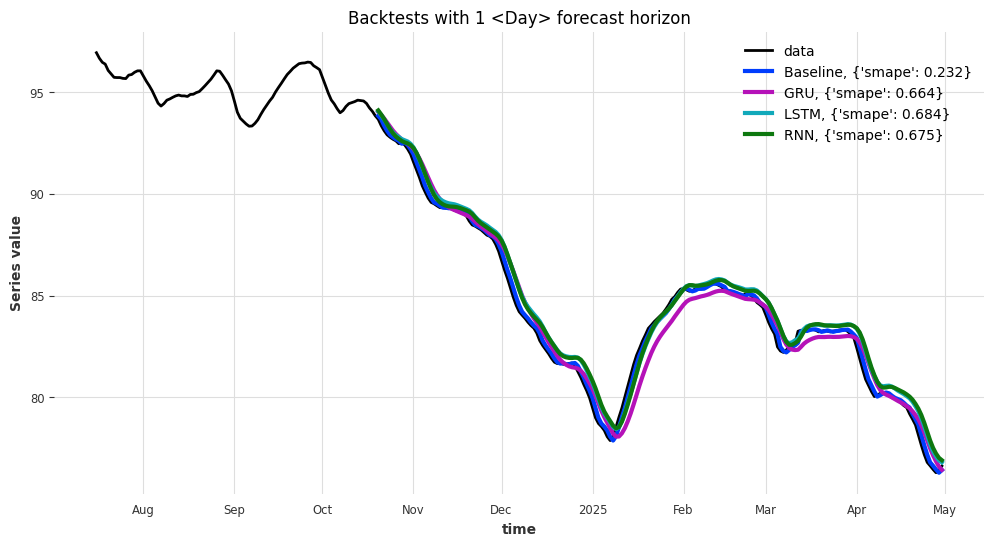

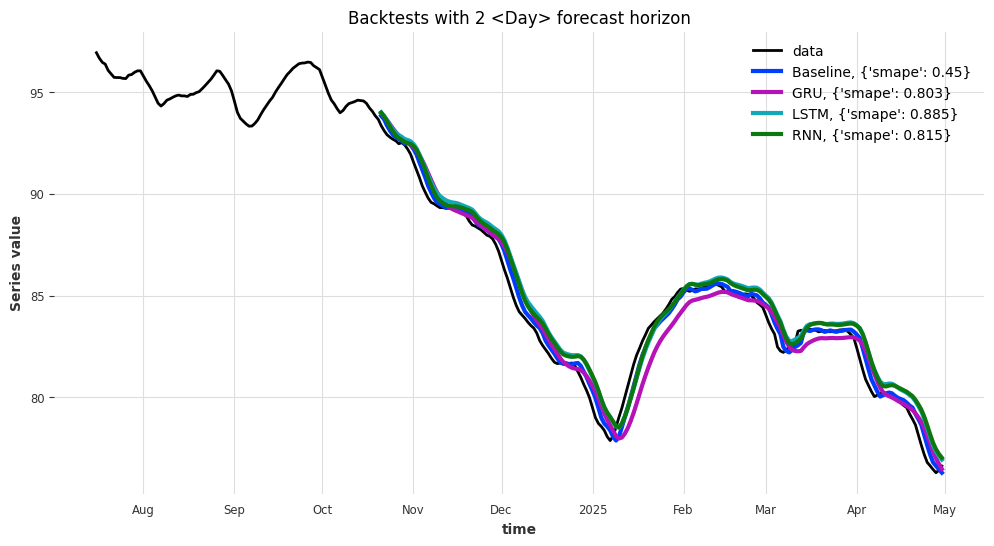

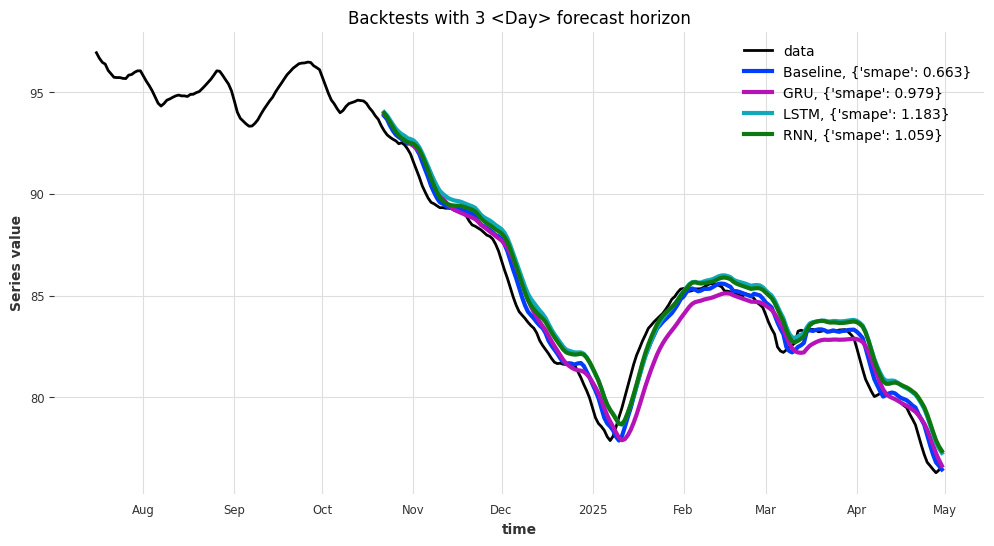

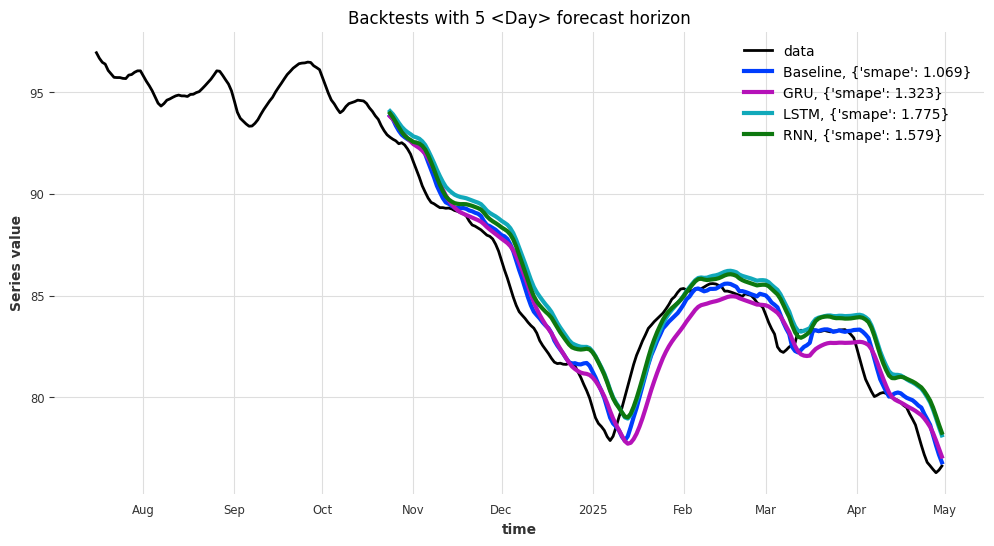

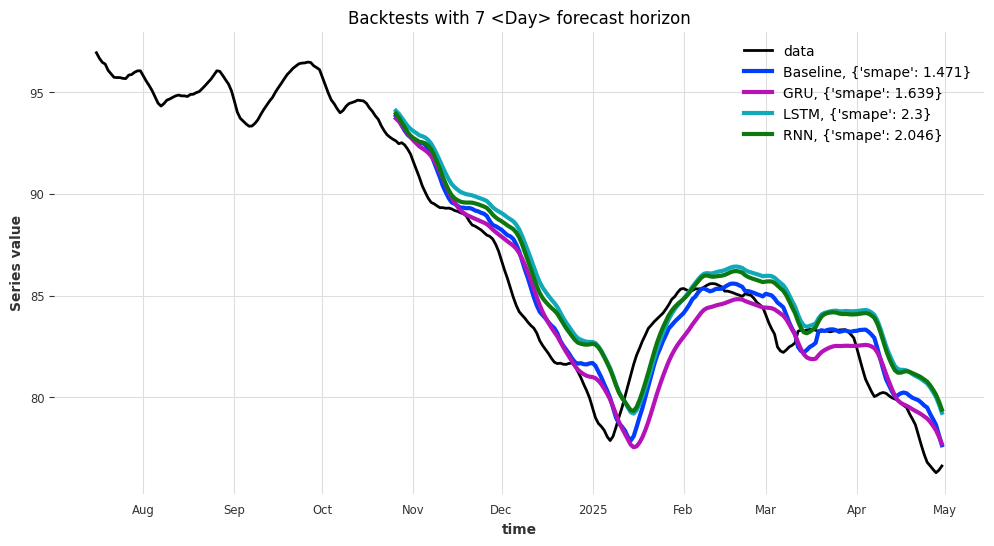

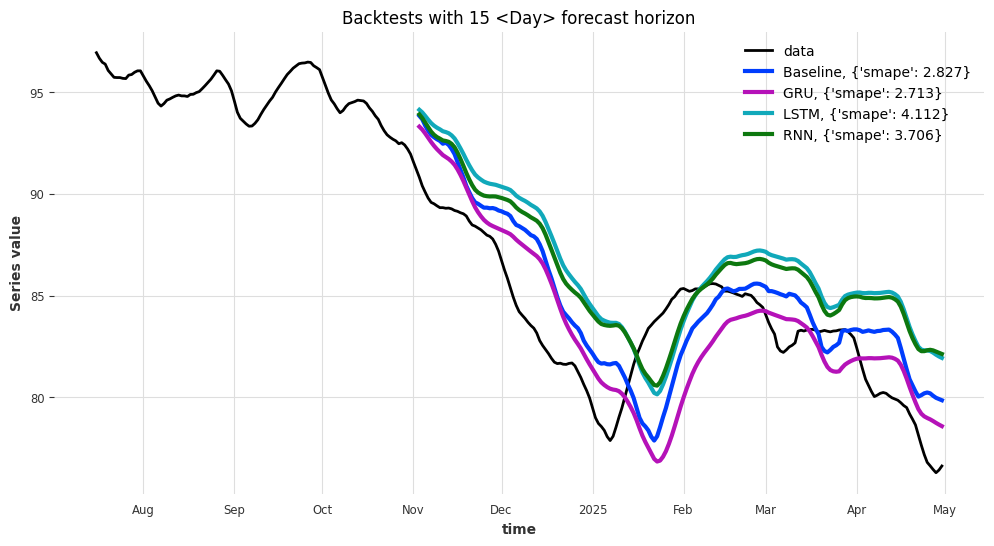

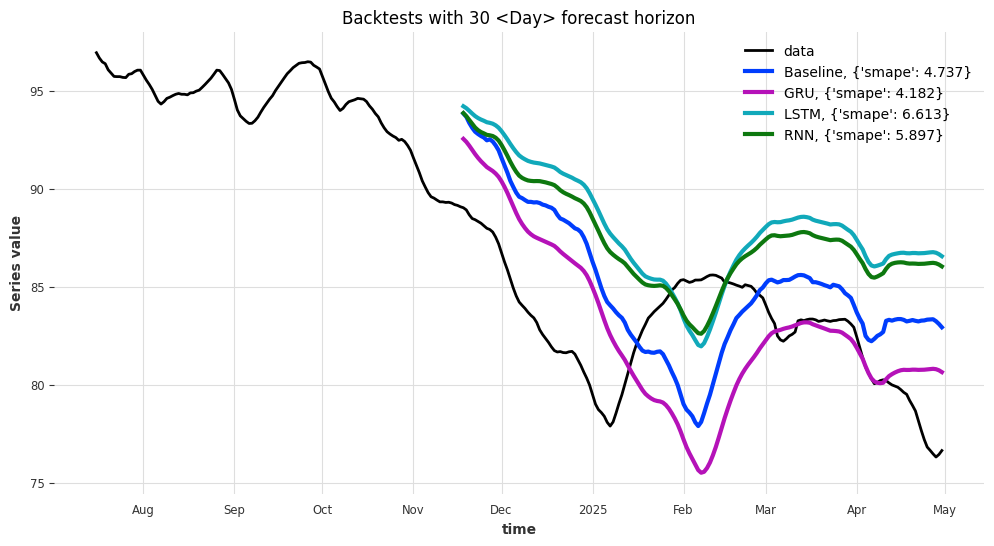

In [63]:
plot_backtest_results(
    series, 
    results, 
    points_to_test=len(test)
)


### Comparação da otimização dos modelos da família RNN

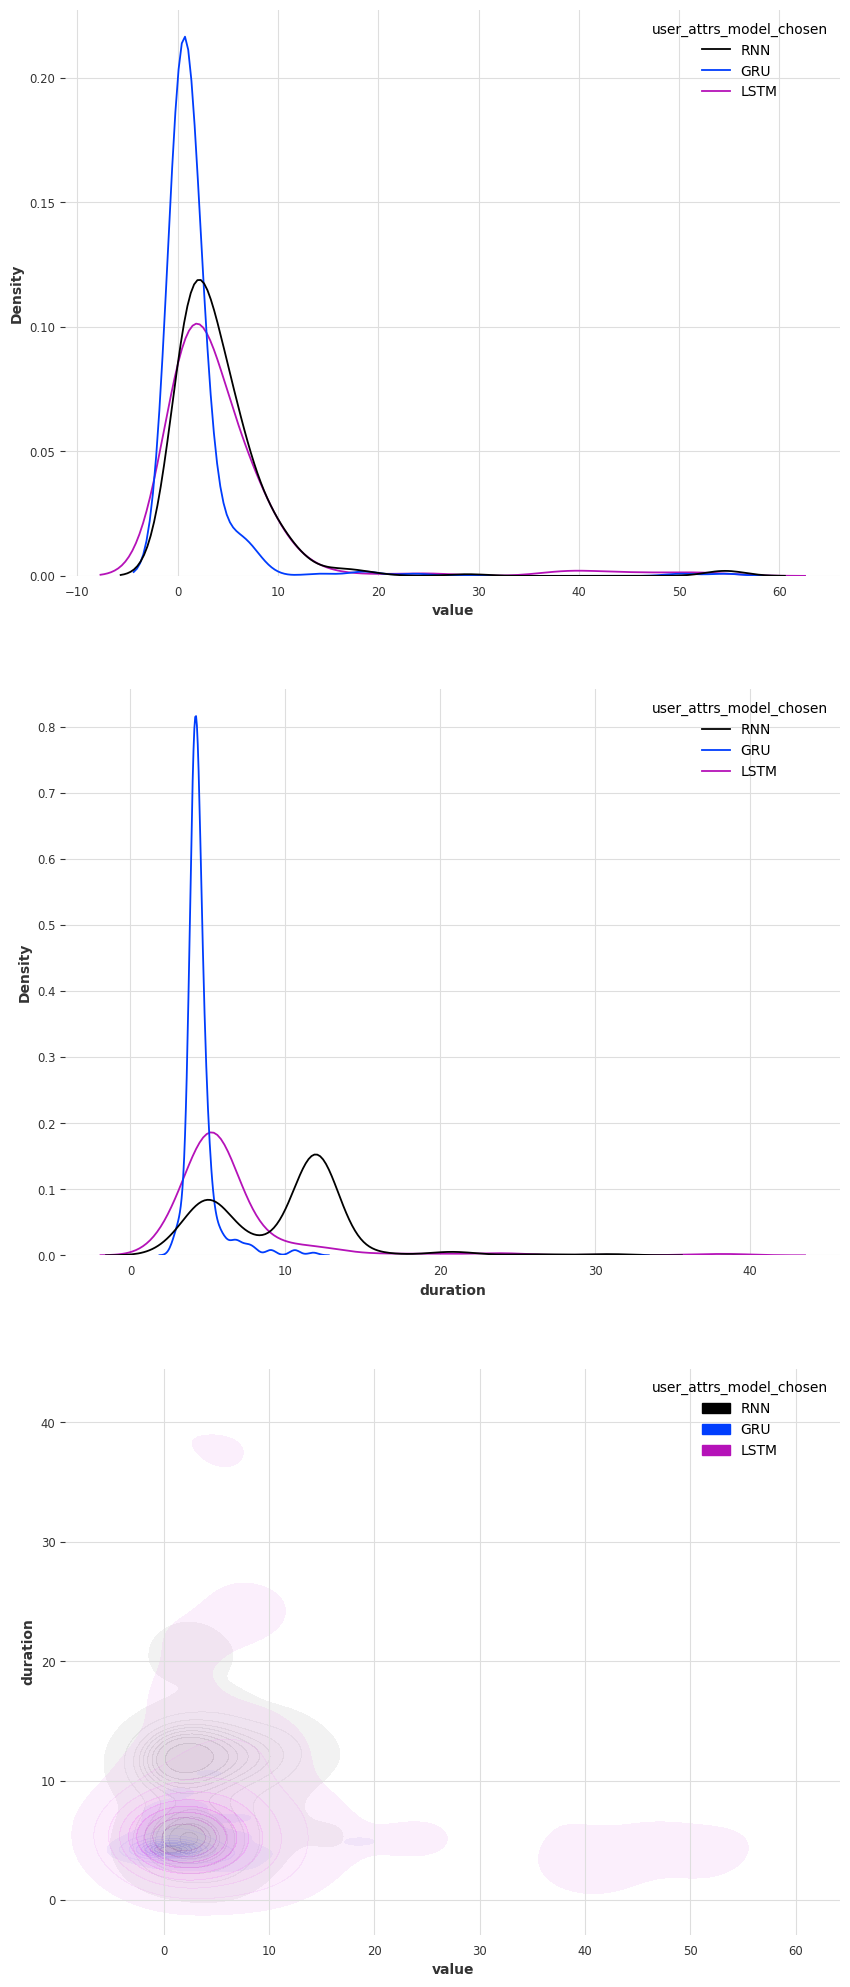

In [64]:
# sns.set(style='dark',)
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 25))
sns.kdeplot(study_df, x="value", hue="user_attrs_model_chosen", ax=ax1, common_norm=False)
sns.kdeplot(study_df, x="duration", hue="user_attrs_model_chosen", ax=ax2, common_norm=False)
sns.kdeplot(study_df, x="value", y="duration", hue="user_attrs_model_chosen", ax=ax3, common_norm=False, fill=True, alpha=.2)

plt.show()